<a href="https://colab.research.google.com/github/rockey1006/Research/blob/master/VAE_Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

In [ ]:
batch_size = 100 

original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

#2.1 定义encoder网络：输入x,中间结果h,输出采样z_mean 和 z_log_var
#keras 当前 layers的值=当前dense（lambda） layer的值（weight）*上一层的input
x = Input(shape=(original_dim,))#输入x,输入层784个结点
h = Dense(intermediate_dim, activation='relu')(x)#中间结果h，隐藏层256个结点，激活函数relu
z_mean = Dense(latent_dim)(h)#隐变量输出层1有2 个结点
z_log_var = Dense(latent_dim)(h)#隐变量输出层2有2个结点

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])#输入是z_mean和z_log_var，输出是z

In [ ]:
decoder_h = Dense(intermediate_dim, activation='relu')#隐藏层
decoder_mean = Dense(original_dim, activation='sigmoid')#输出层

h_decoded = decoder_h(z)#中间值
x_decoded_mean = decoder_mean(h_decoded)#输出值

#2.4 定义函数式模型接口API:Model ,定义Model内相关参数（loss等）
# instantiate VAE model
vae = Model(x, x_decoded_mean)
#model = Model(inputs=[a1, a2], outputs=[b1, b3, b3])

# Compute VAE loss
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) #KL+交叉熵
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss) #复杂损失函数所以不在compile声明，而使用add_loss
vae.compile(optimizer='rmsprop') #用于配置训练模型。

#compile(self, optimizer, loss, metrics=None, loss_weights=None, sample_weight_mode=None, 
#weighted_metrics=None, target_tensors=None)

In [ ]:
(x_train, _), (x_test, y_test) = mnist.load_data()
#返回值
#两个Tuple,(X_train, y_train), (X_test, y_test)
'''
X_train和X_test：是形如（nb_samples, 28, 28）的灰度图片数据，数据类型是无符号8位整形（uint8）0-255
y_train和y_test：是形如（nb_samples,）标签数据，标签的范围是0~9
'''
#print(x_train[0])#打印第一张图片数据
#print( _[0])#第一个标签数据
x_train = x_train.astype('float32') / 255.#数据预处理归一化
#print(x_train[0])#打印第一张图片数据
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))#改变shape从(6000,28,28)到(6000,784)
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [ ]:
vae.fit(x_train,#算输出和输入分布的差异所以没有y
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
        validation_data=(x_test, None))

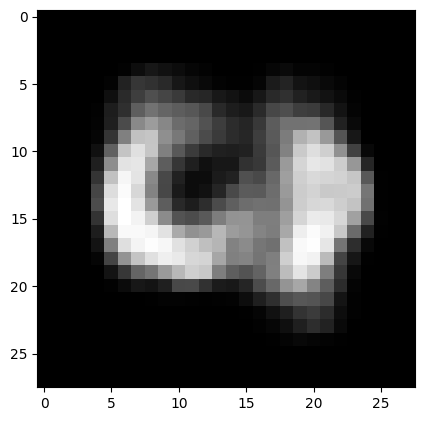

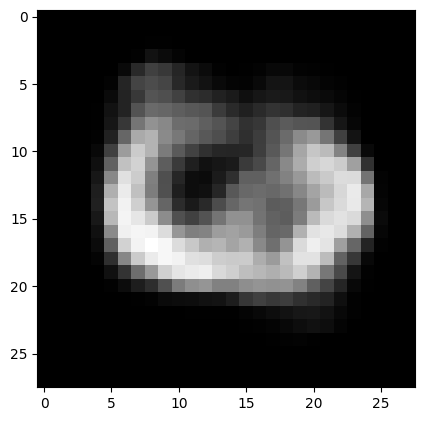

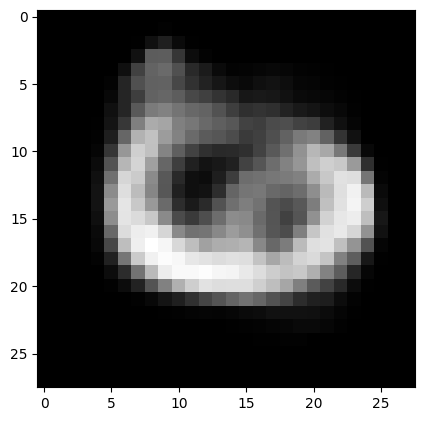

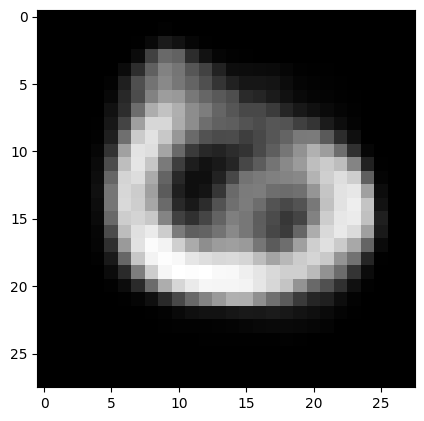

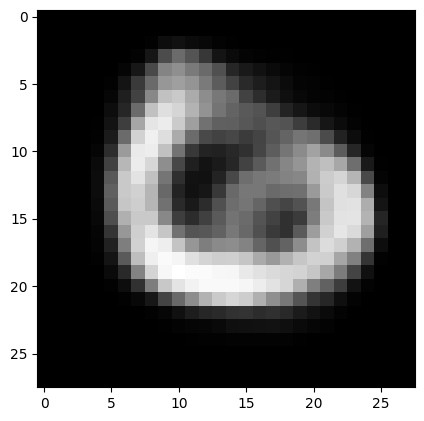

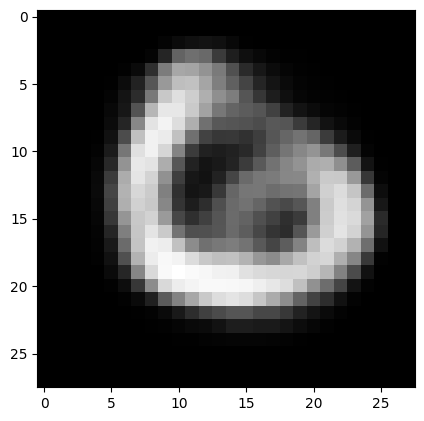

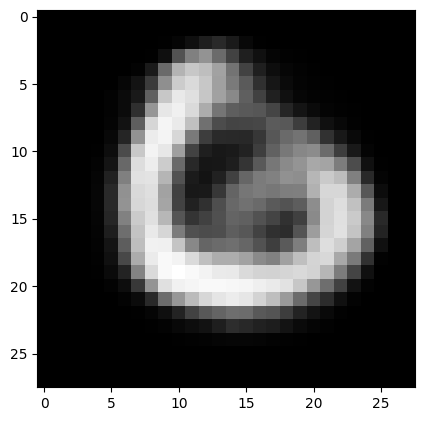

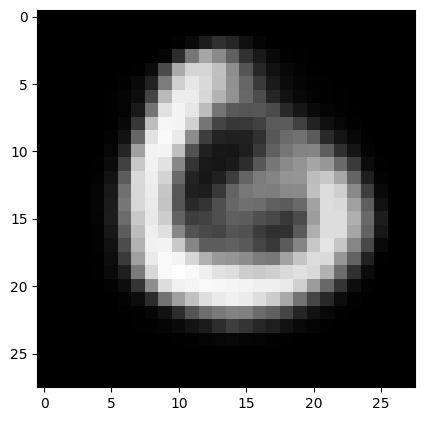

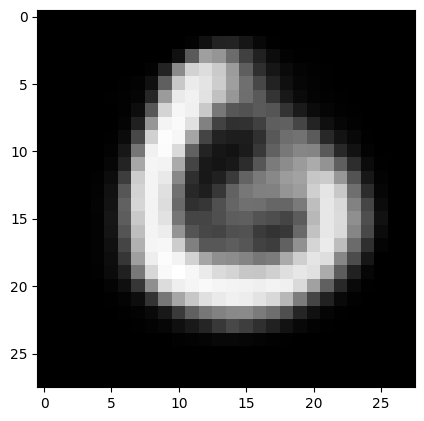

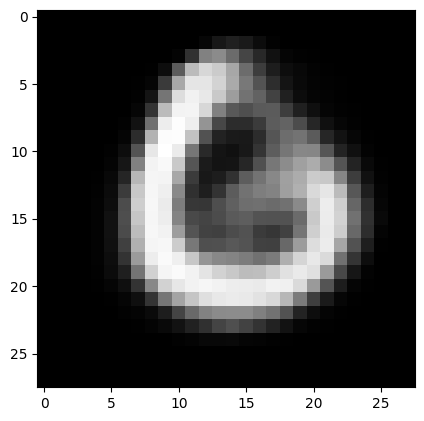

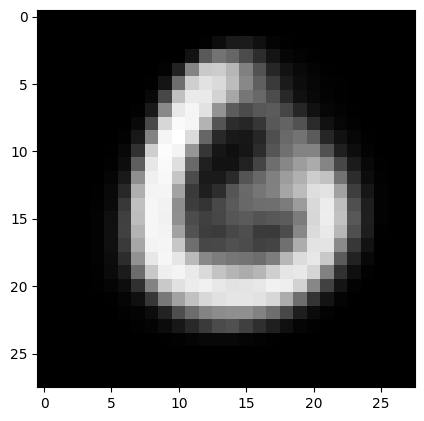

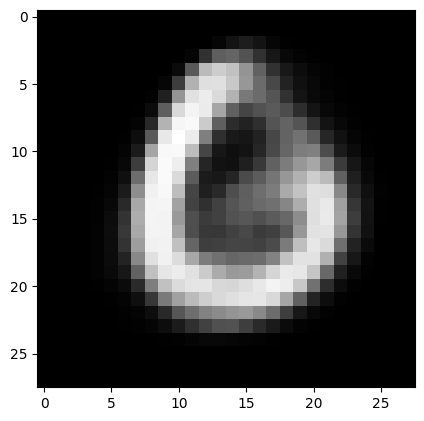

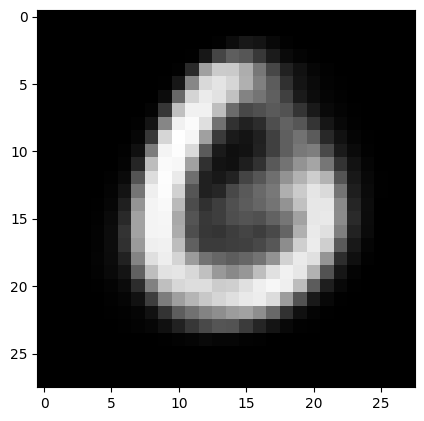

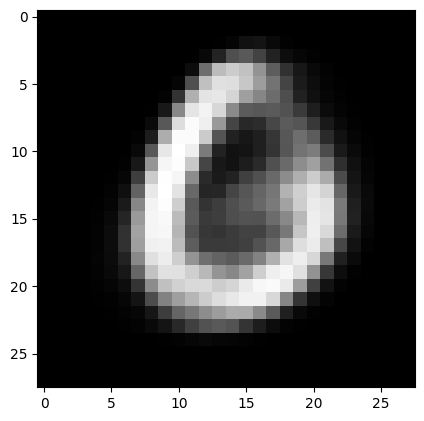

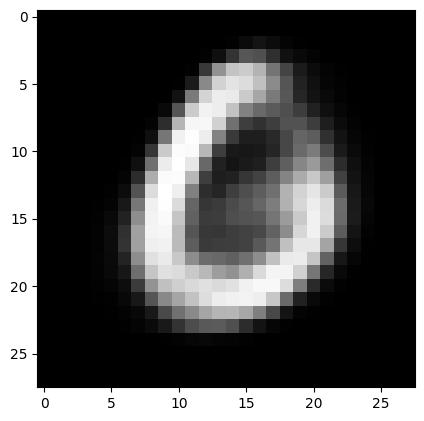

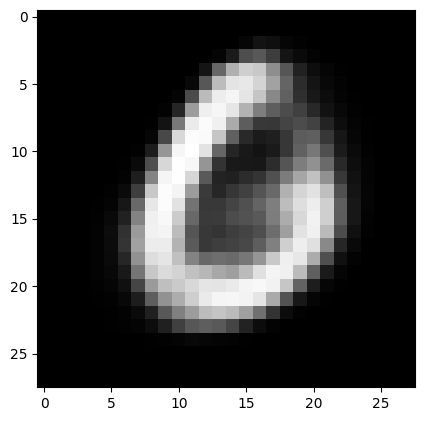

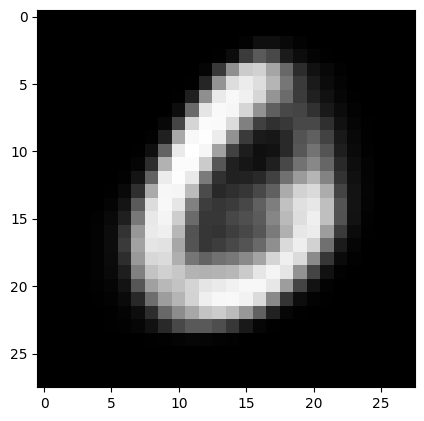

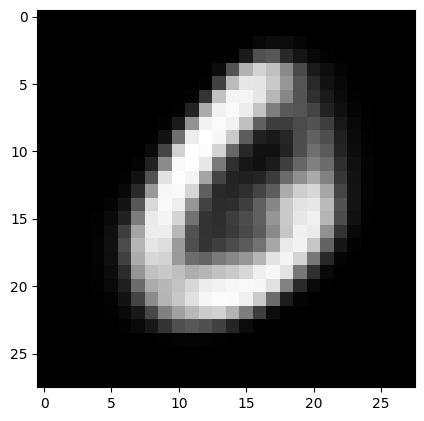

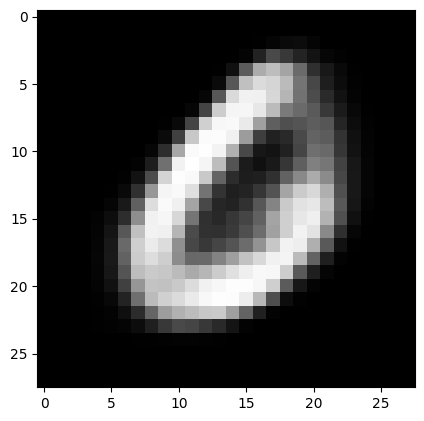

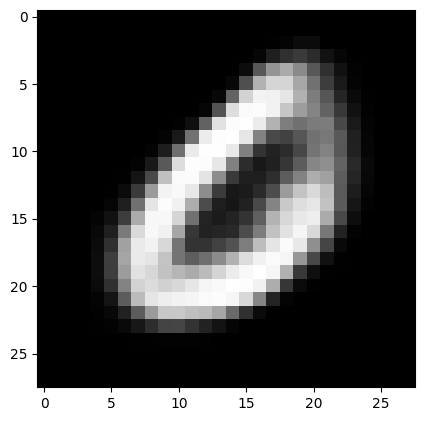

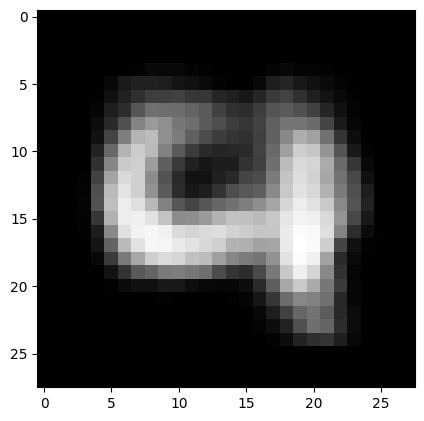

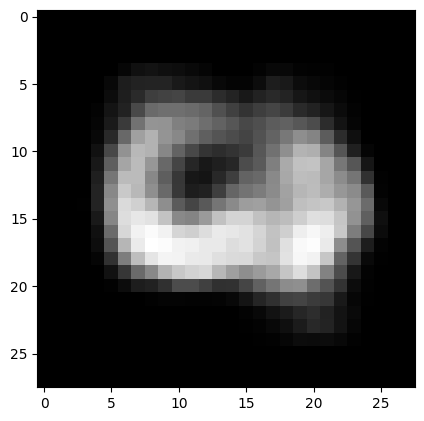

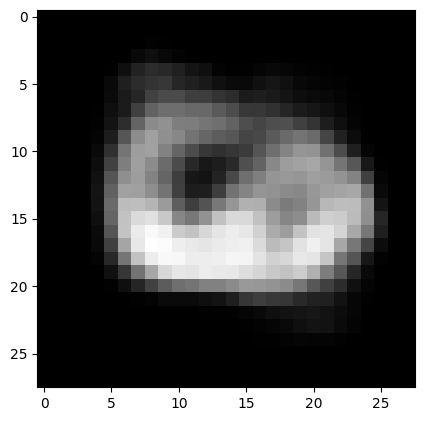

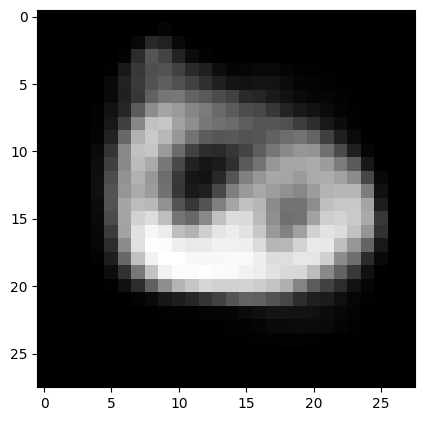

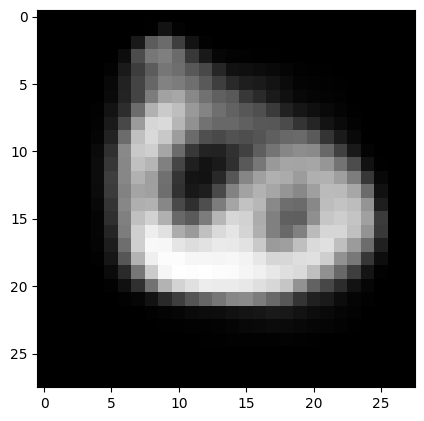

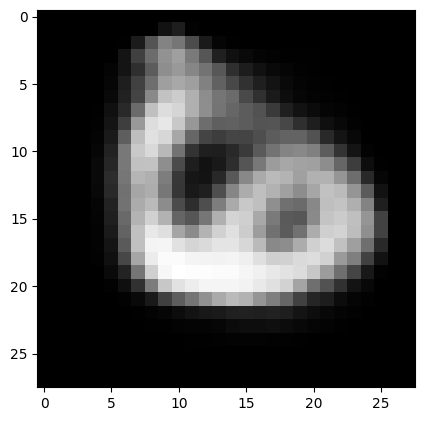

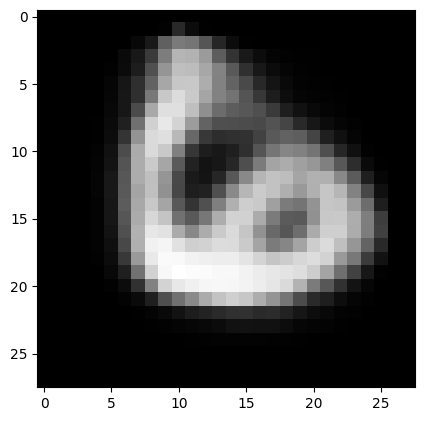

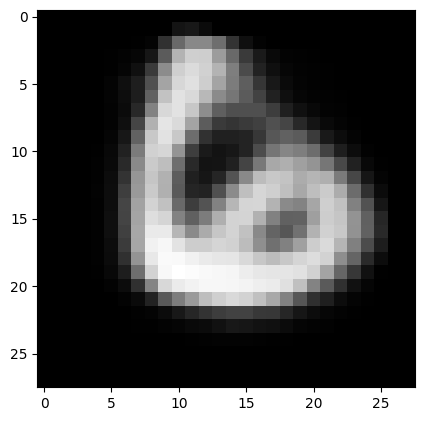

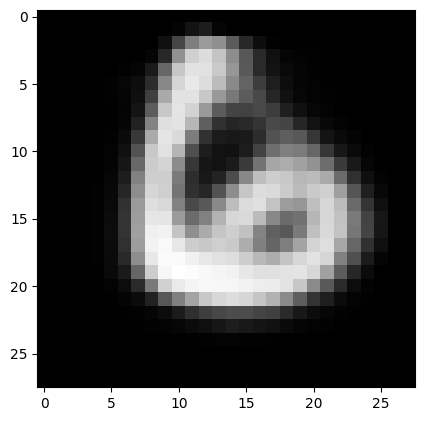

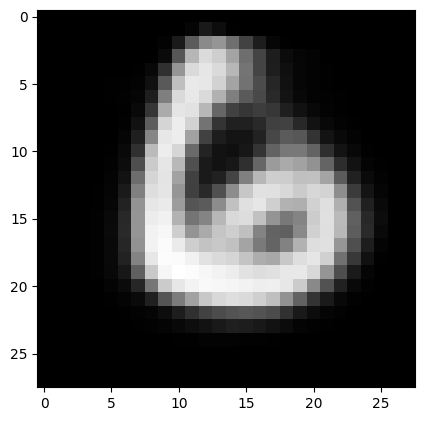

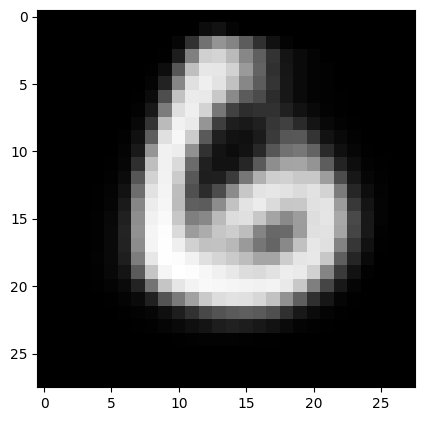

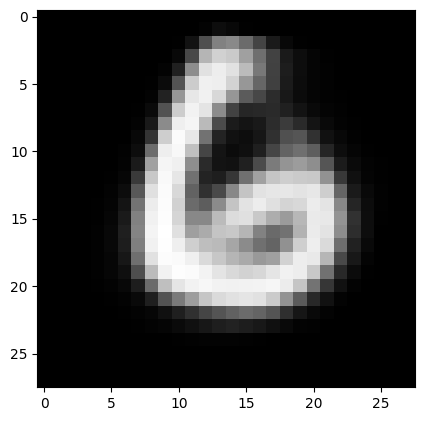

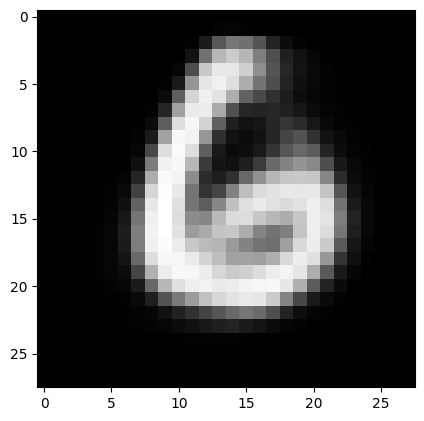

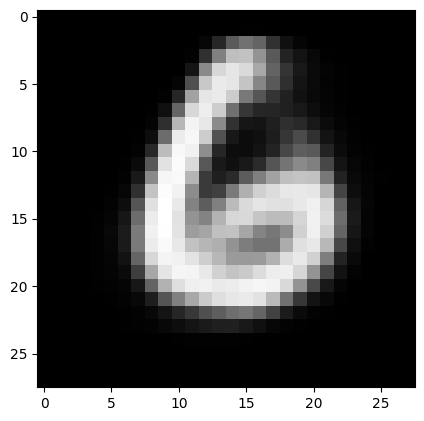

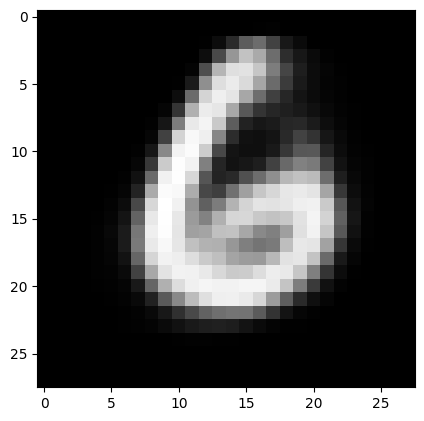

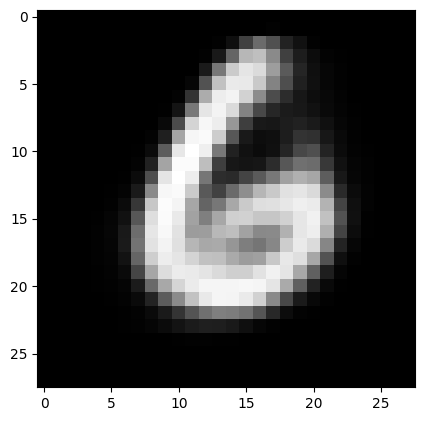

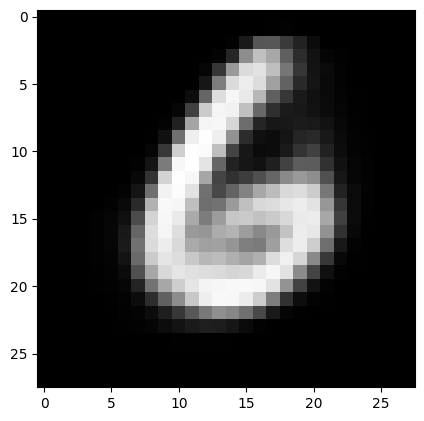

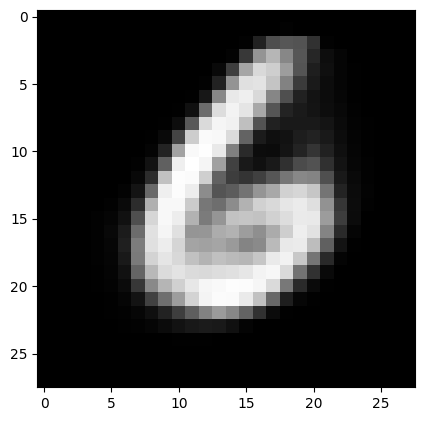

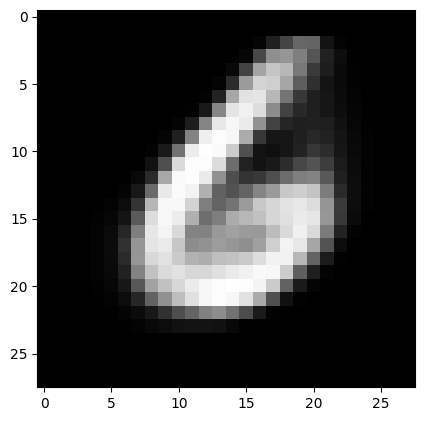

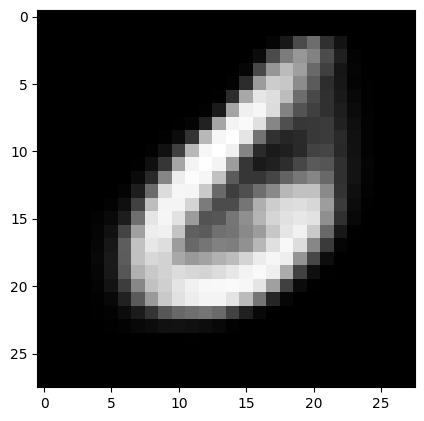

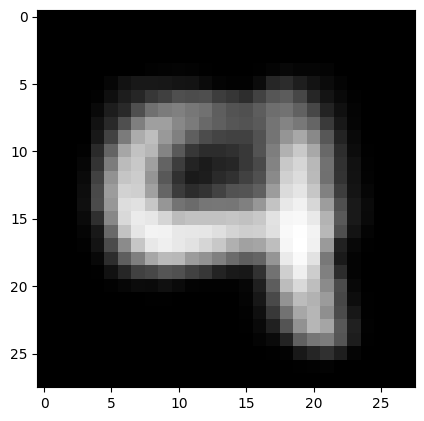

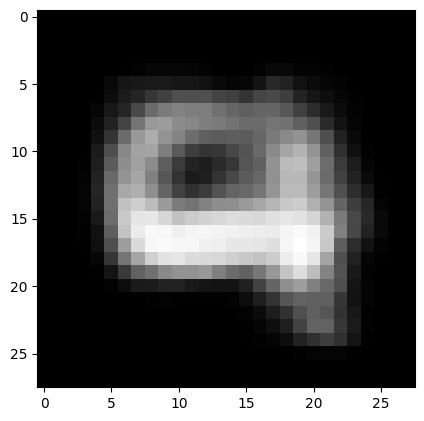

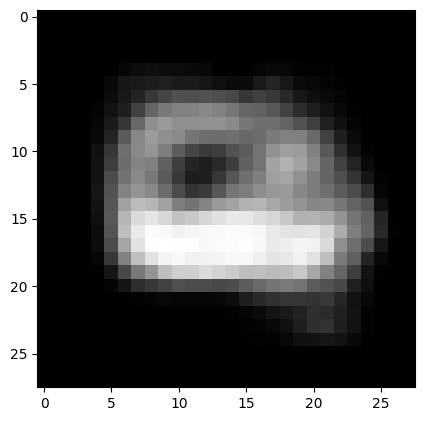

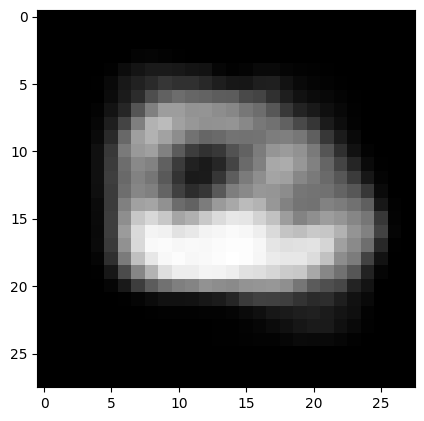

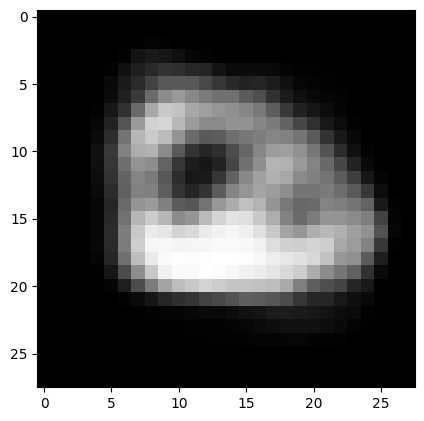

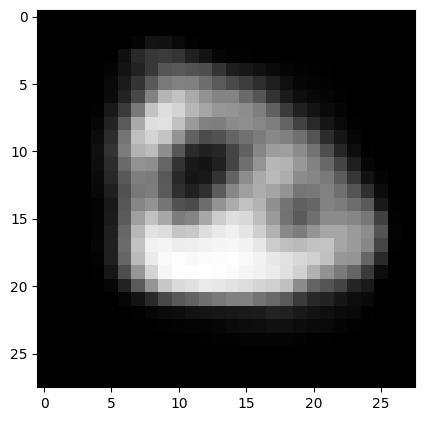

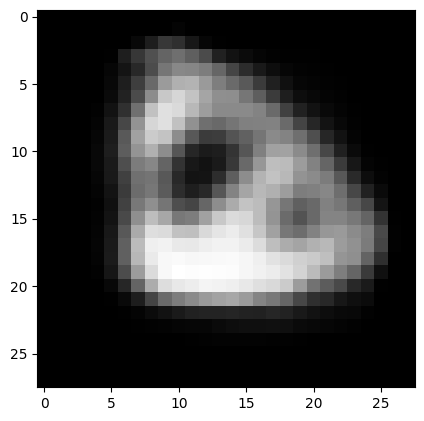

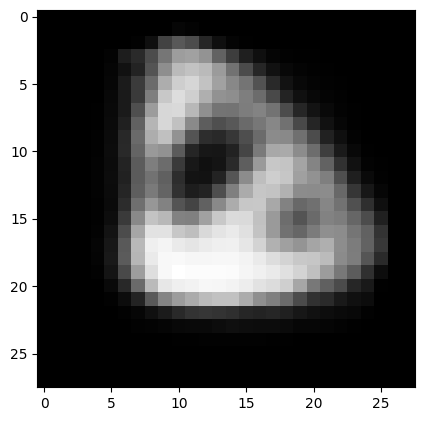

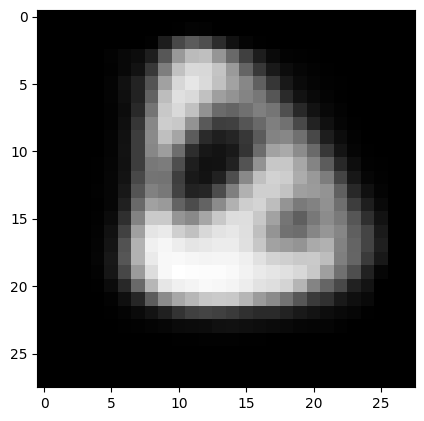

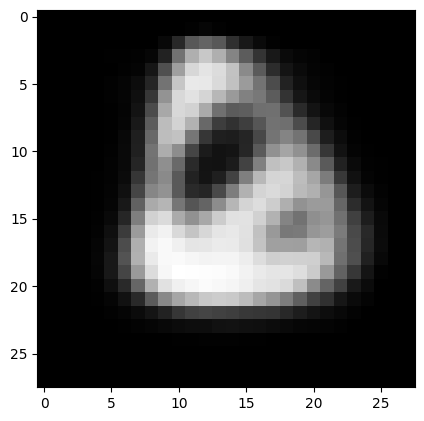

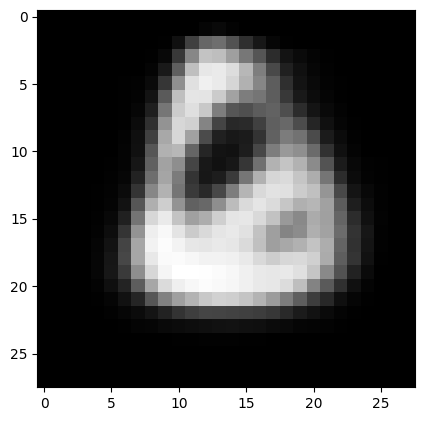

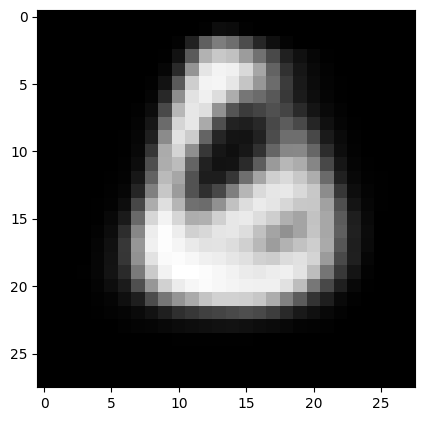

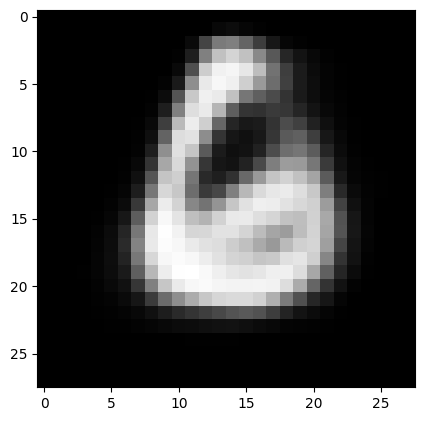

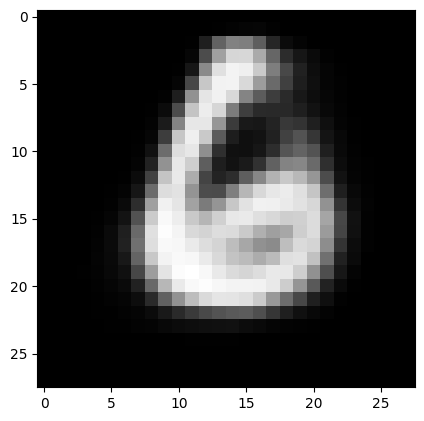

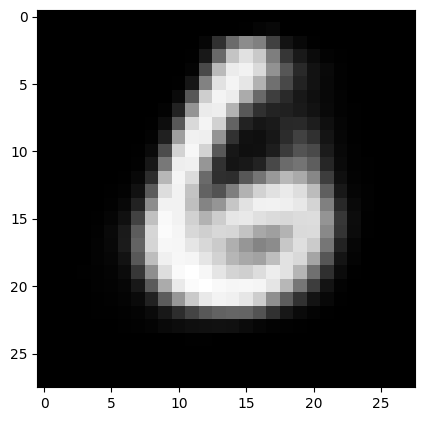

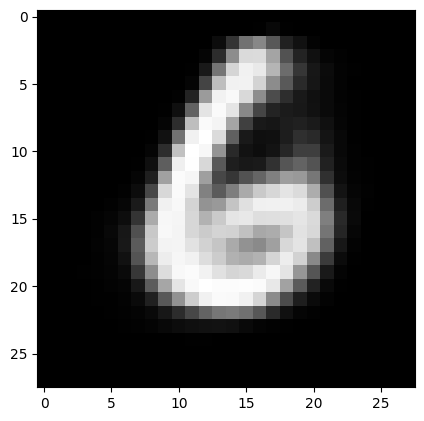

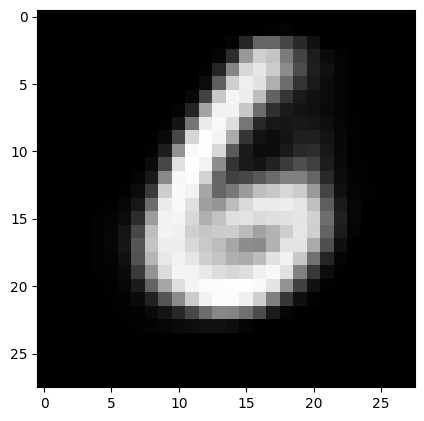

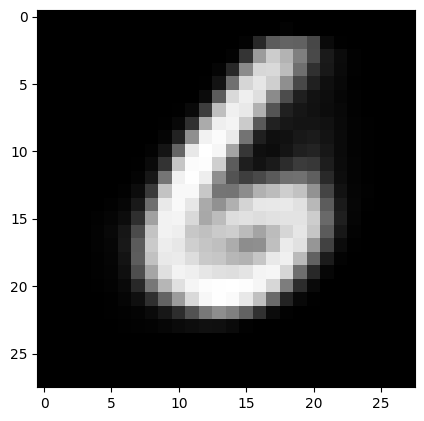

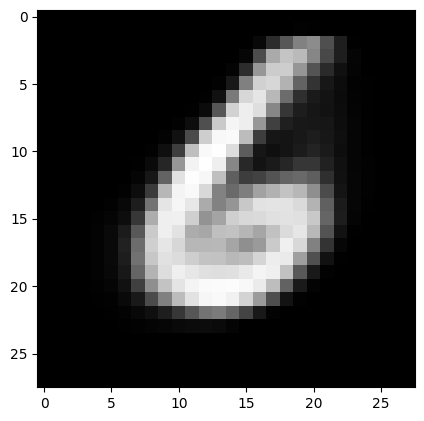

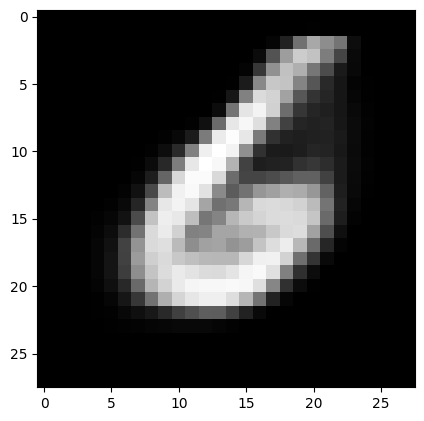

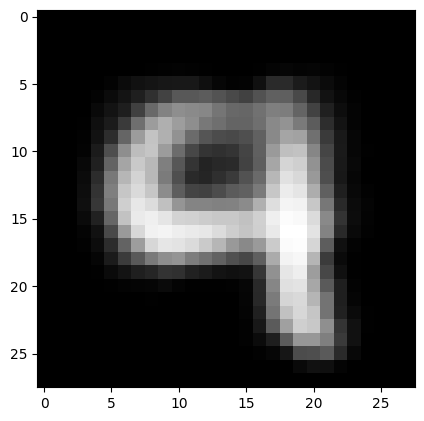

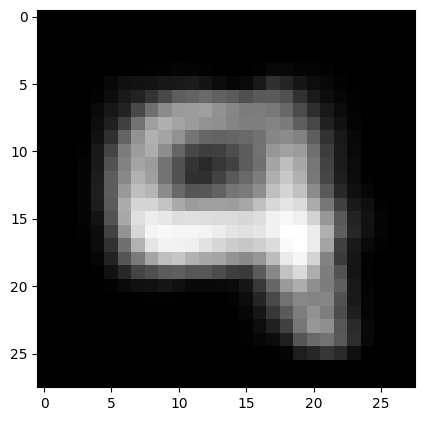

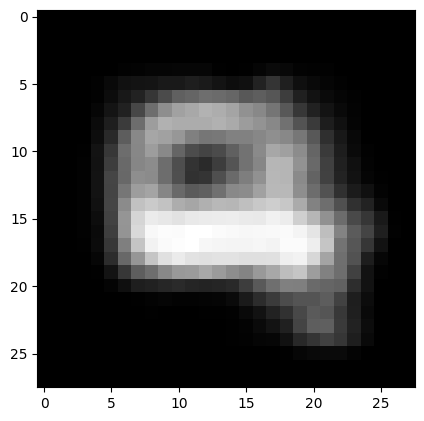

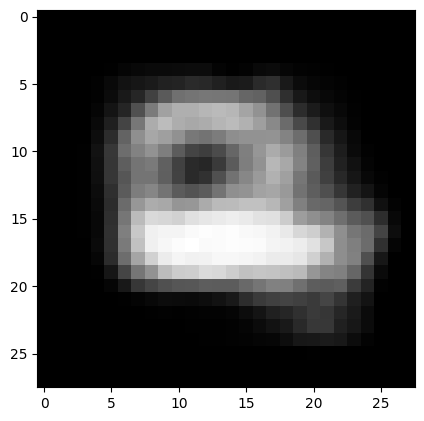

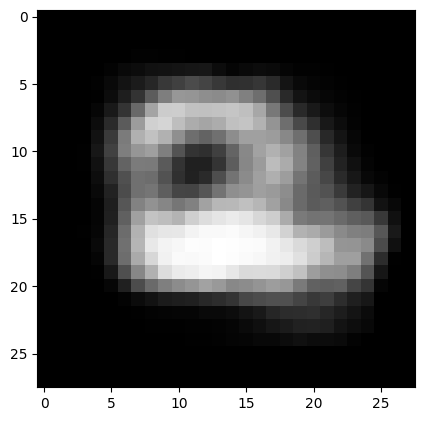

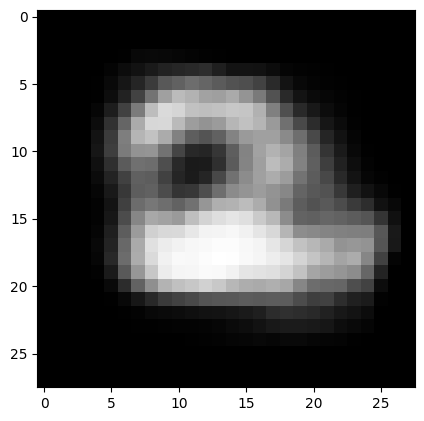

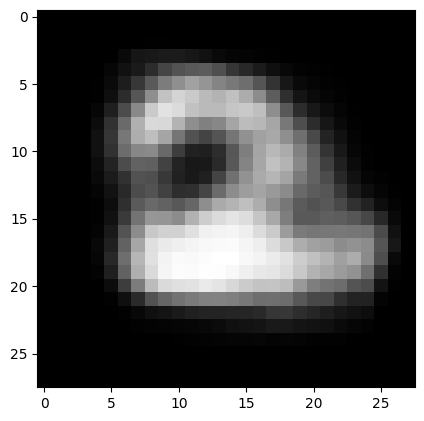

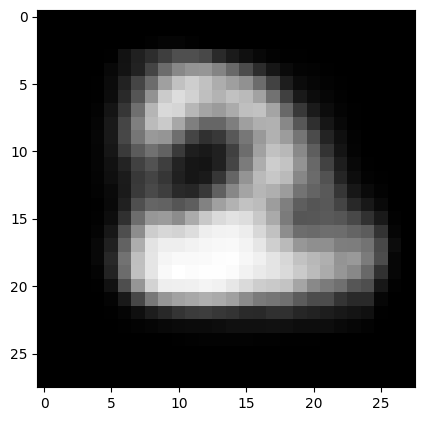

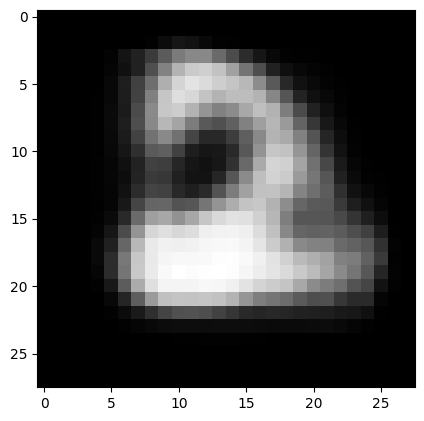

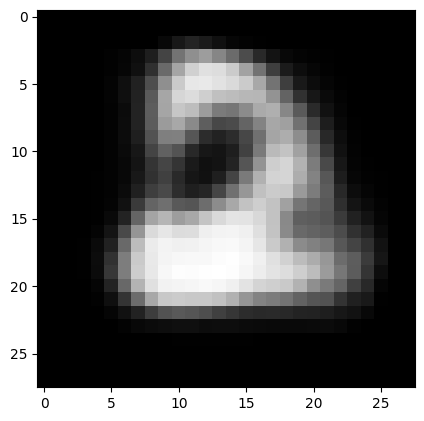

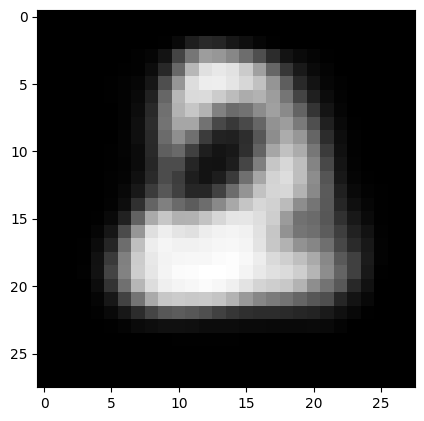

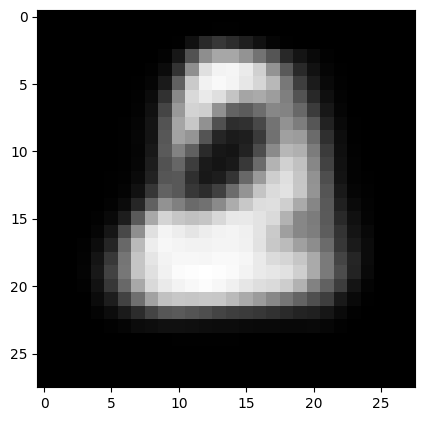

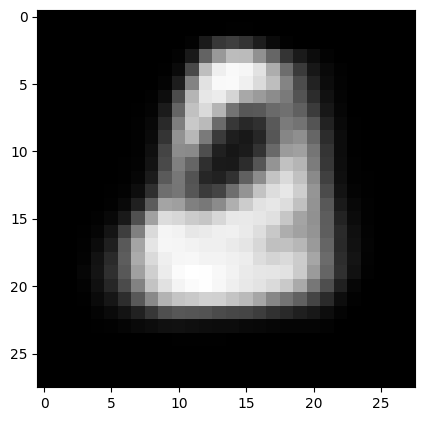

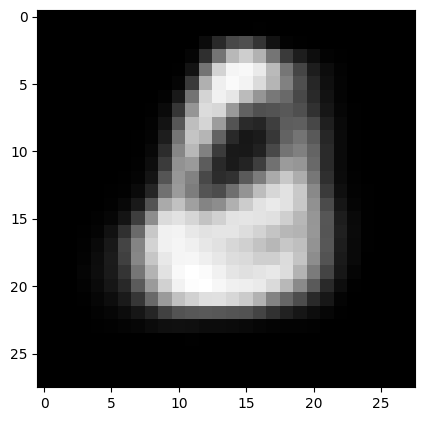

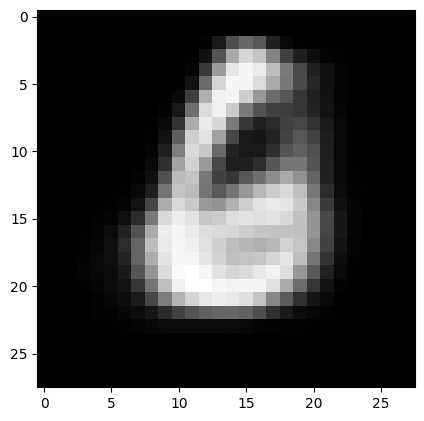

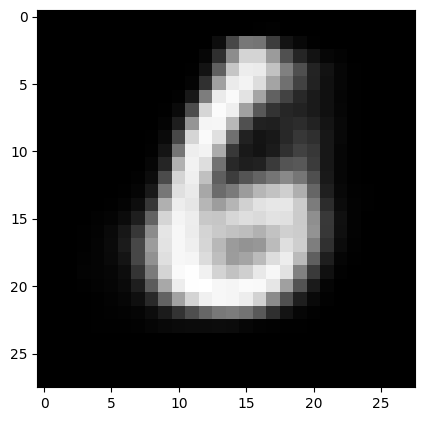

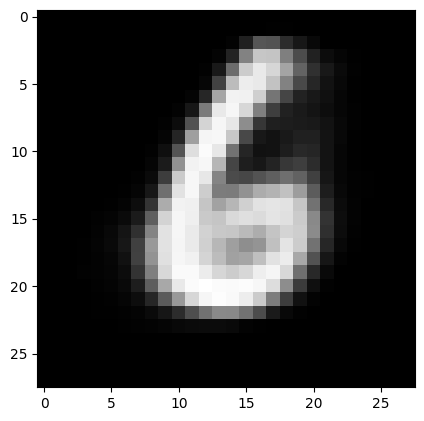

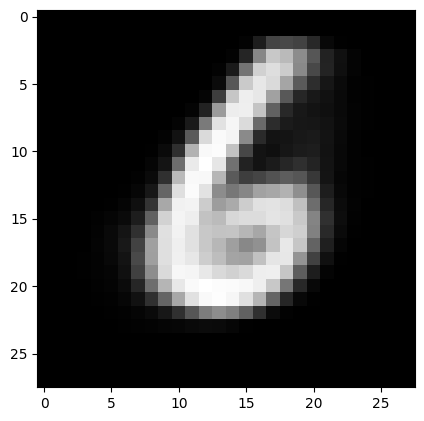

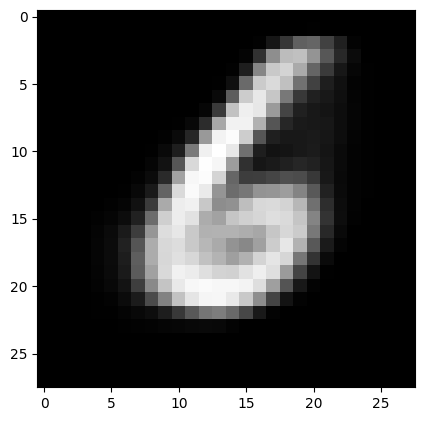

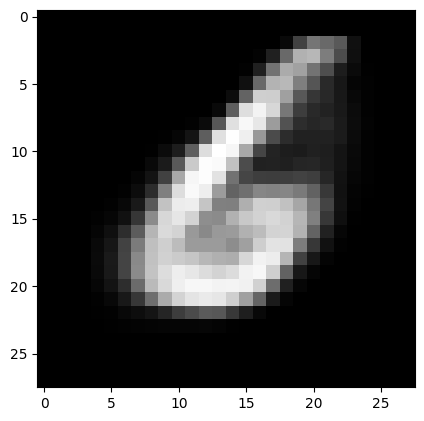

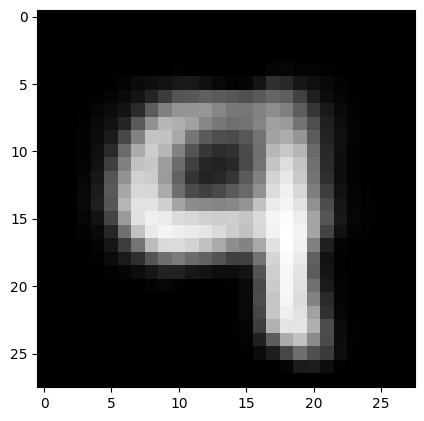

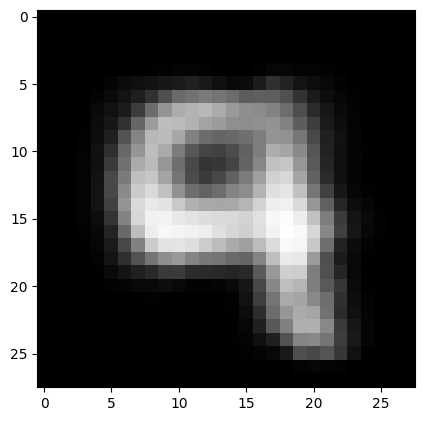

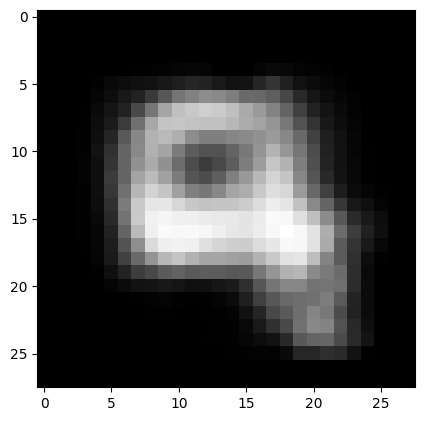

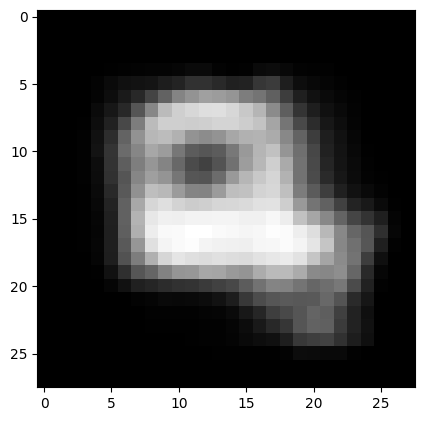

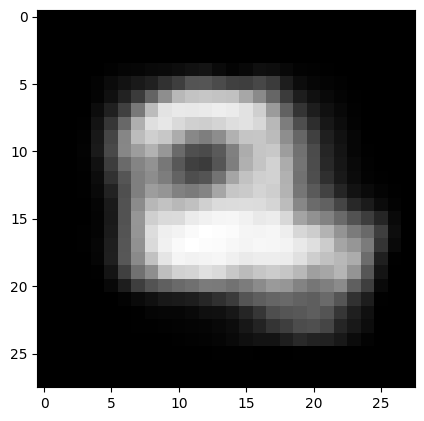

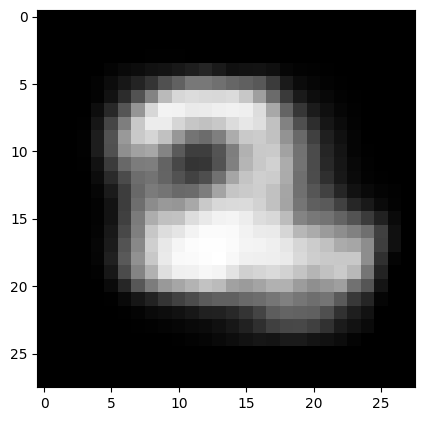

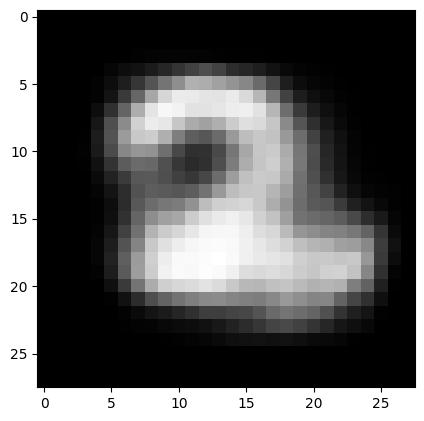

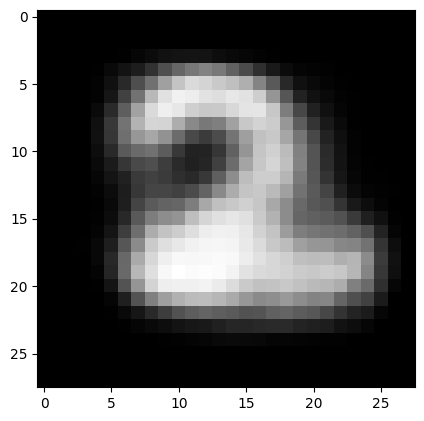

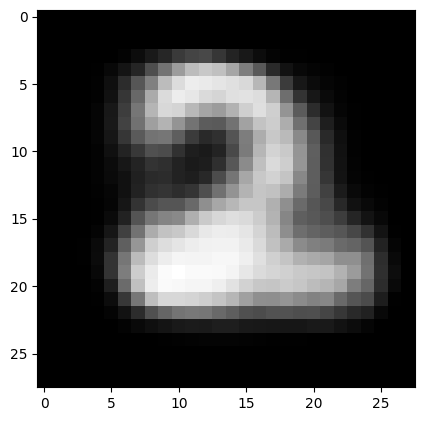

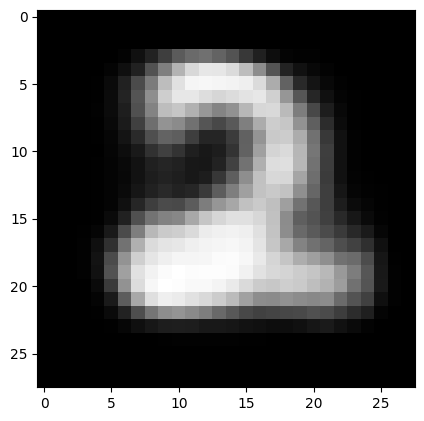

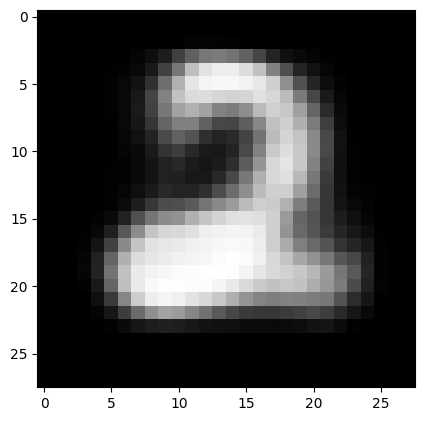

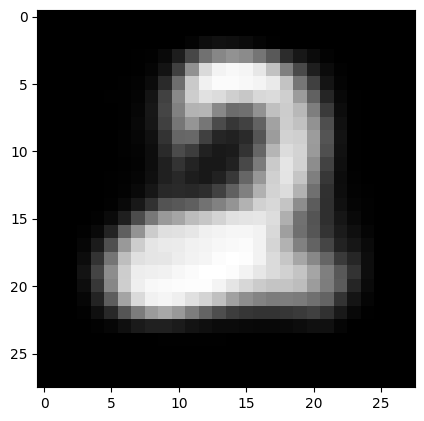

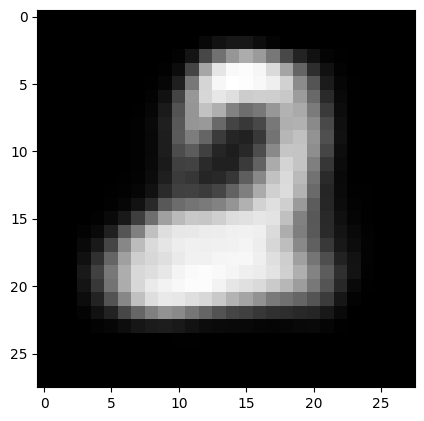

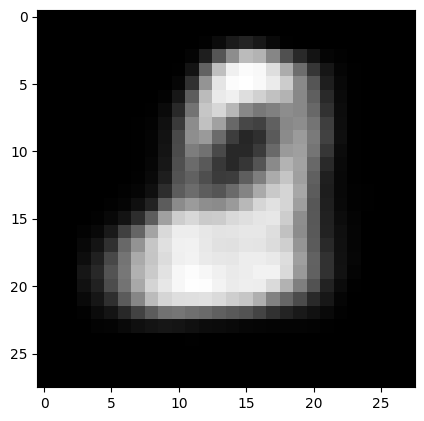

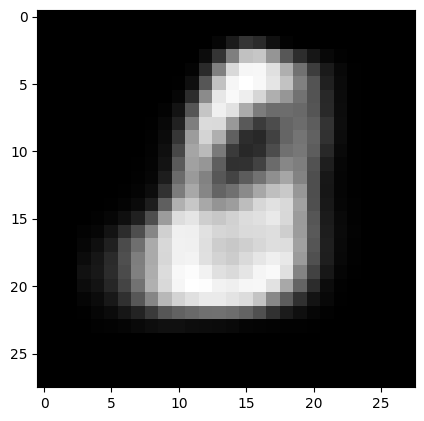

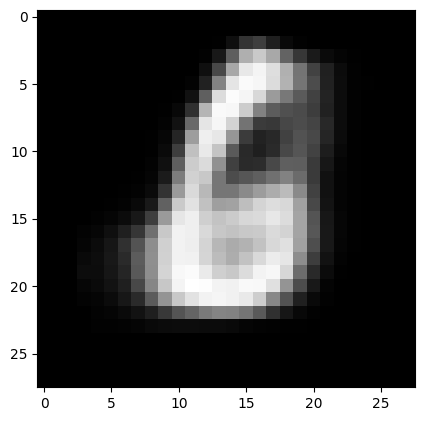

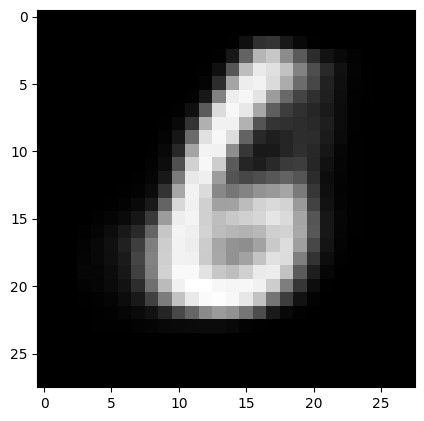

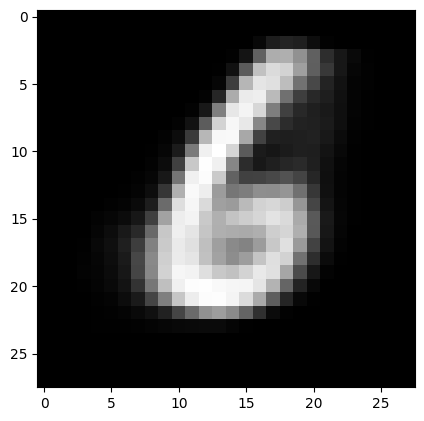

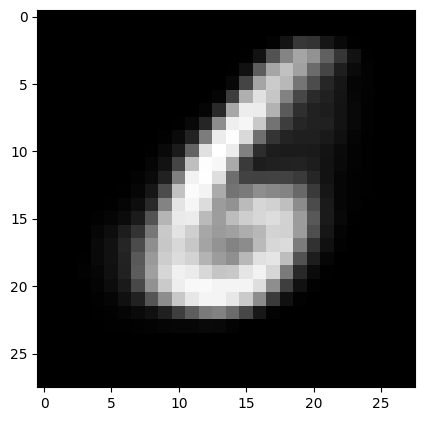

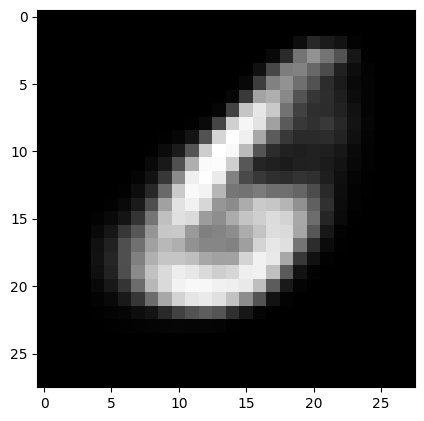

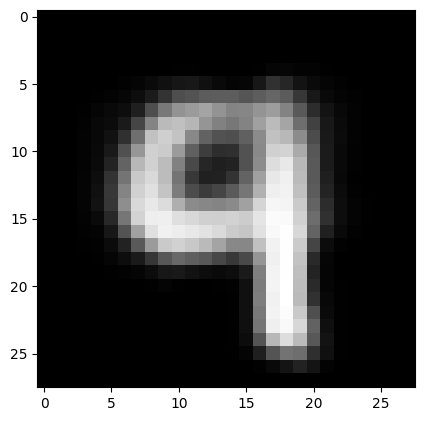

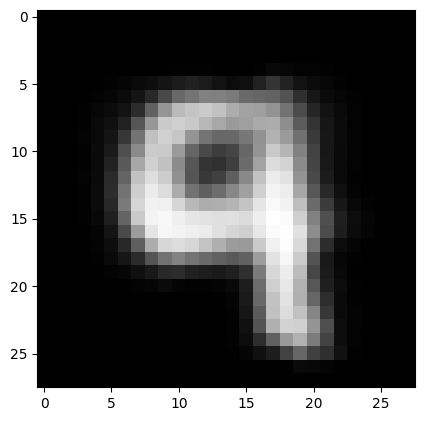

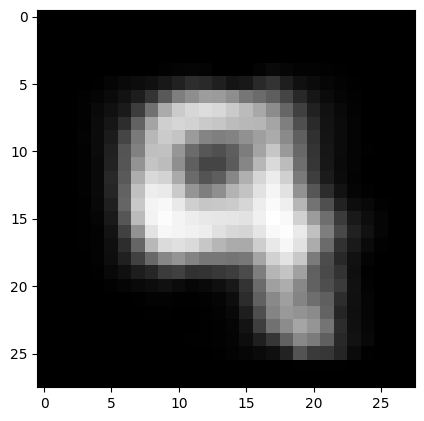

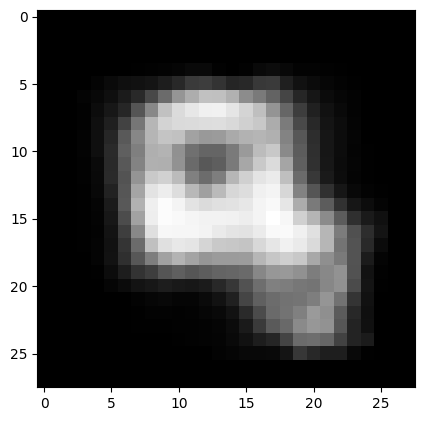

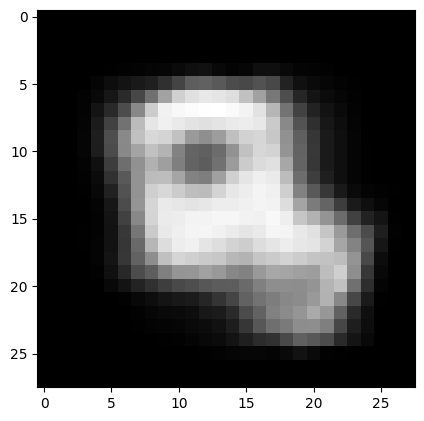

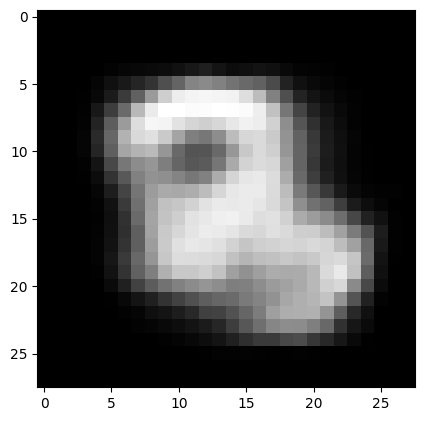

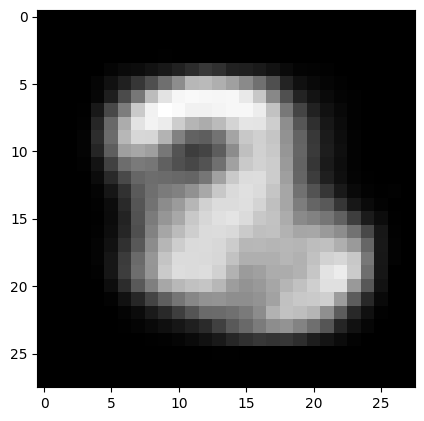

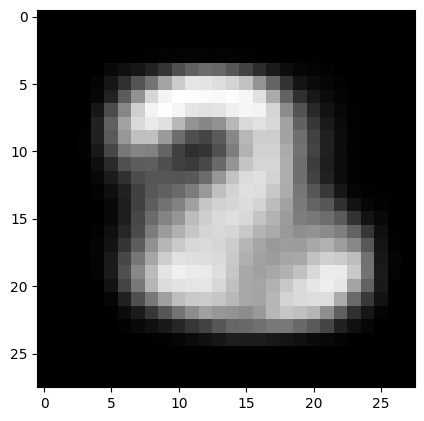

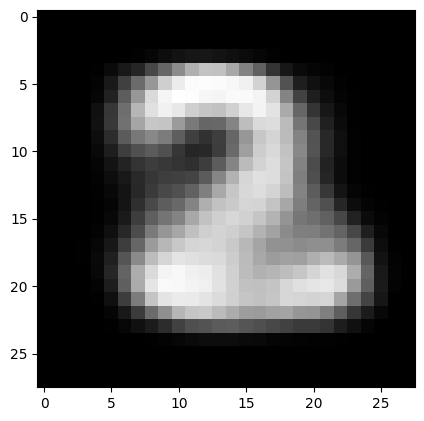

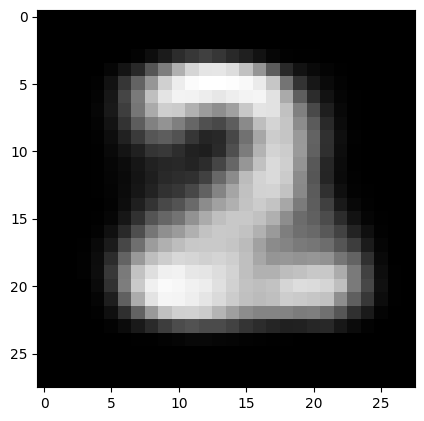

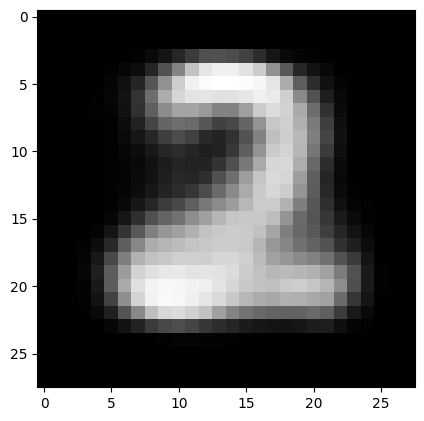

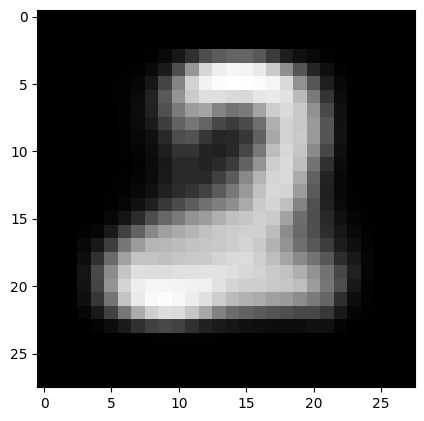

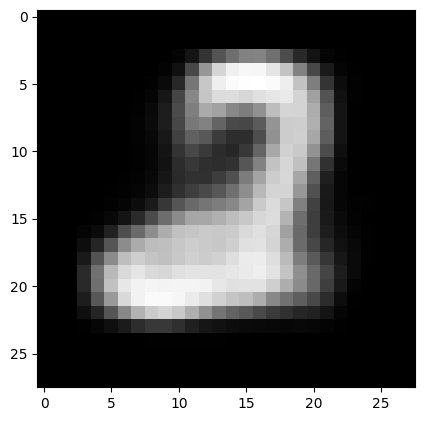

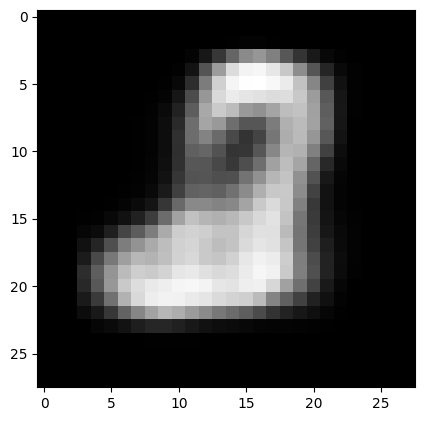

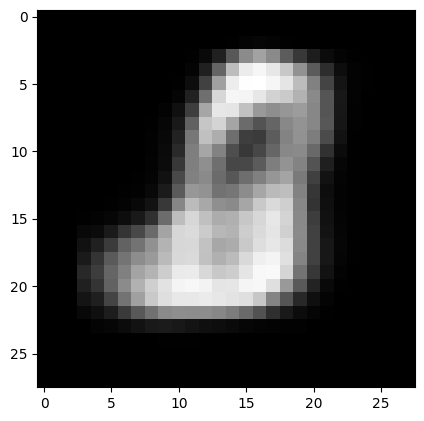

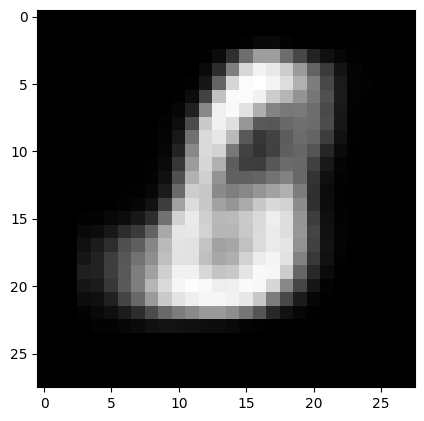

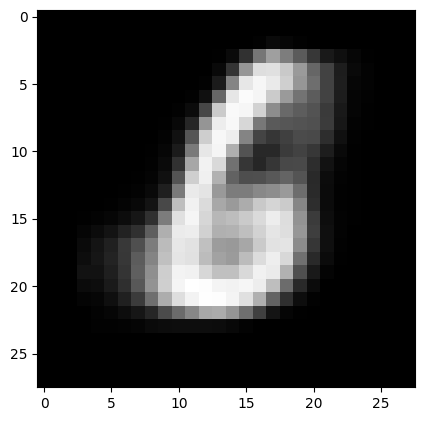

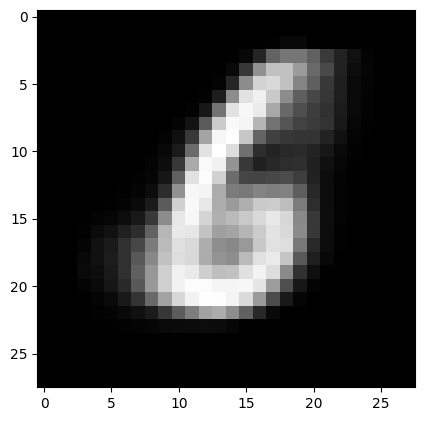

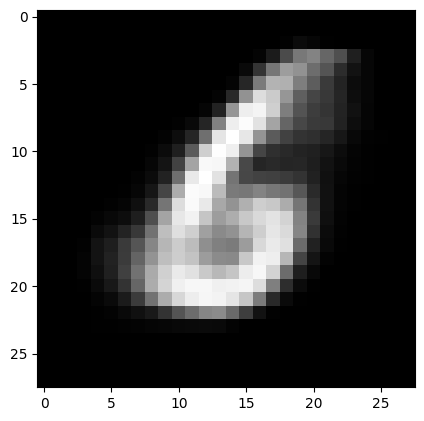

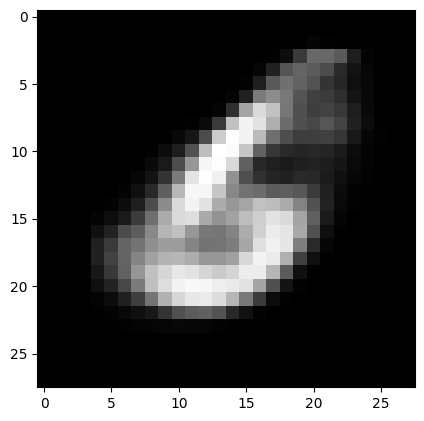

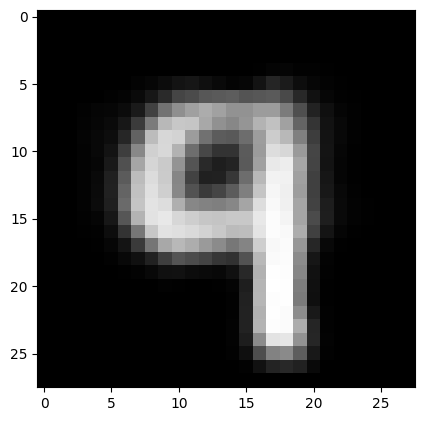

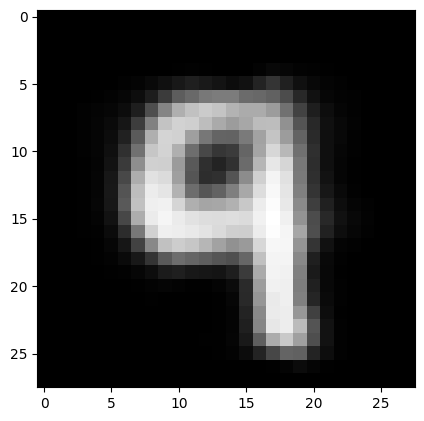

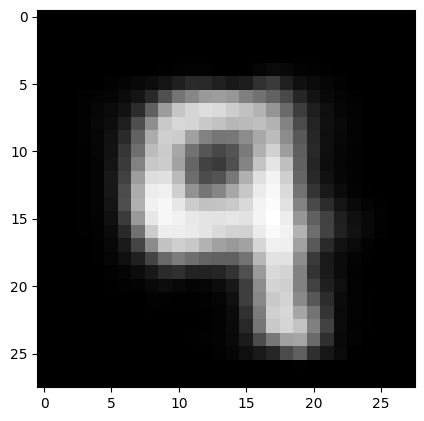

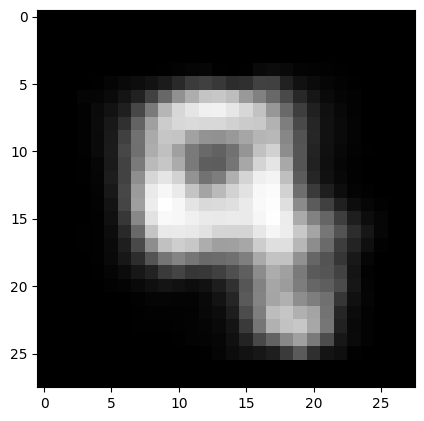

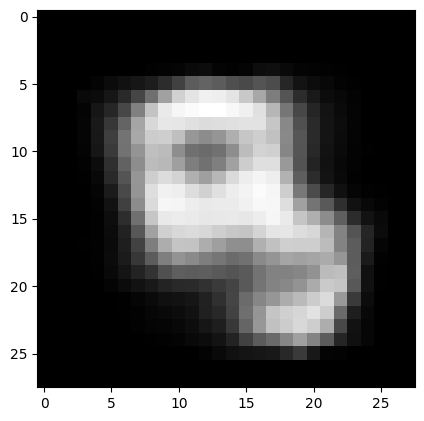

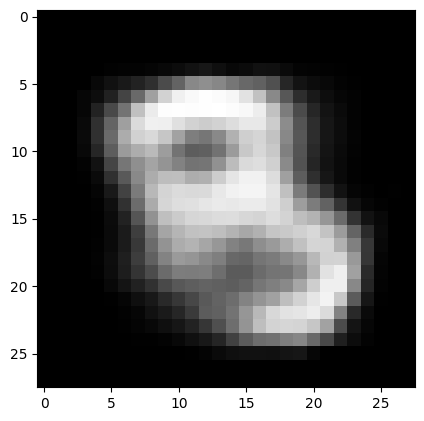

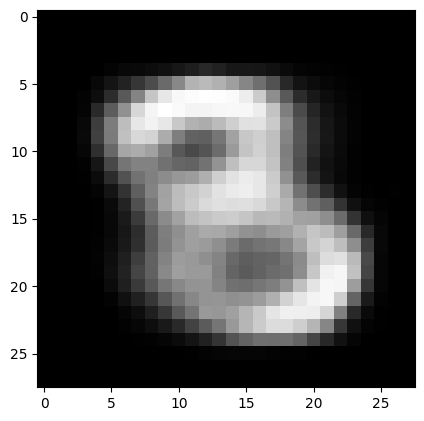

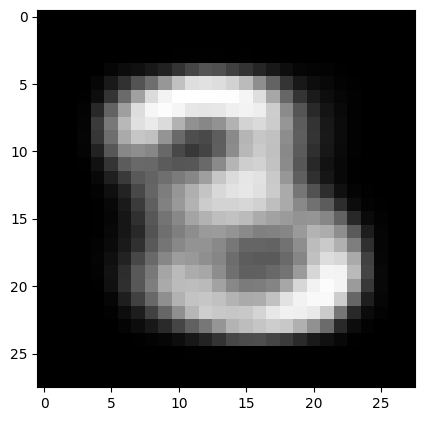

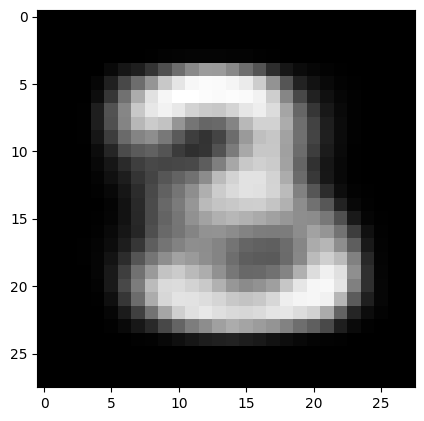

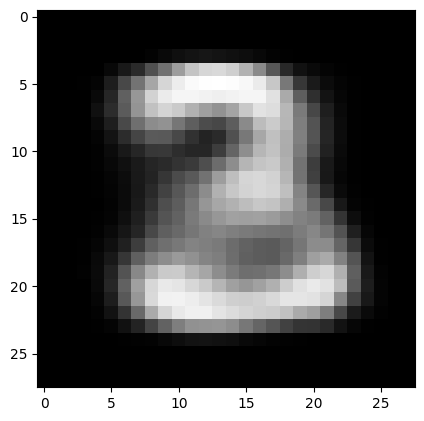

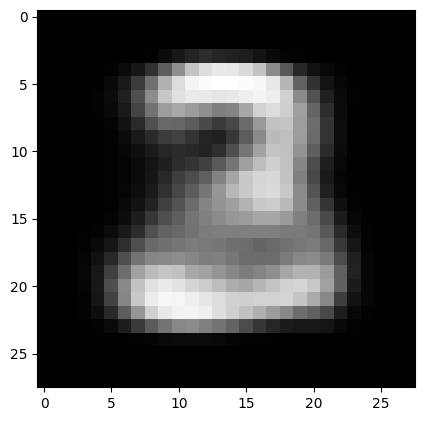

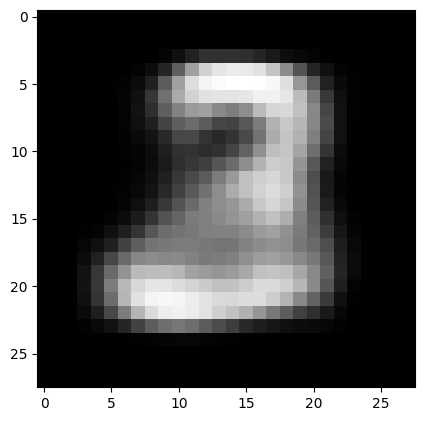

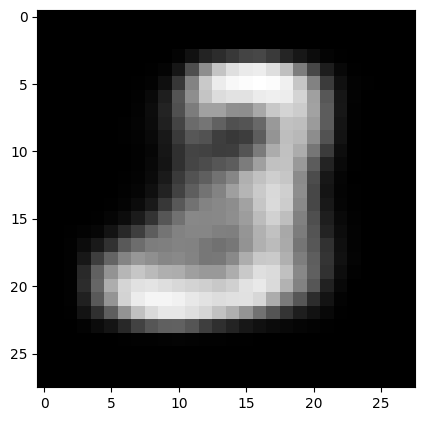

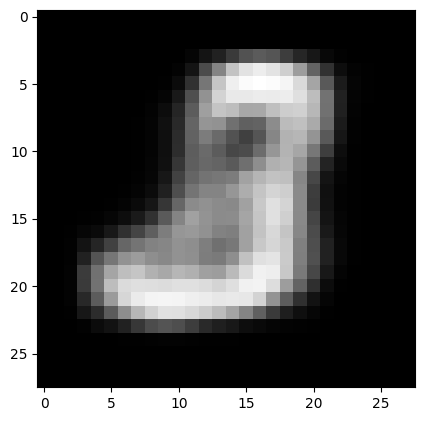

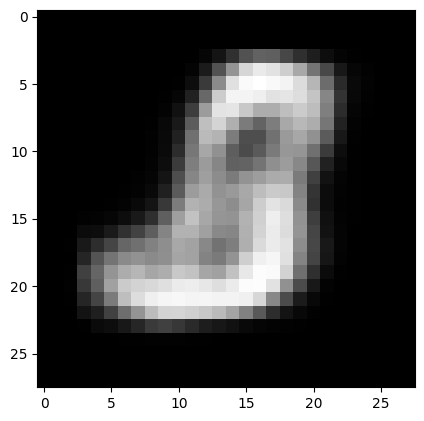

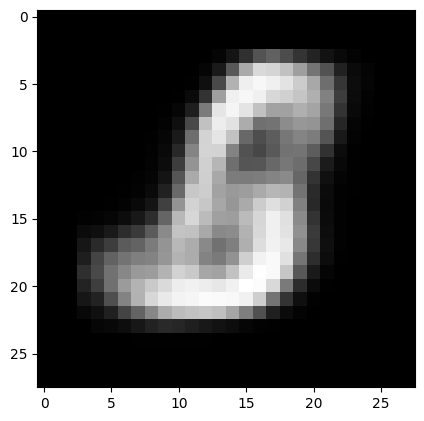

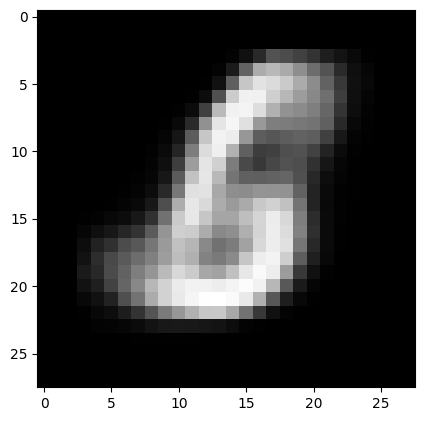

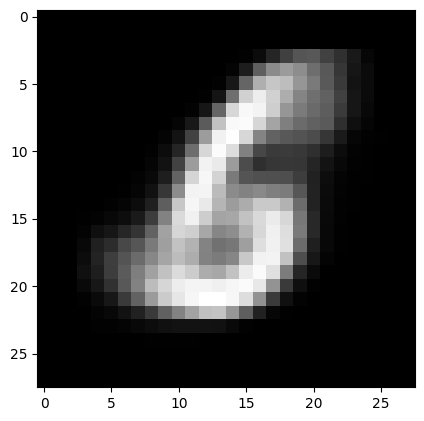

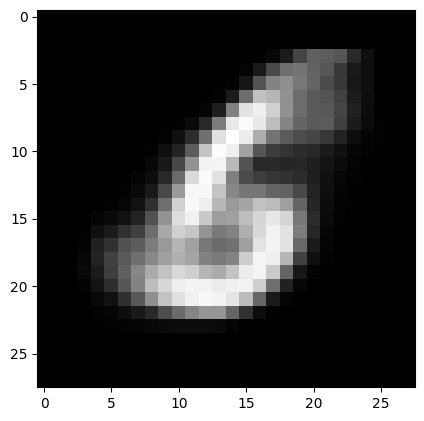

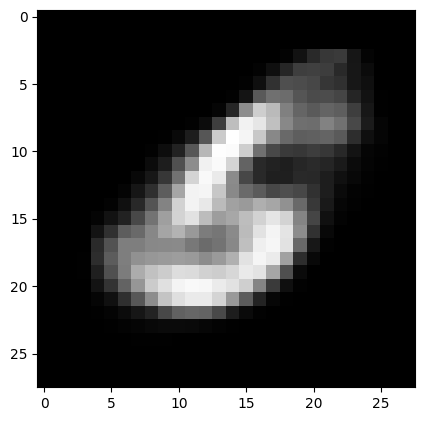

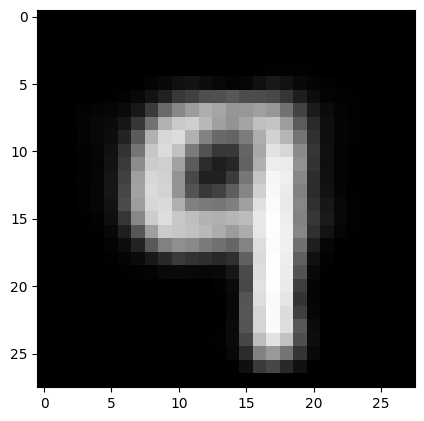

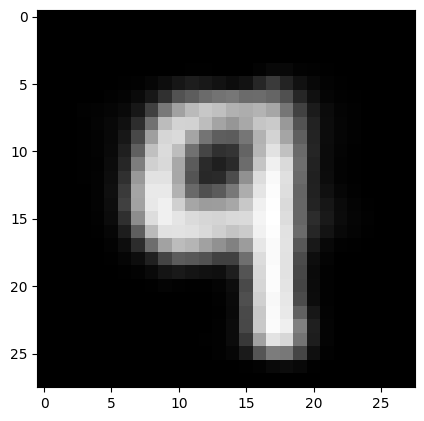

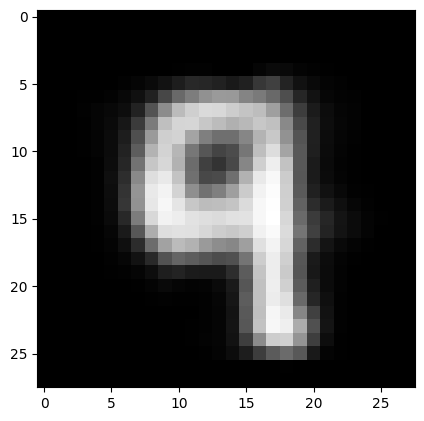

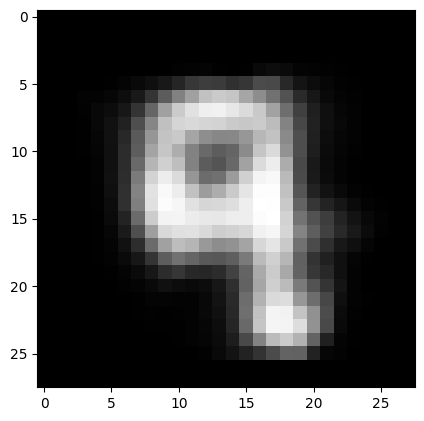

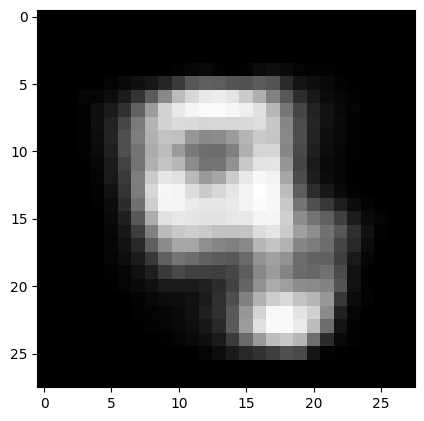

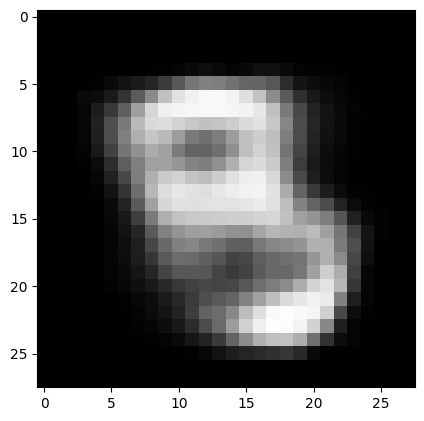

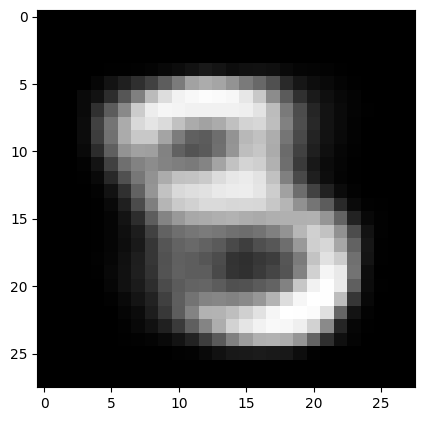

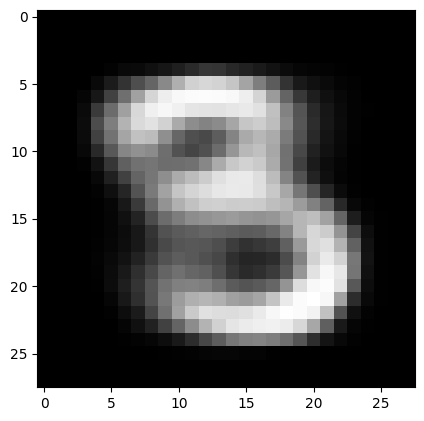

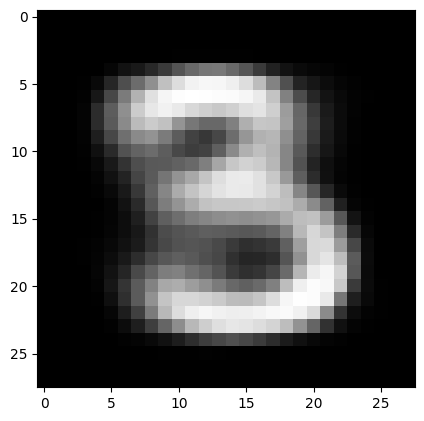

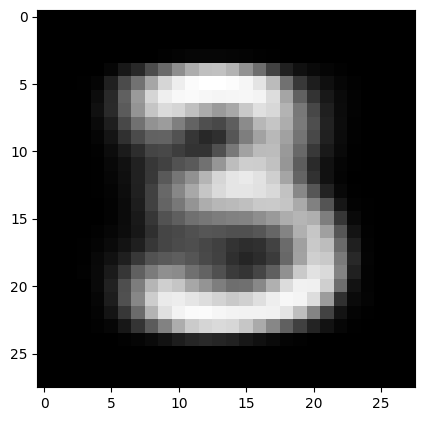

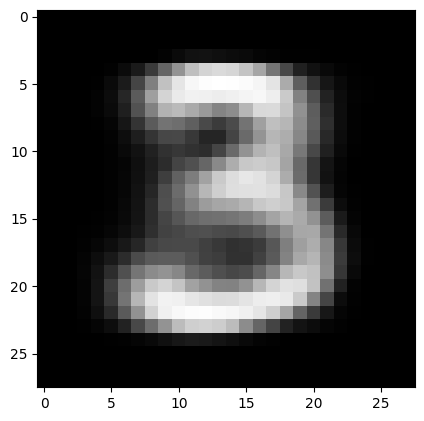

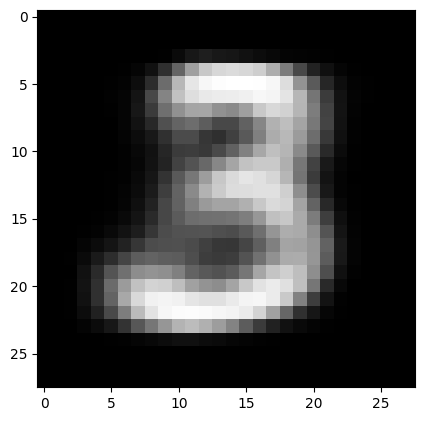

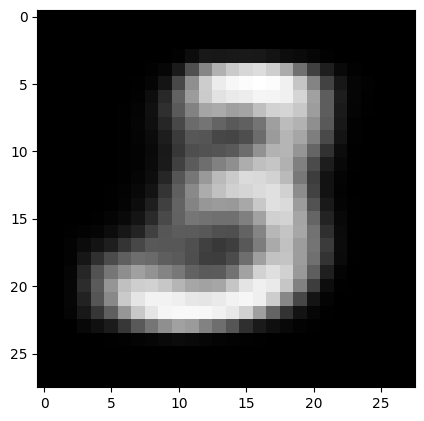

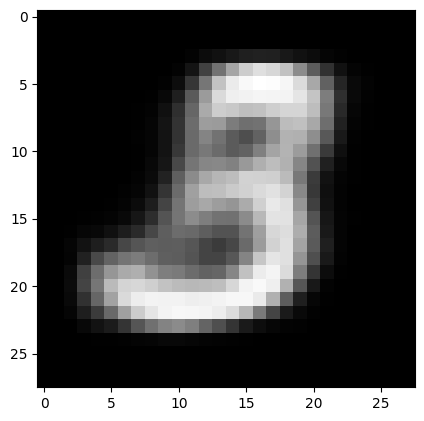

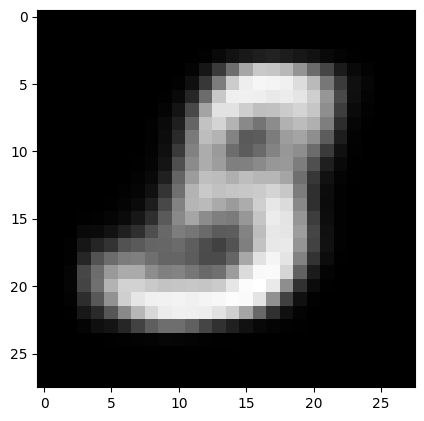

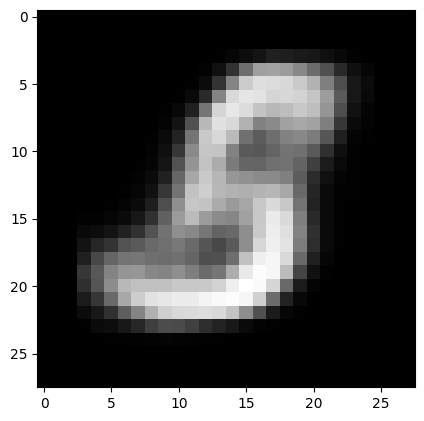

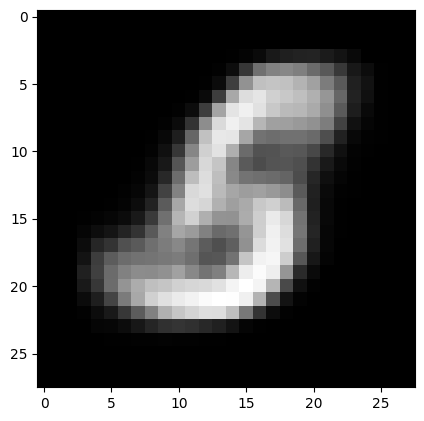

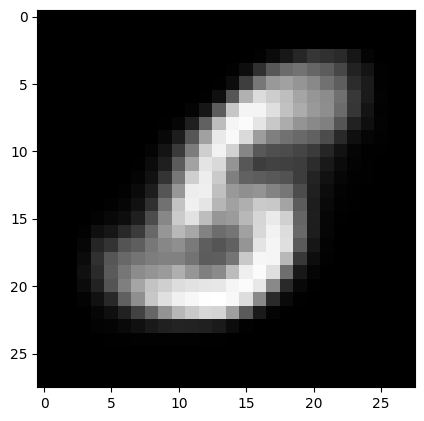

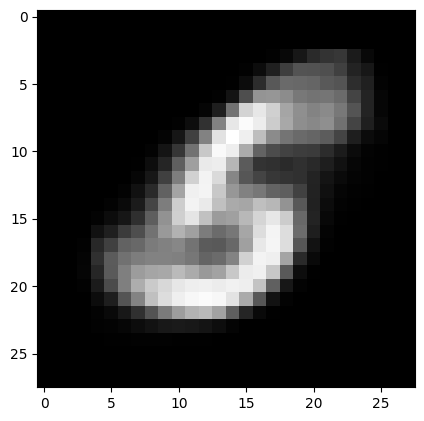

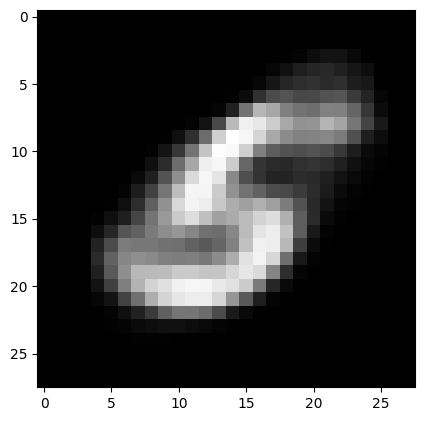

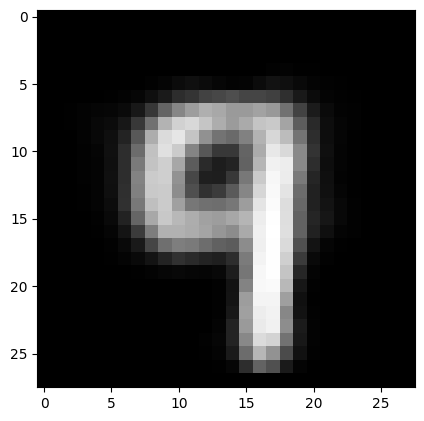

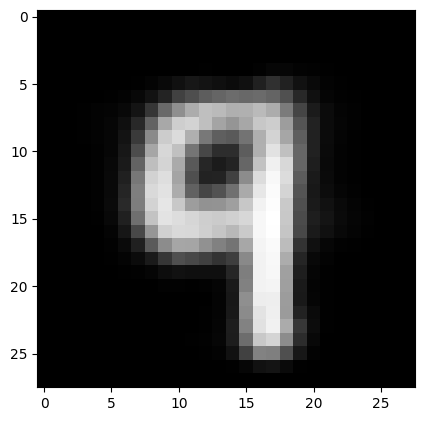

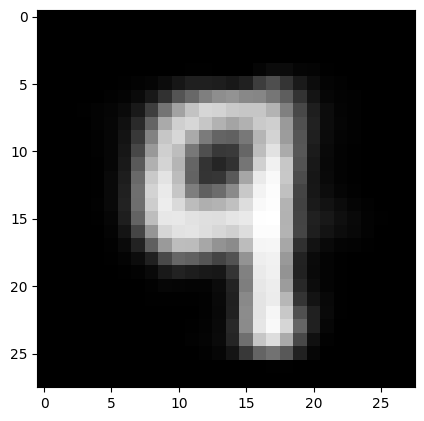

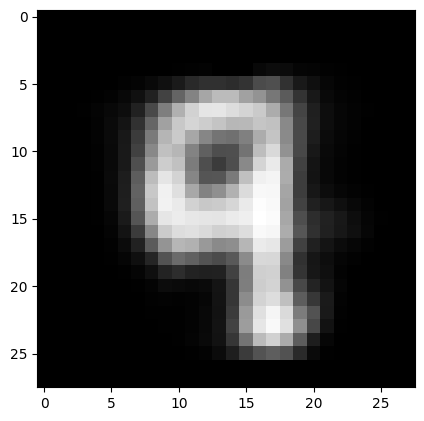

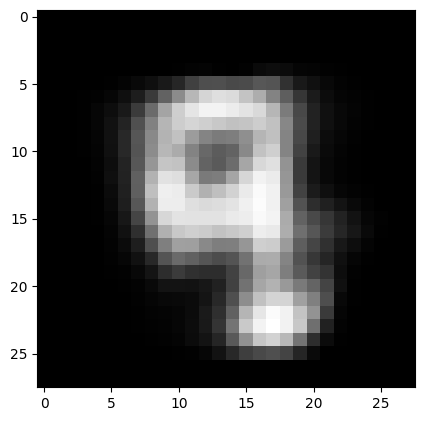

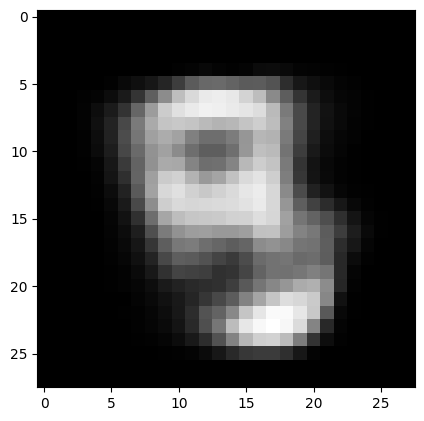

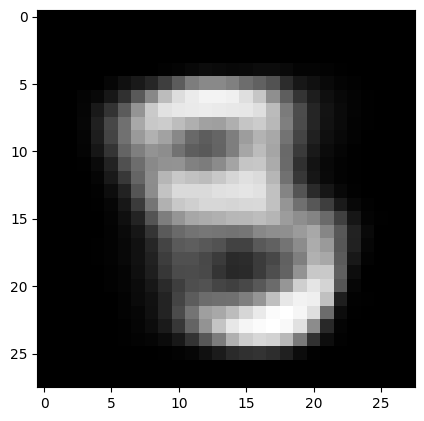

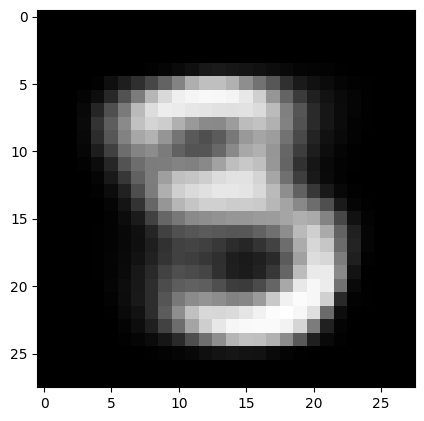

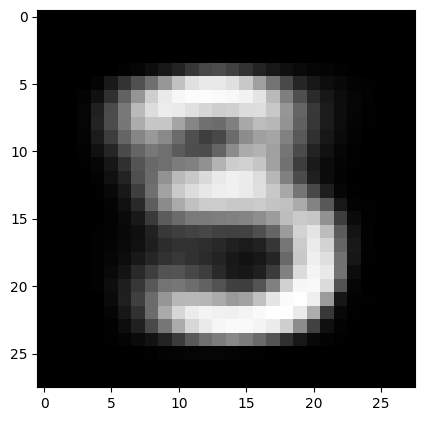

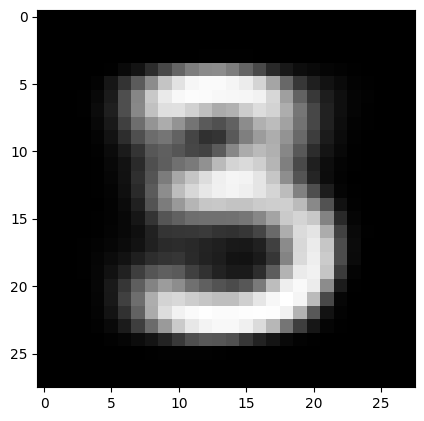

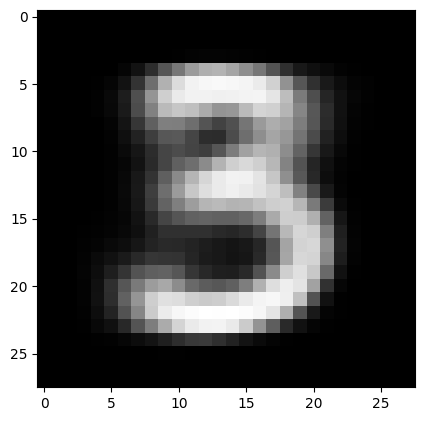

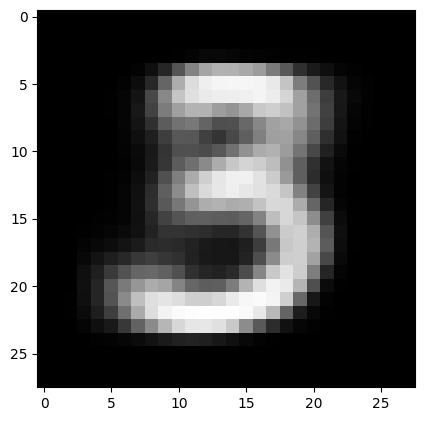

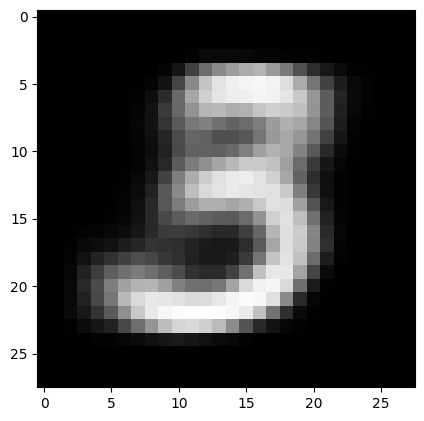

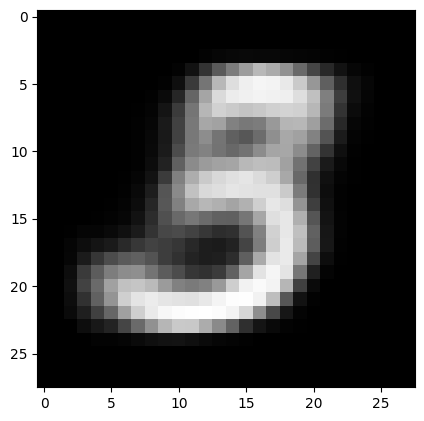

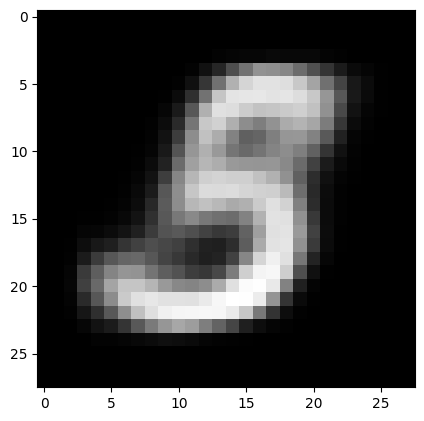

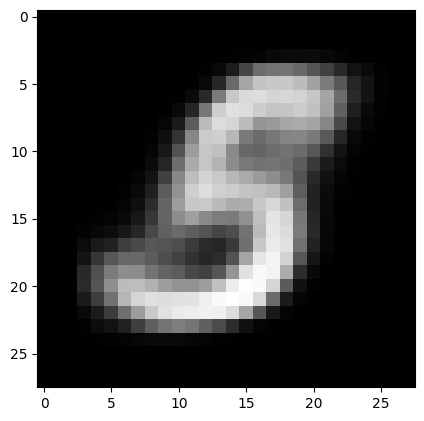

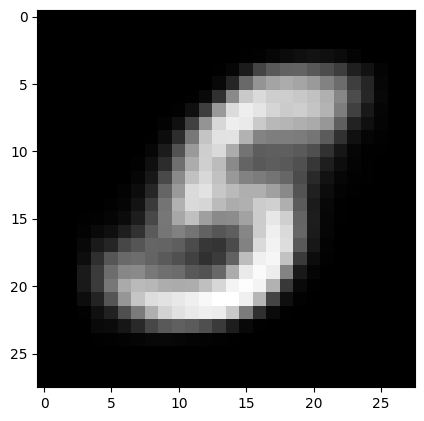

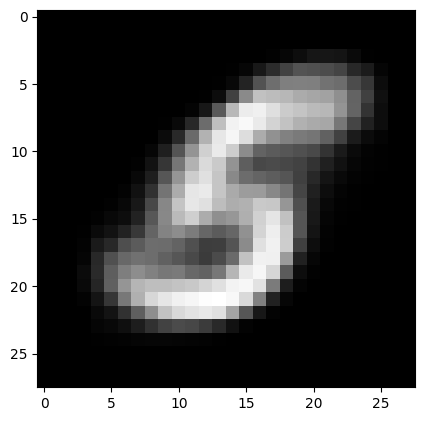

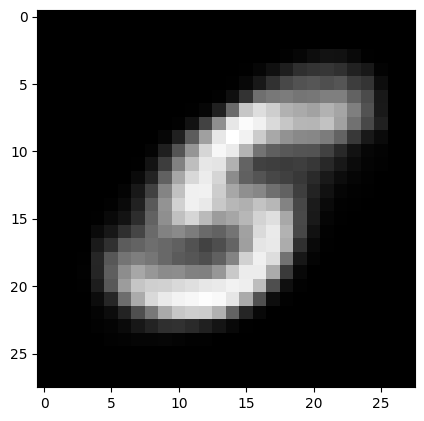

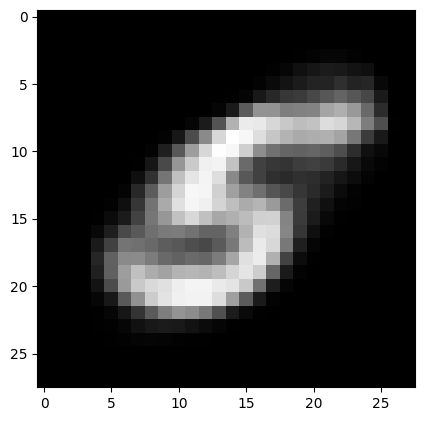

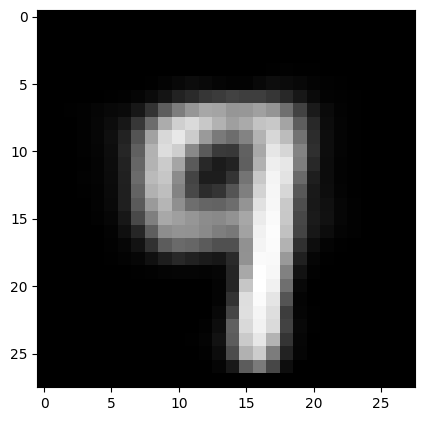

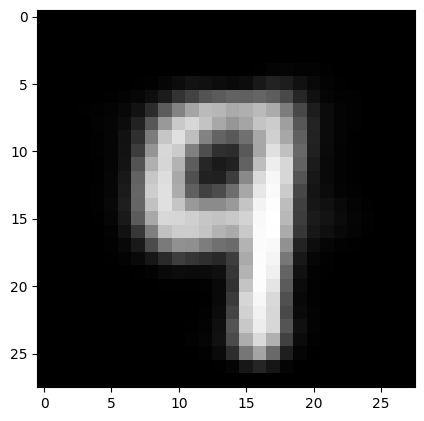

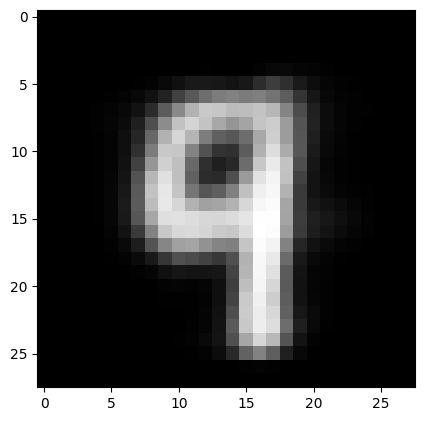

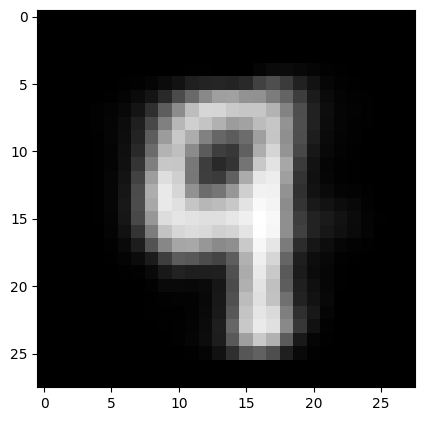

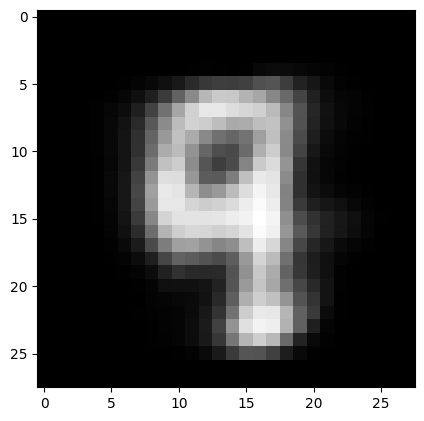

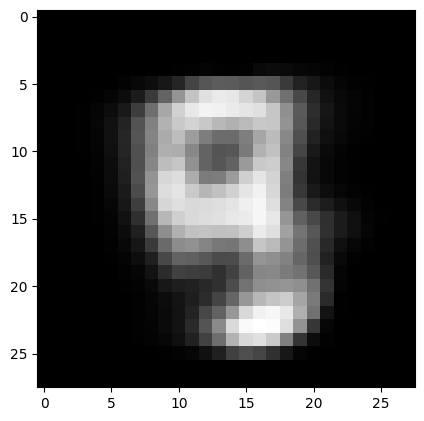

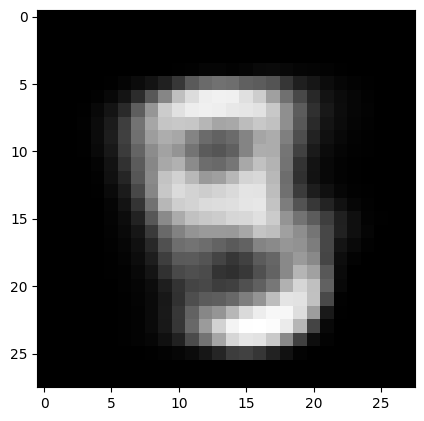

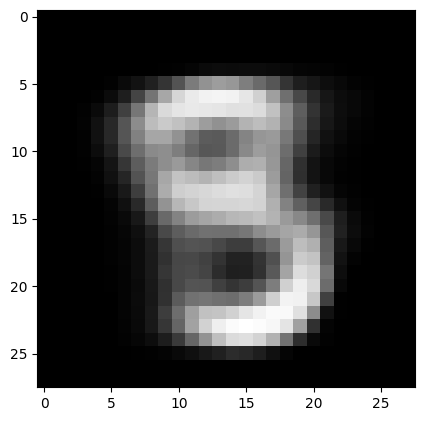

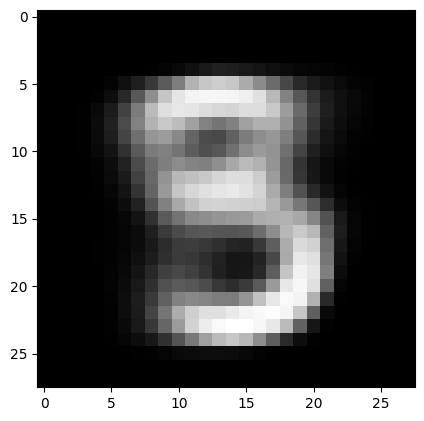

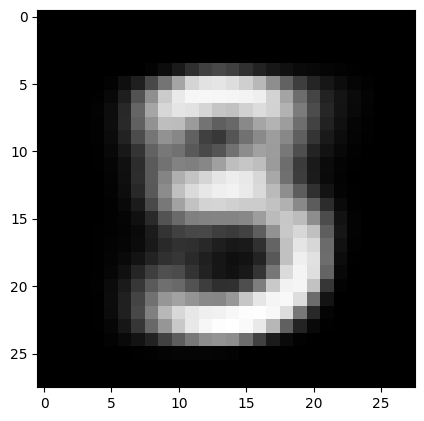

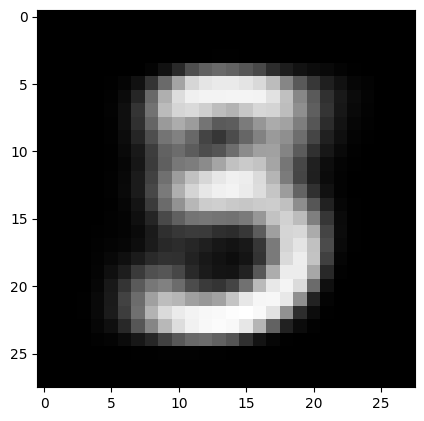

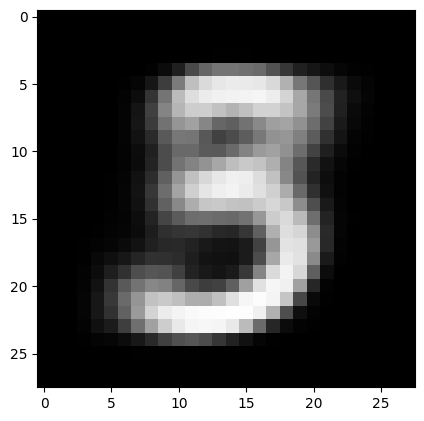

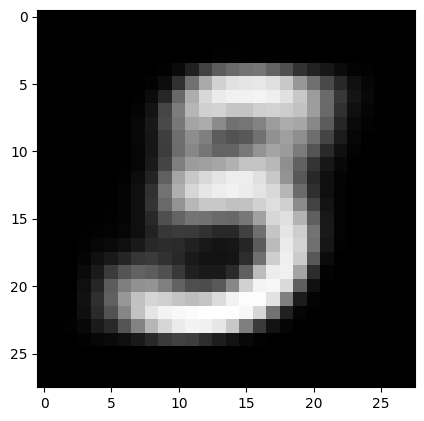

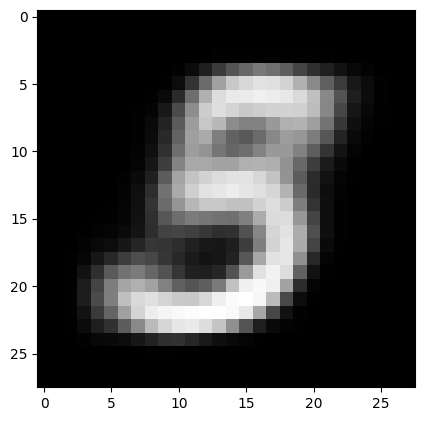

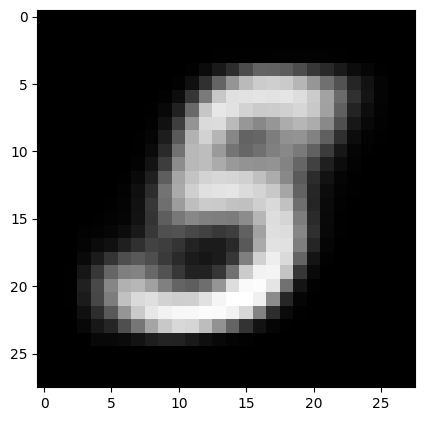

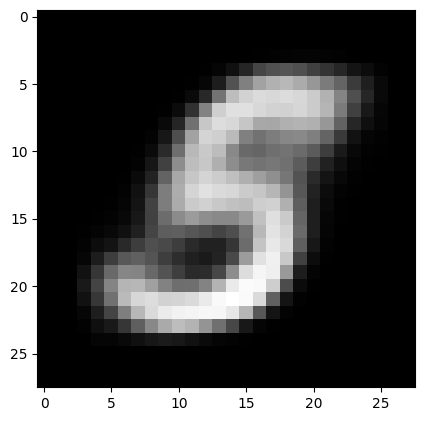

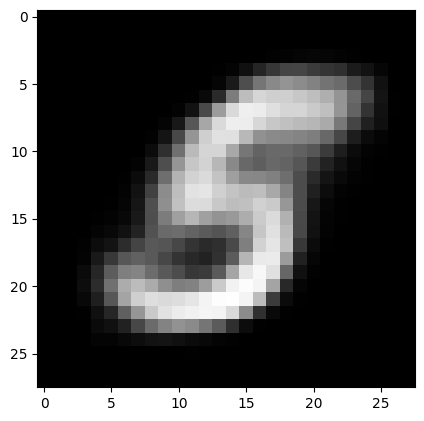

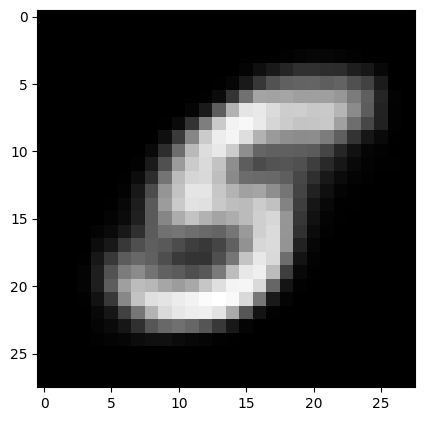

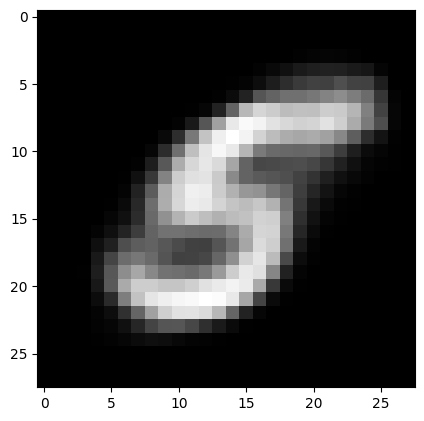

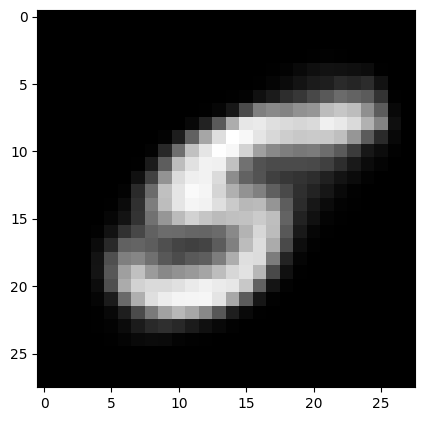

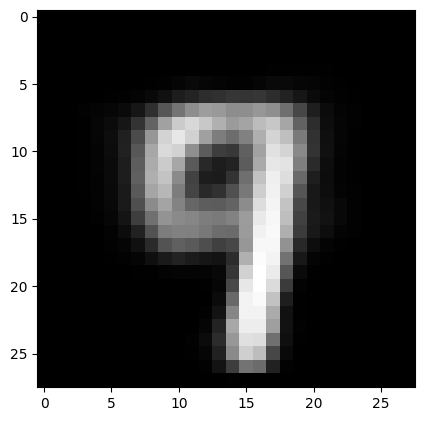

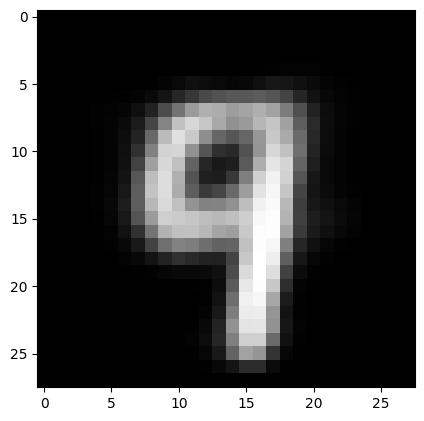

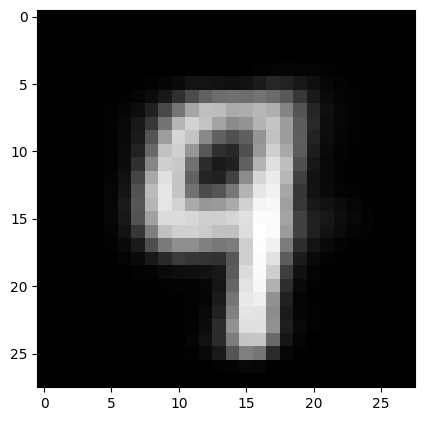

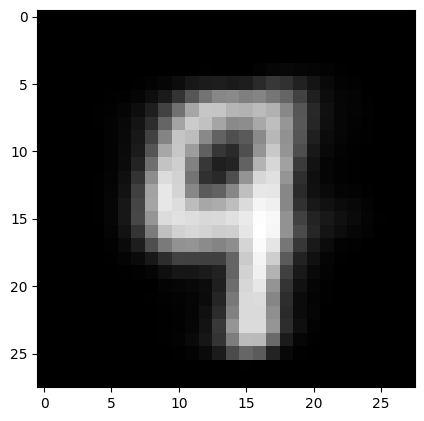

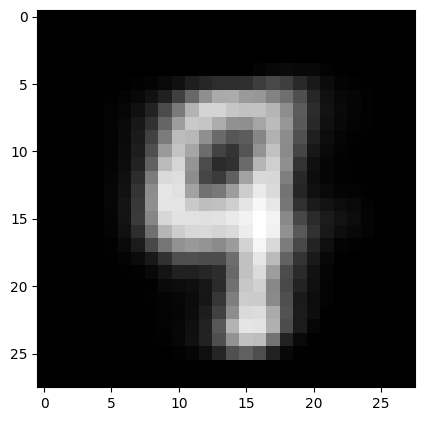

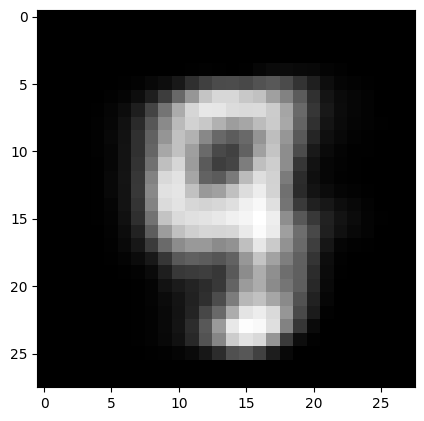

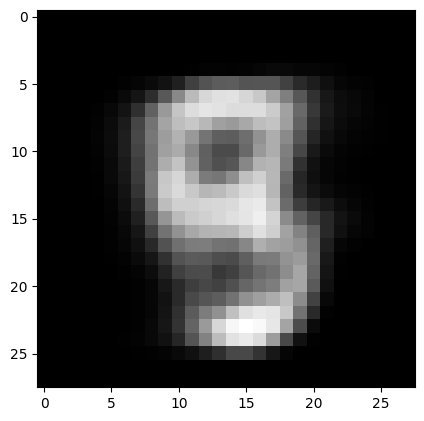

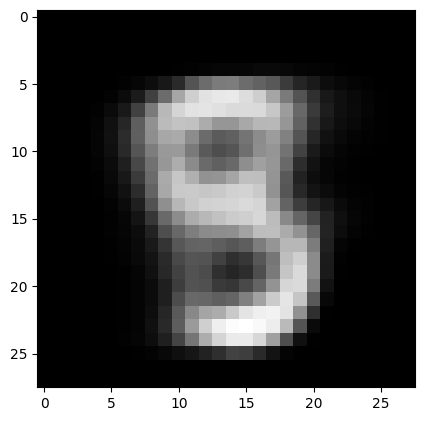

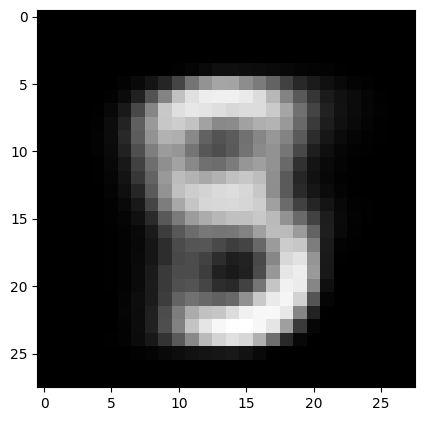

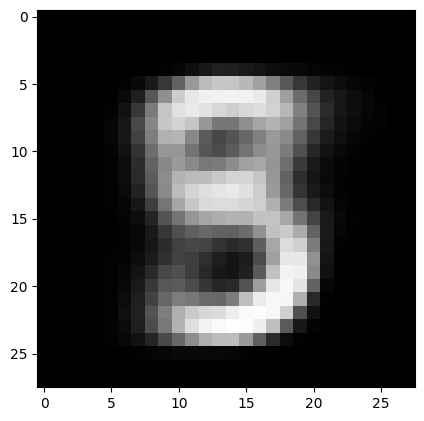

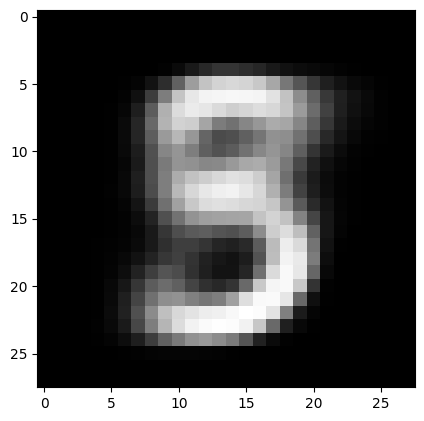

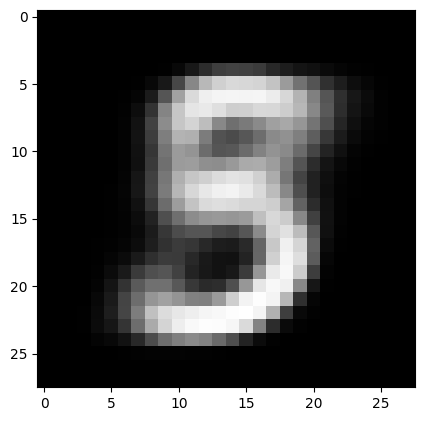

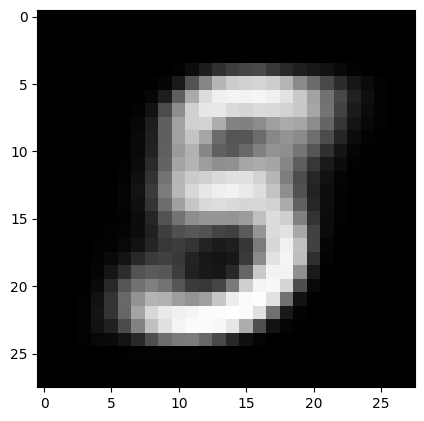

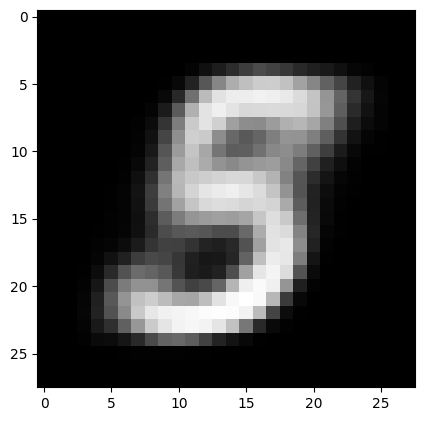

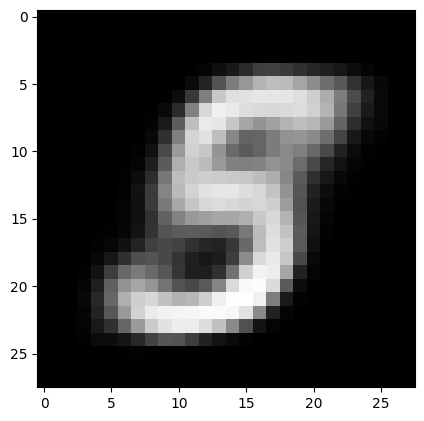

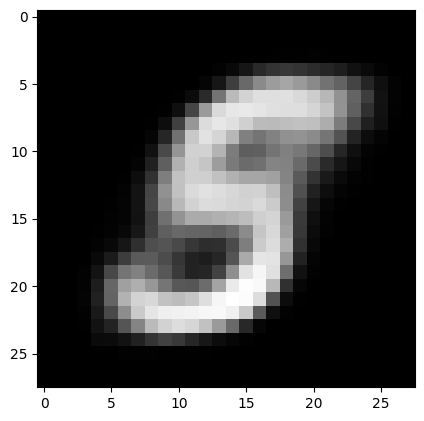

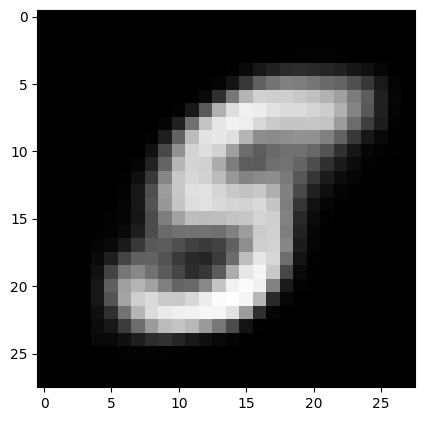

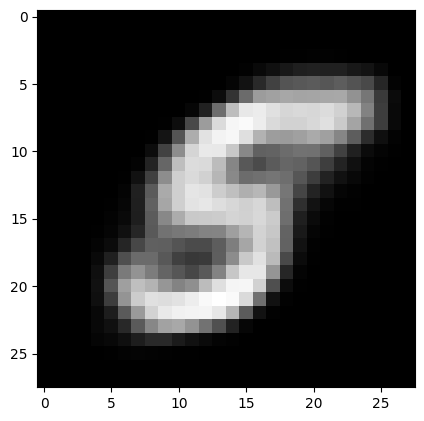

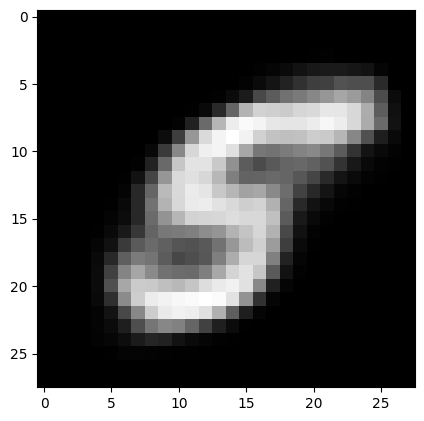

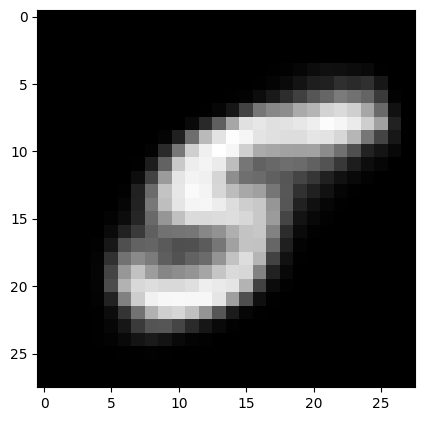

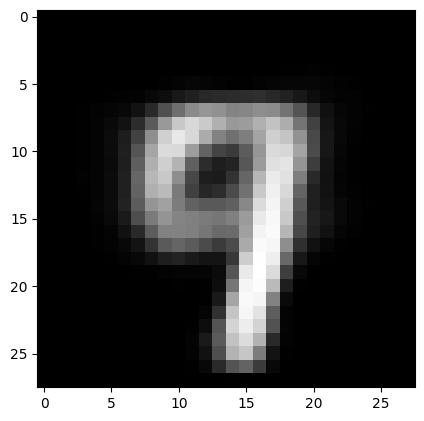

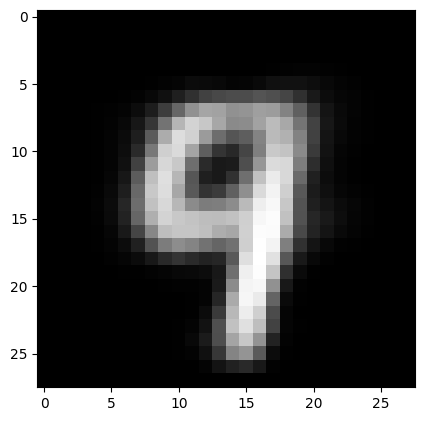

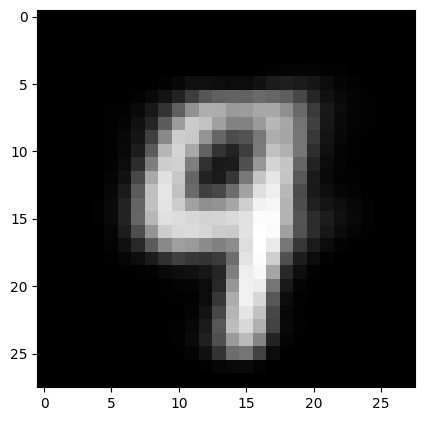

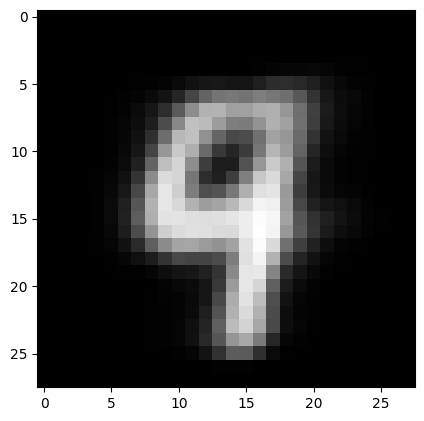

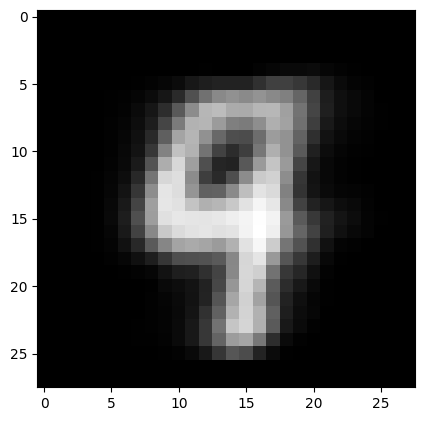

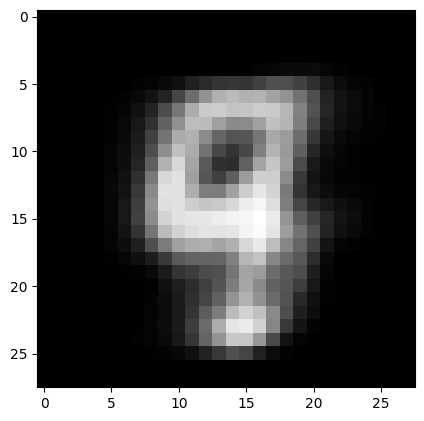

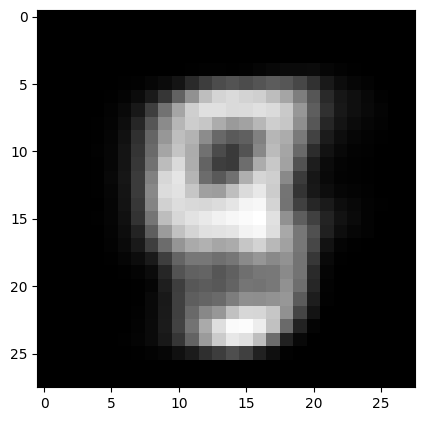

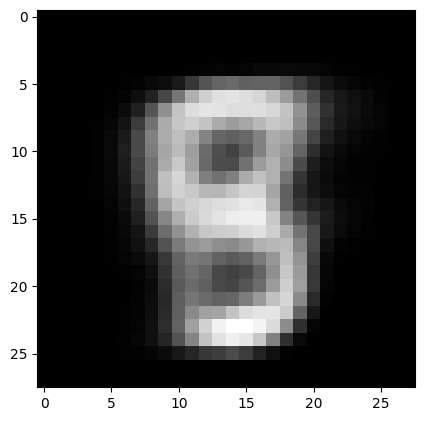

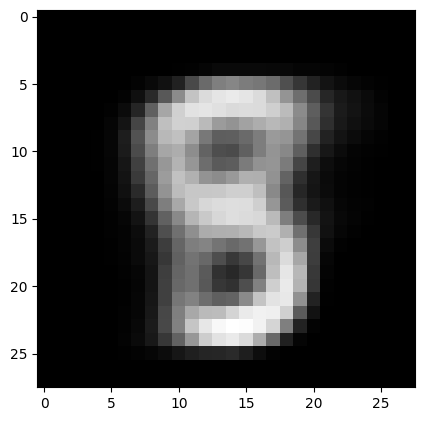

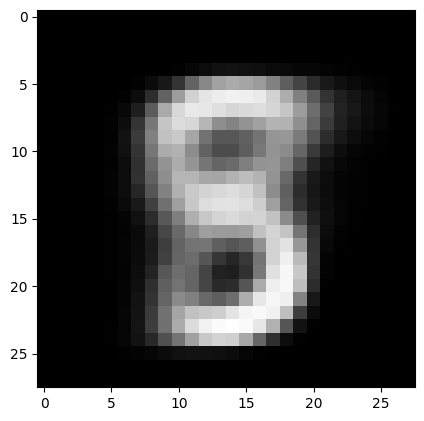

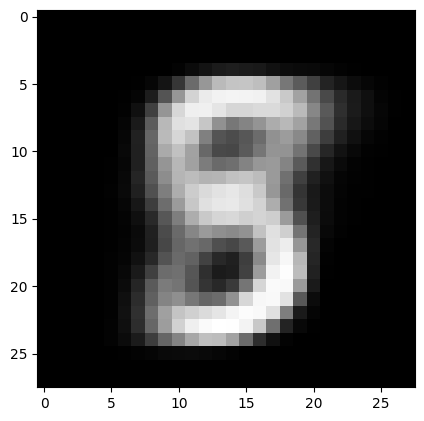

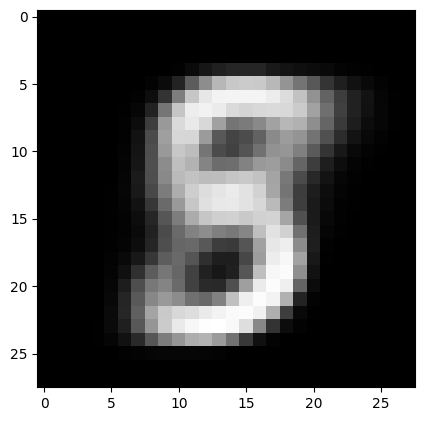

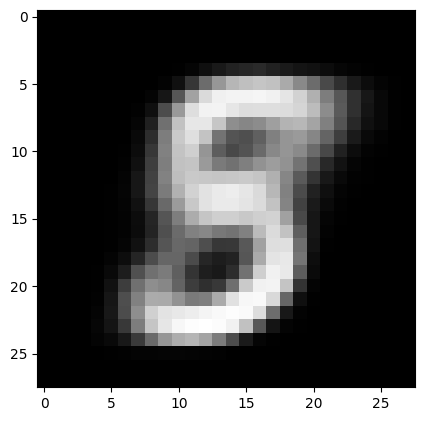

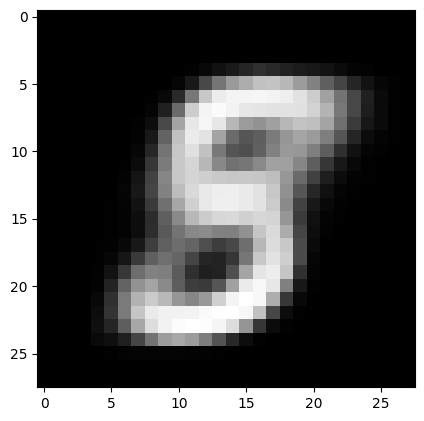

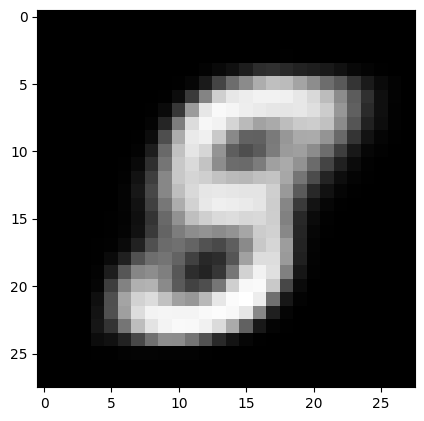

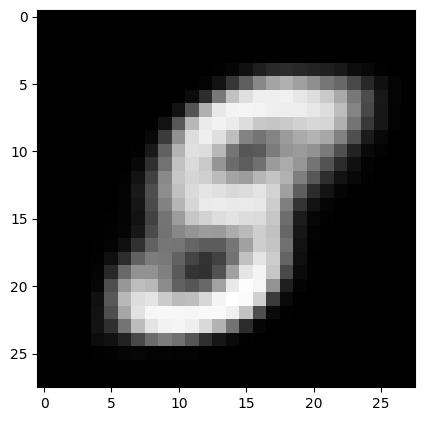

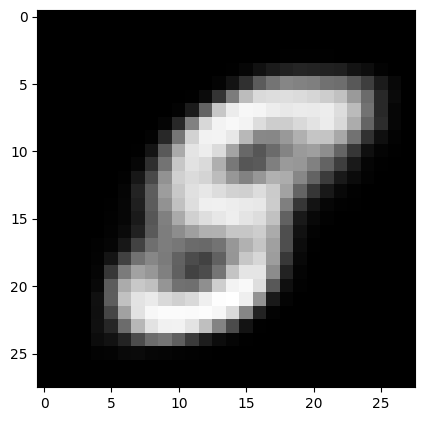

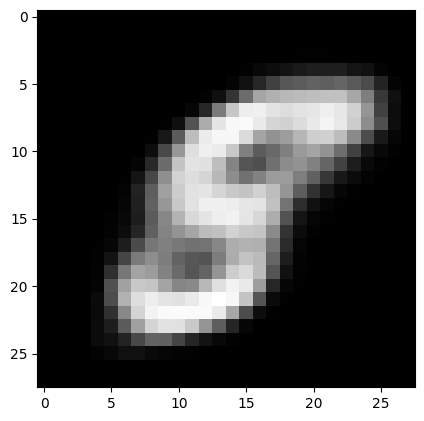

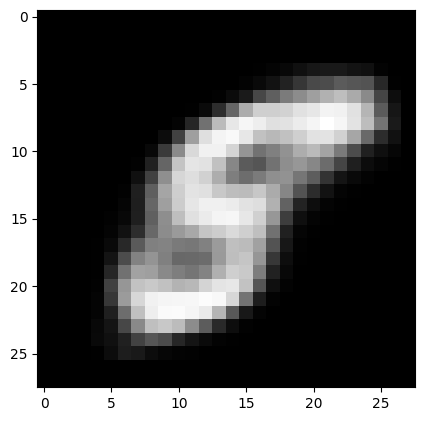

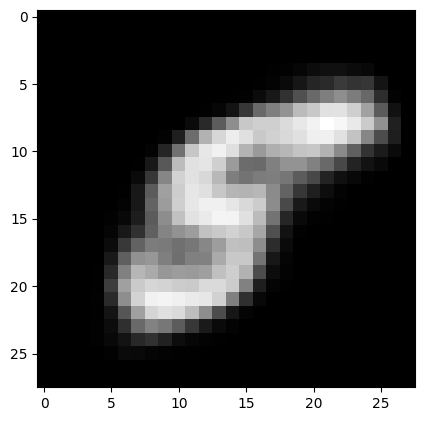

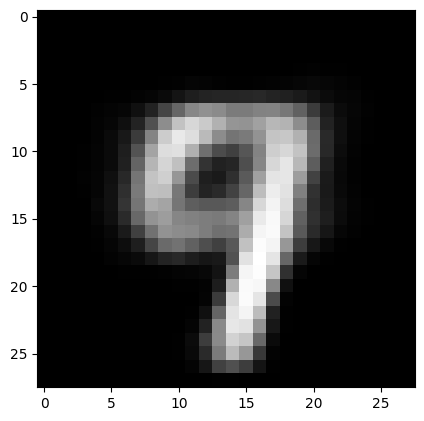

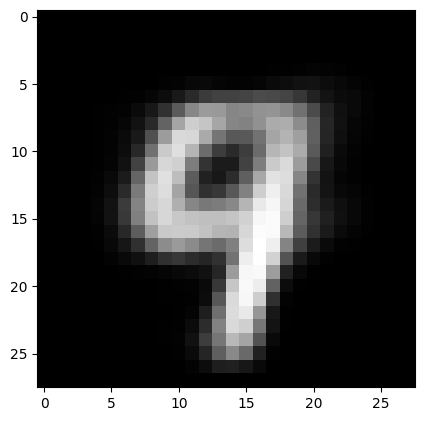

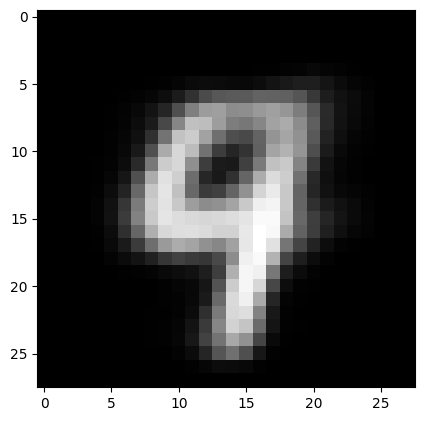

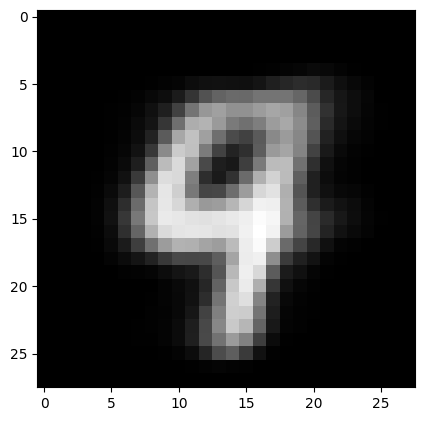

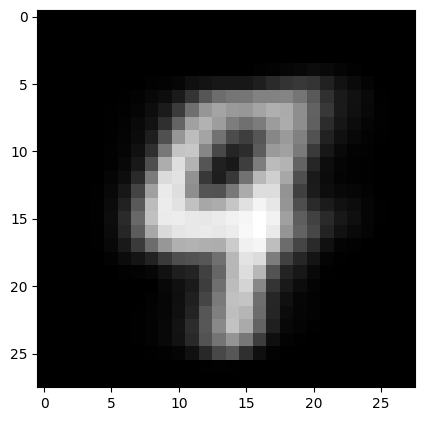

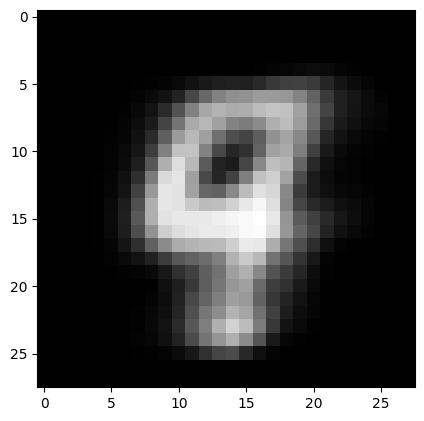

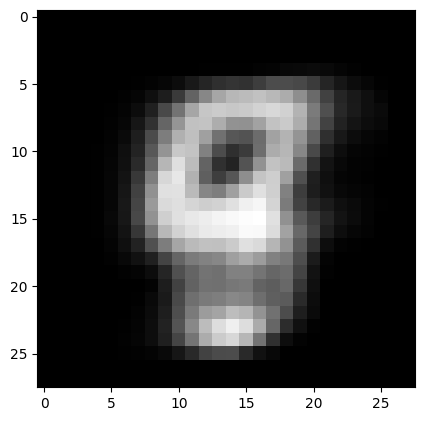

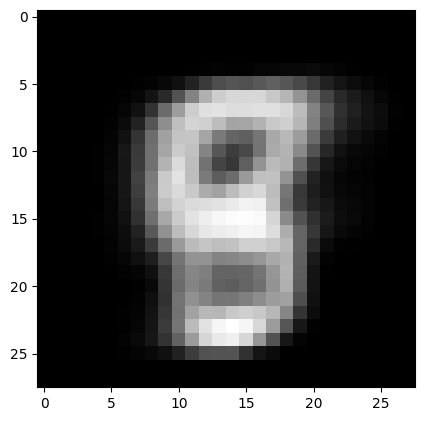

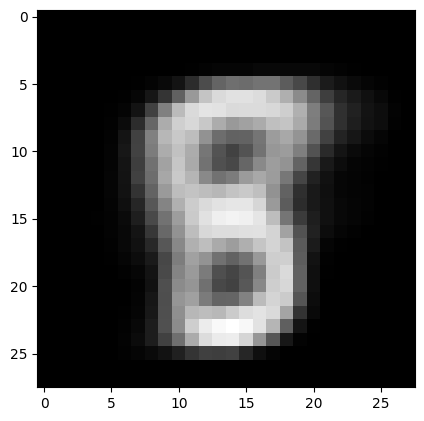

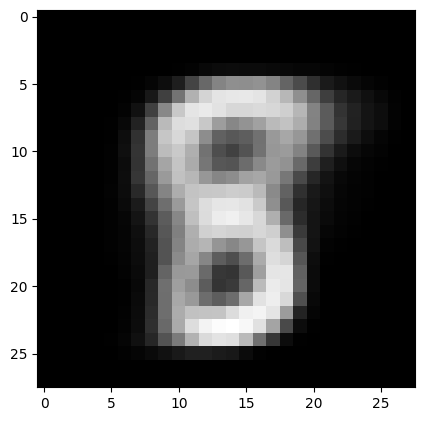

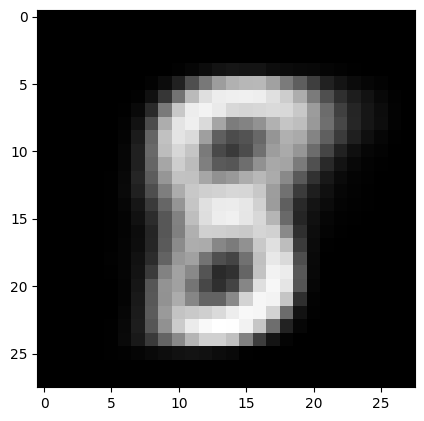

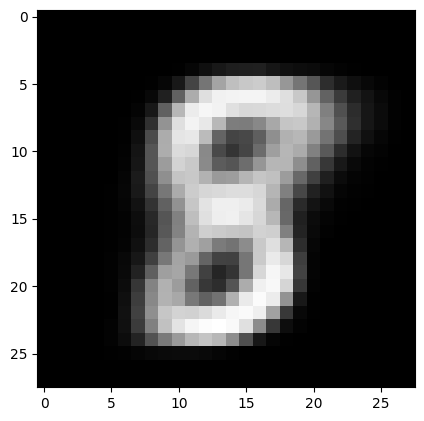

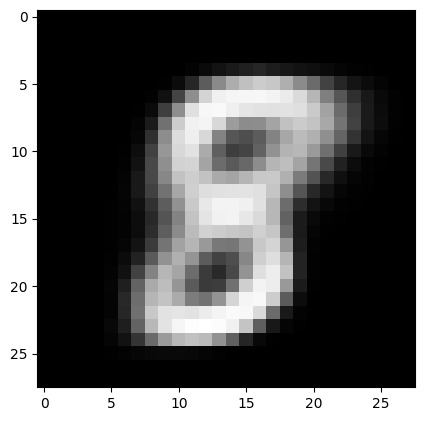

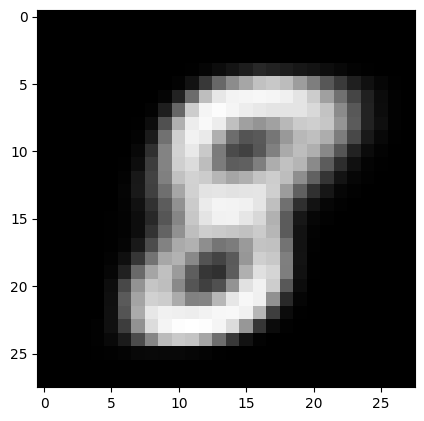

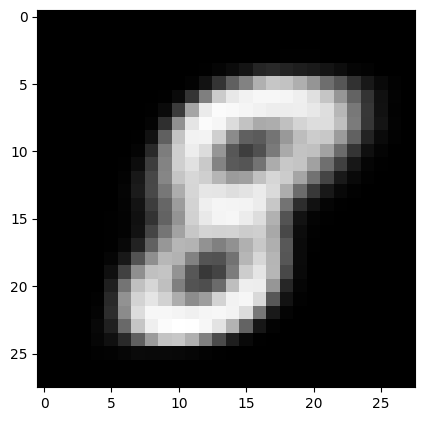

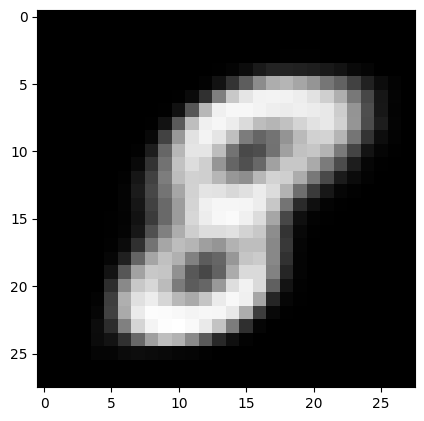

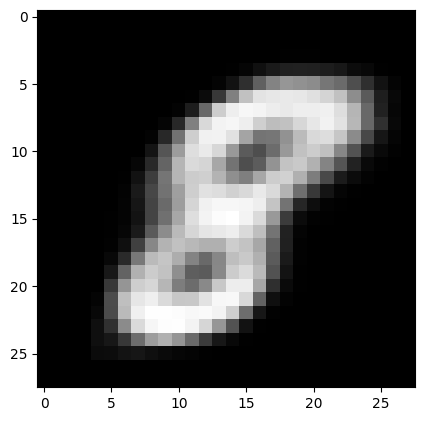

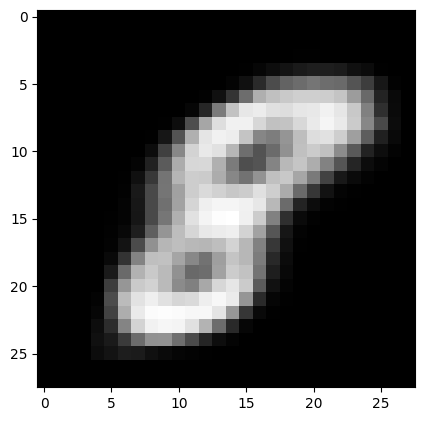

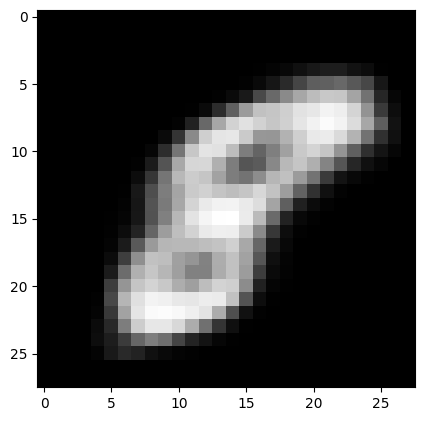

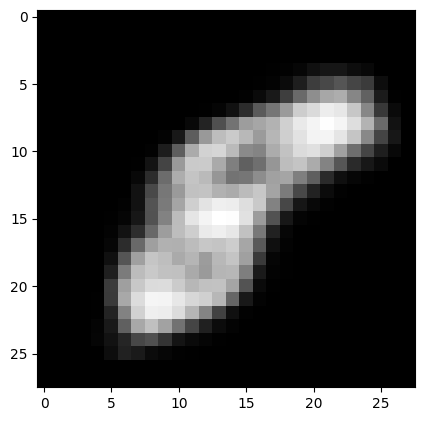

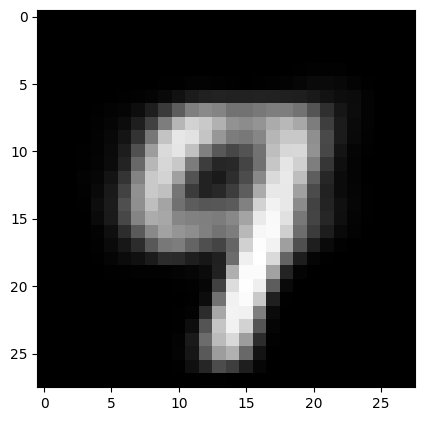

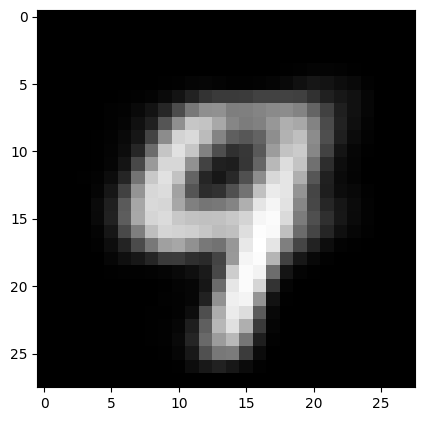

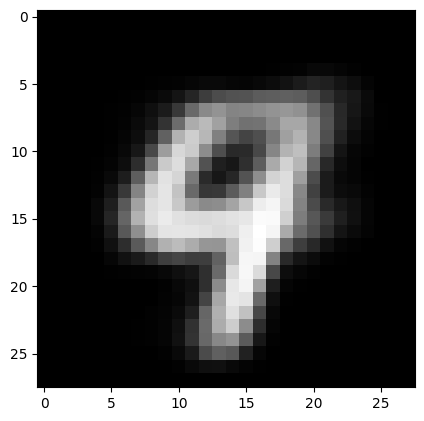

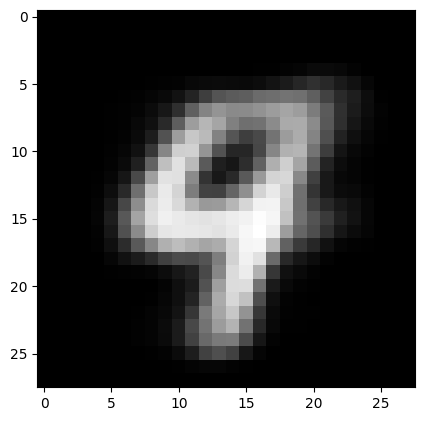

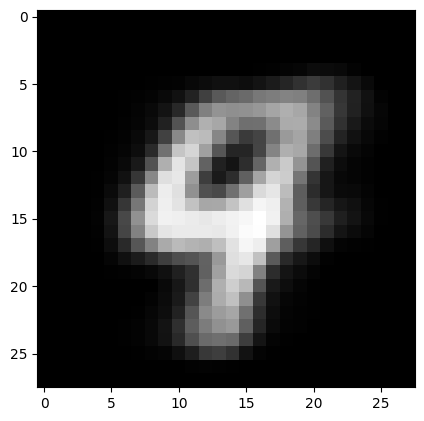

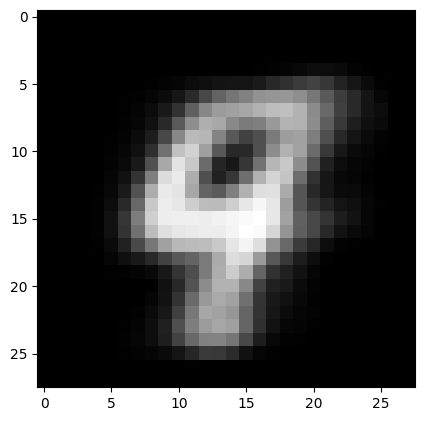

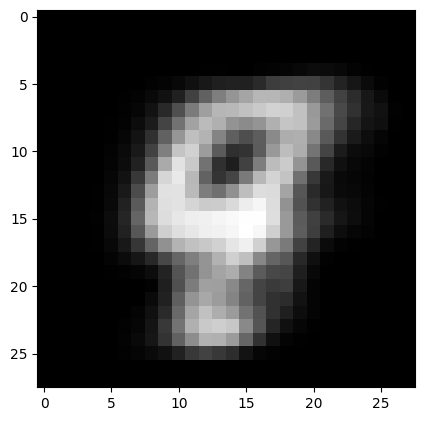

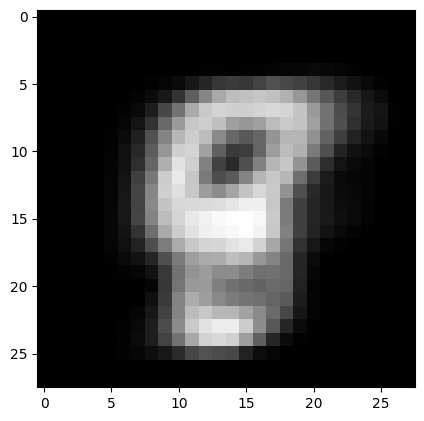

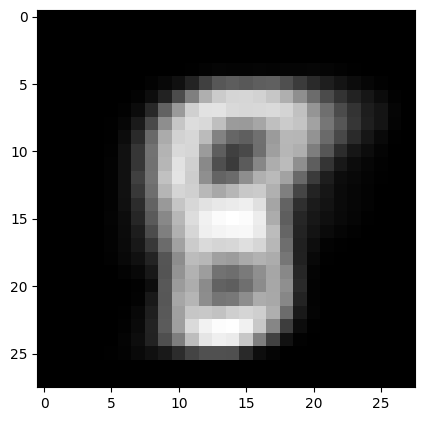

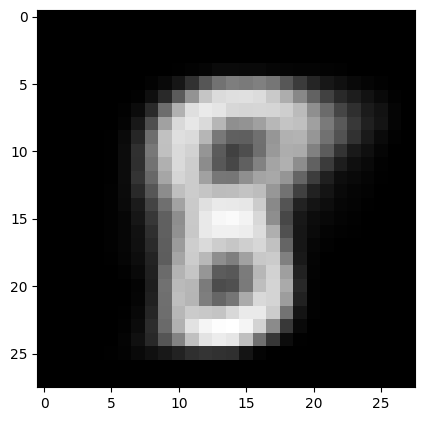

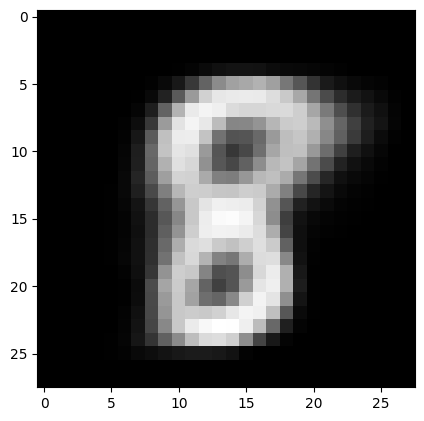

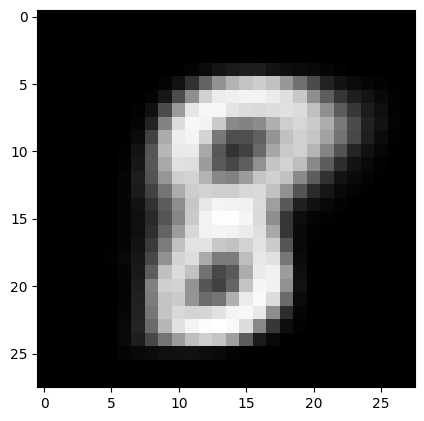

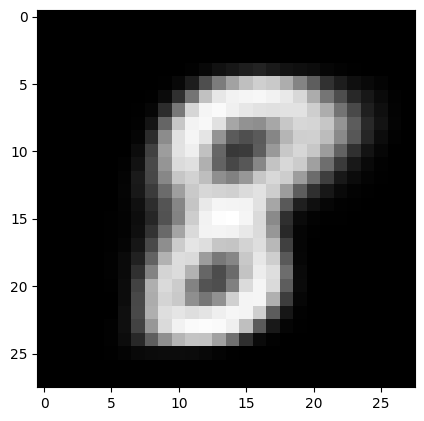

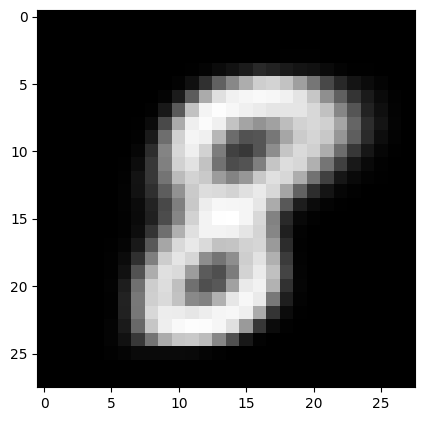

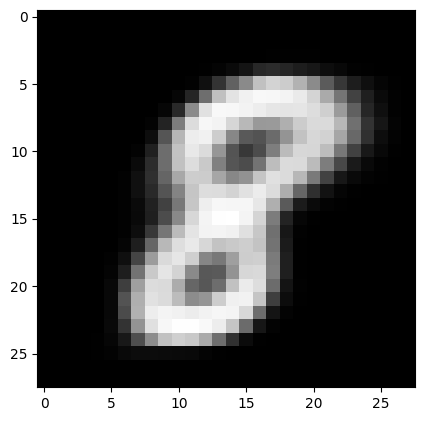

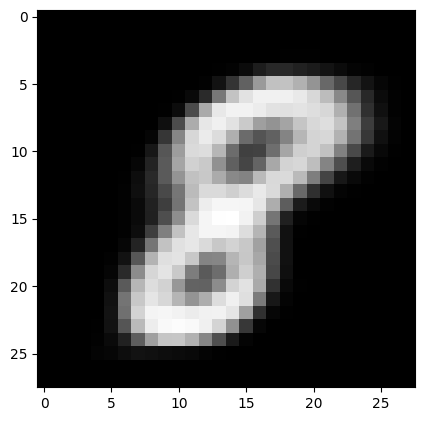

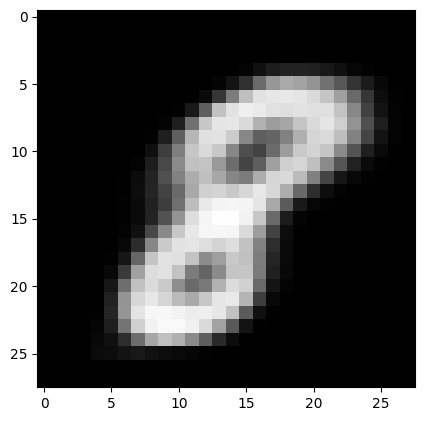

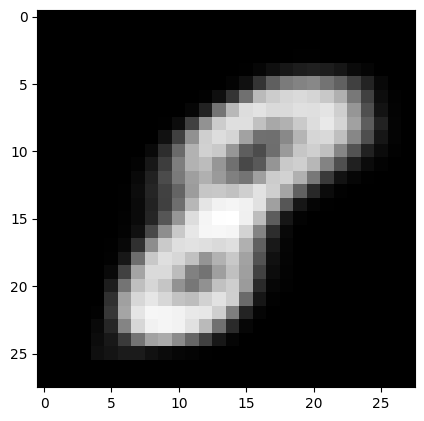

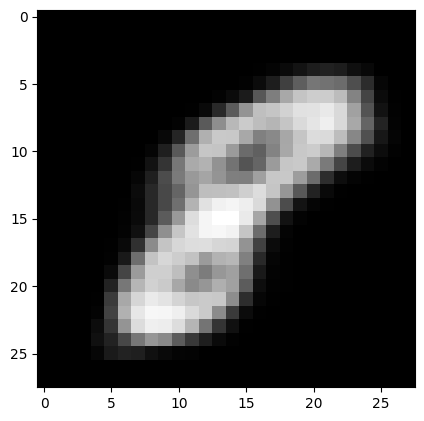

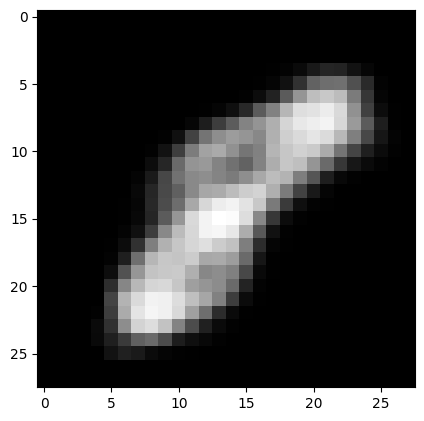

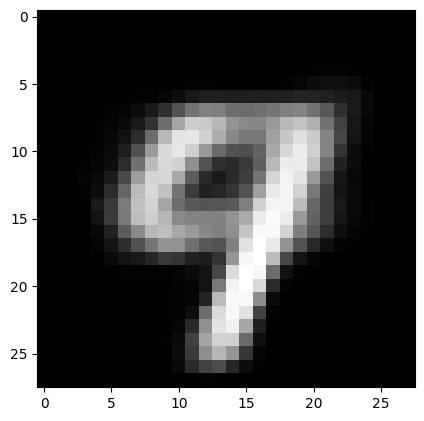

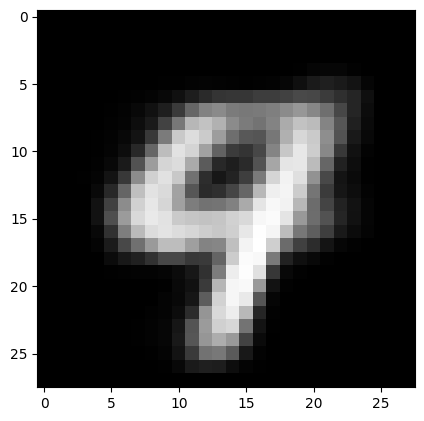

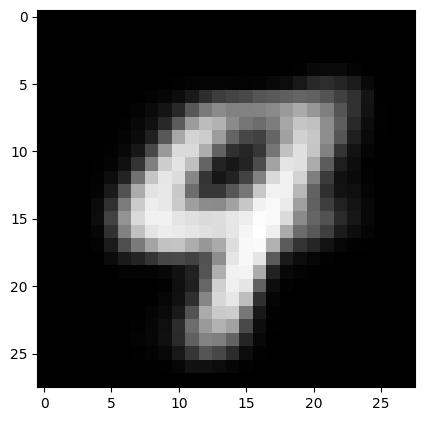

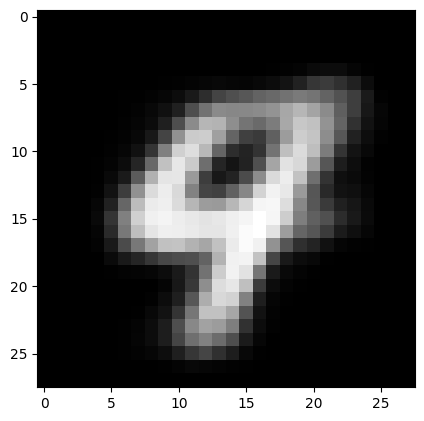

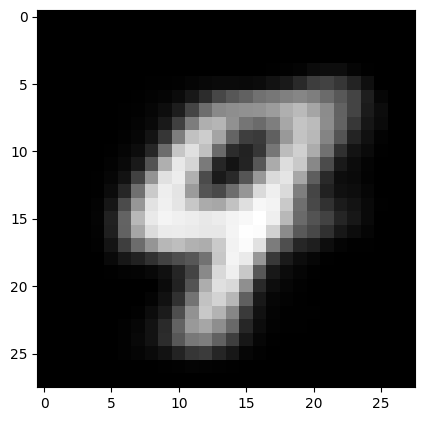

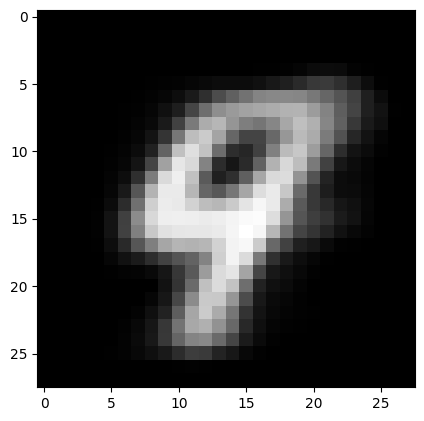

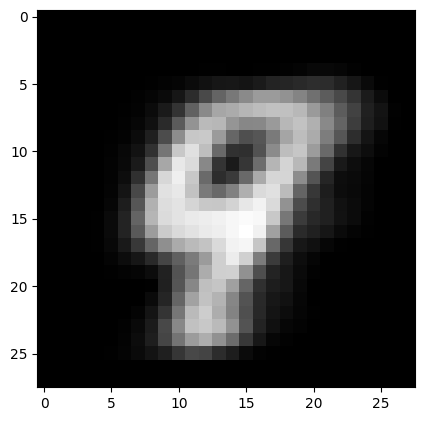

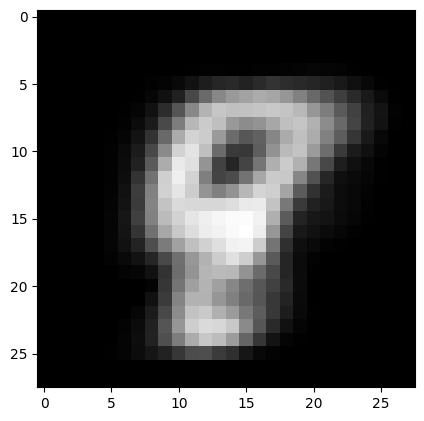

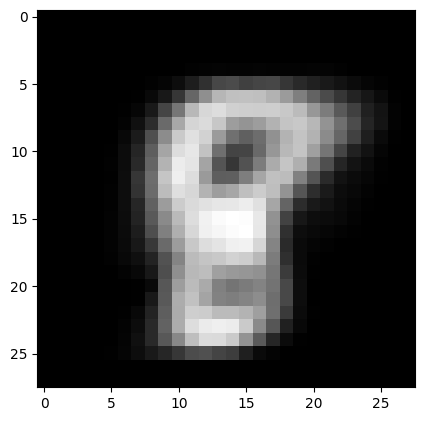

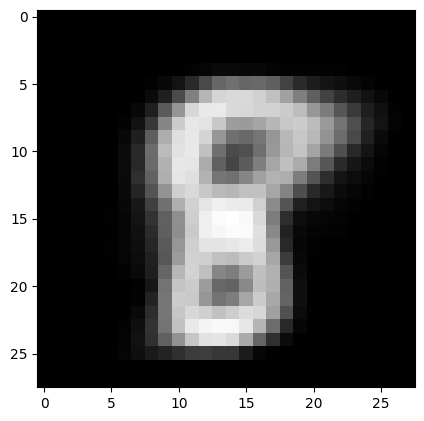

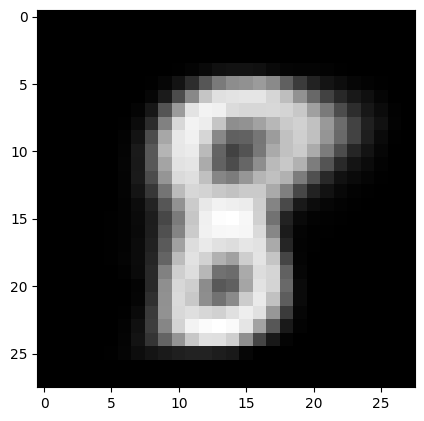

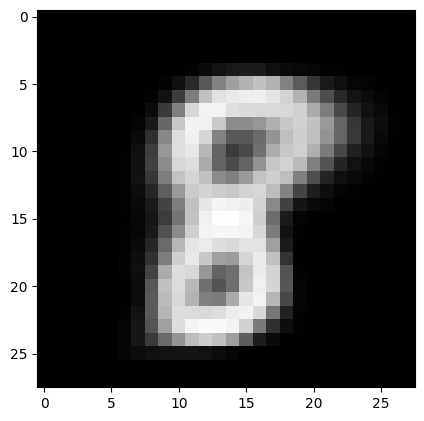

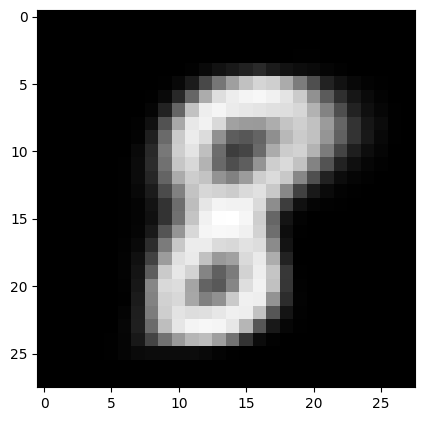

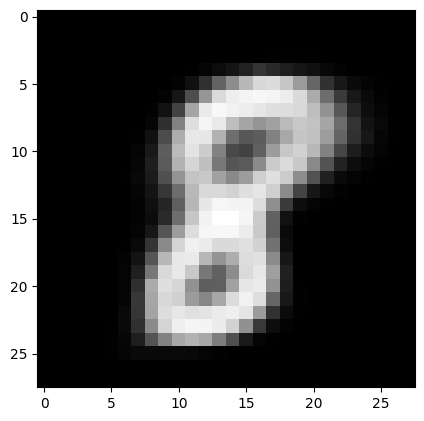

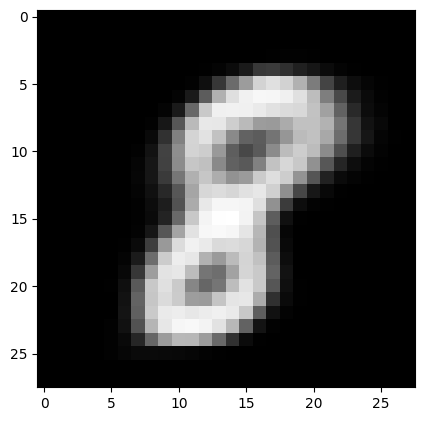

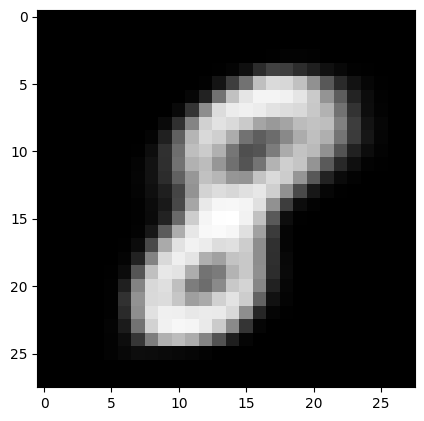

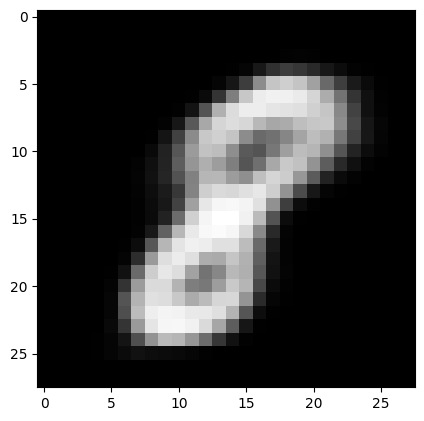

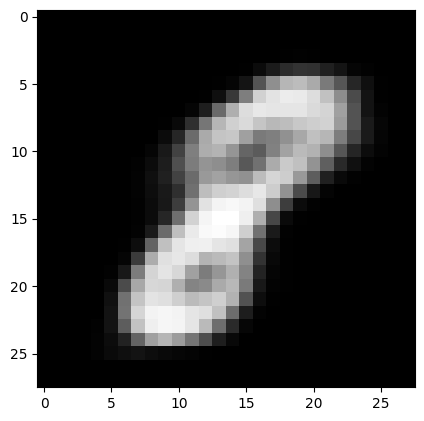

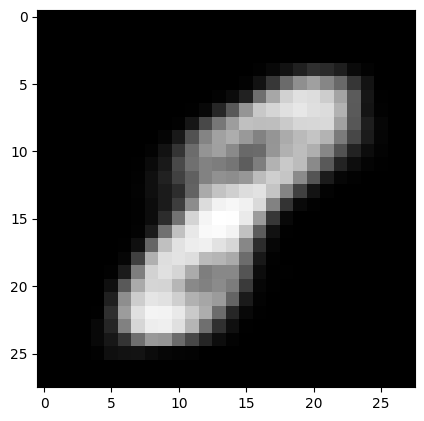

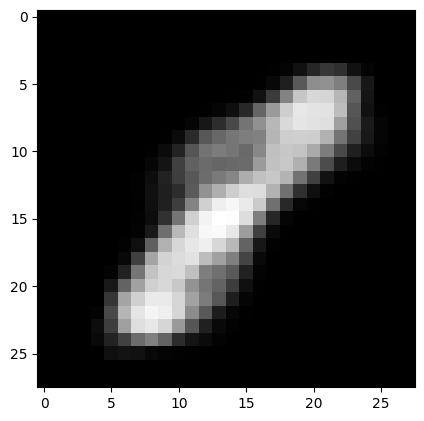

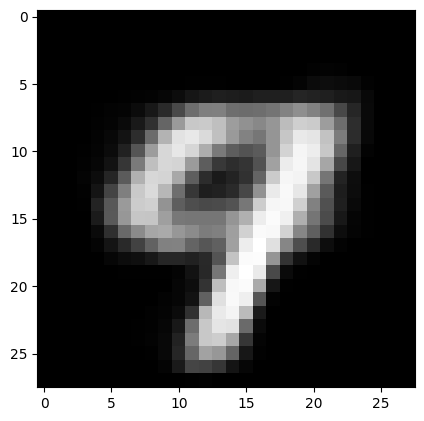

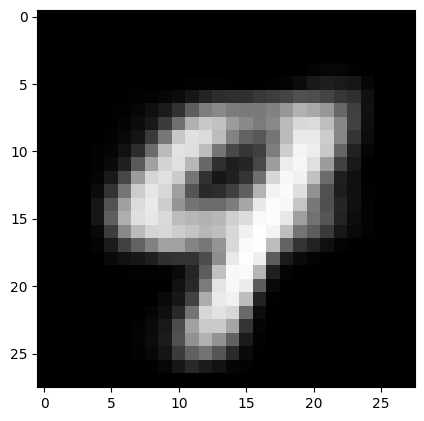

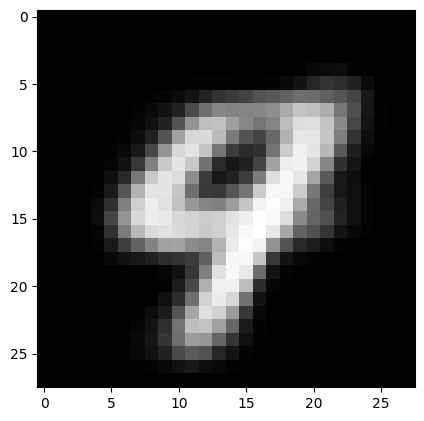

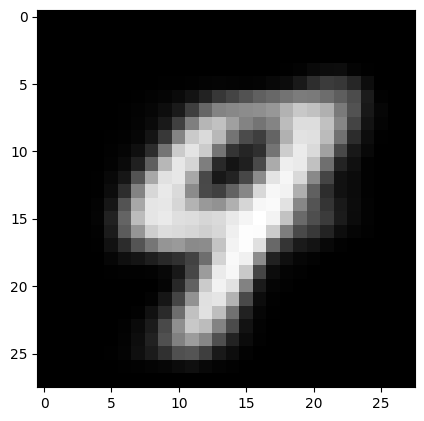

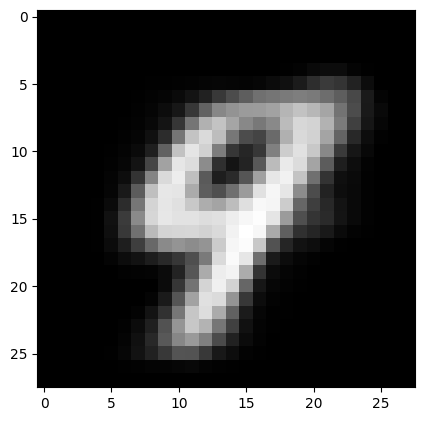

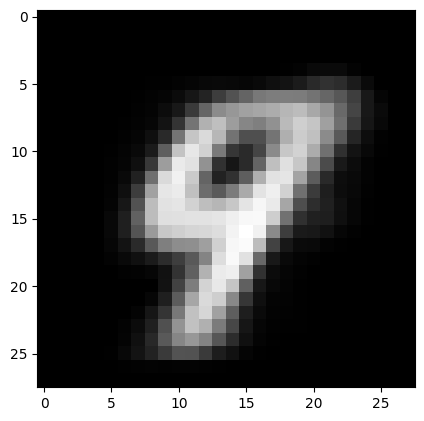

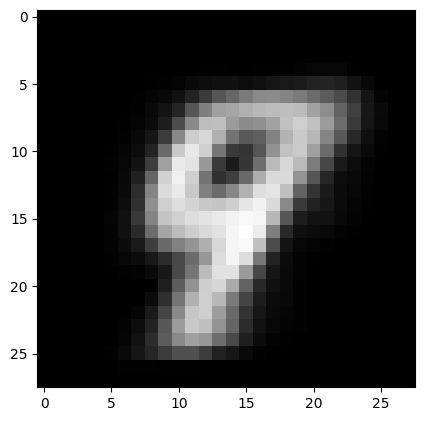

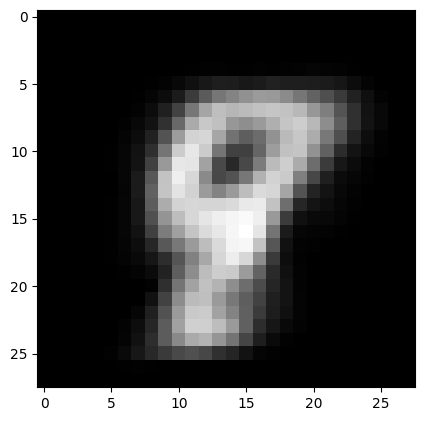

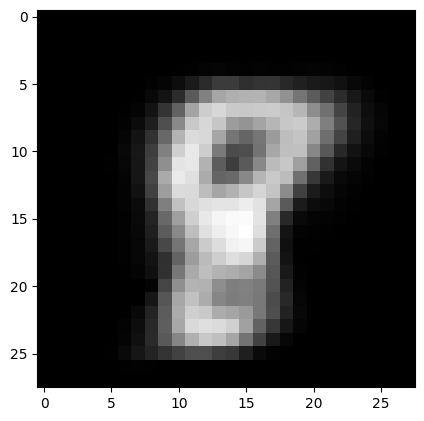

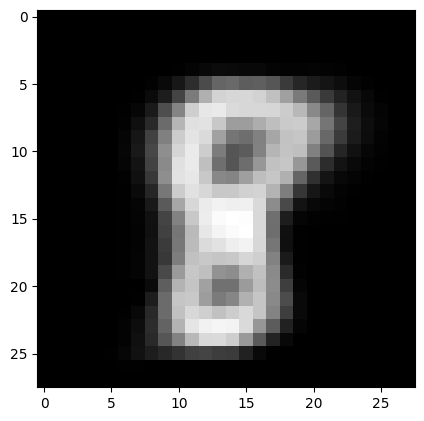

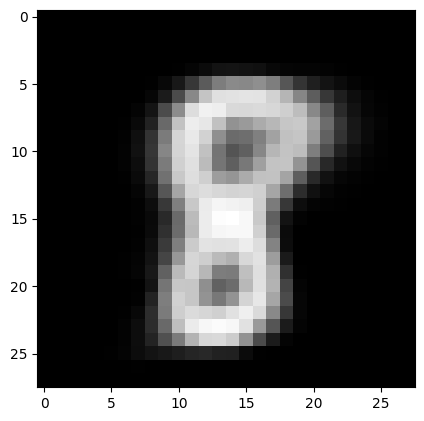

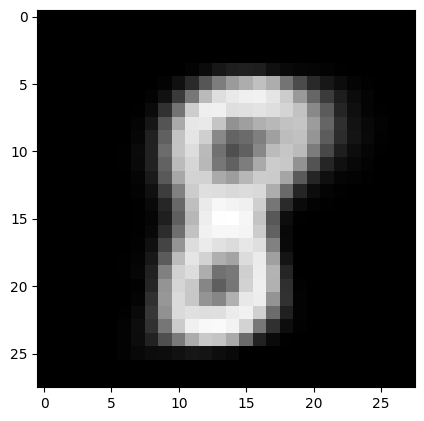

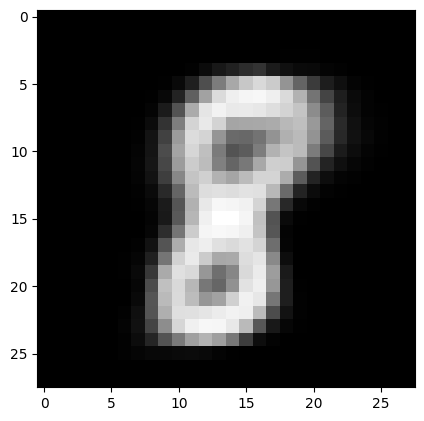

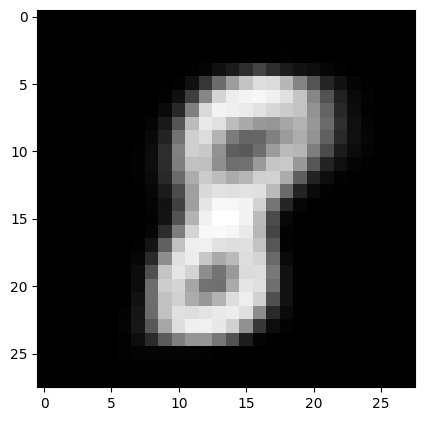

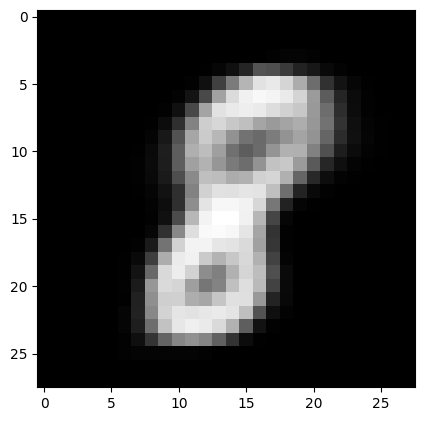

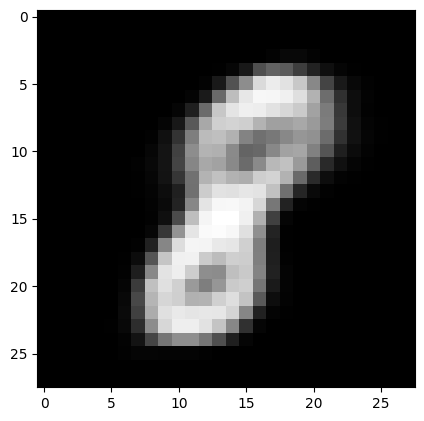

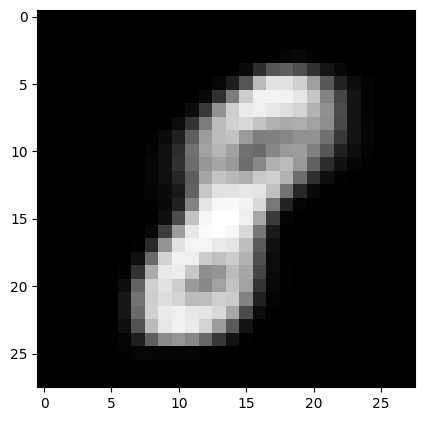

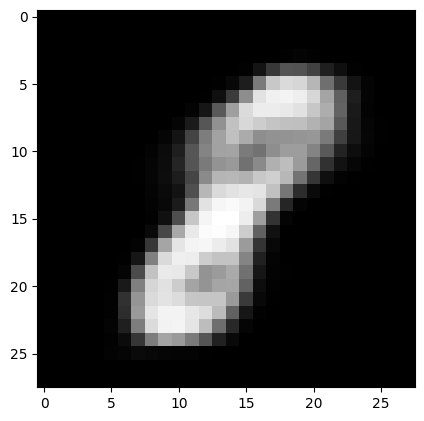

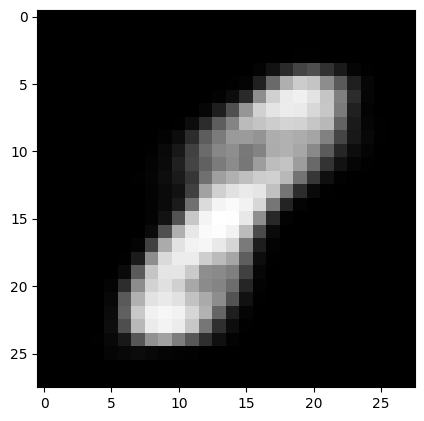

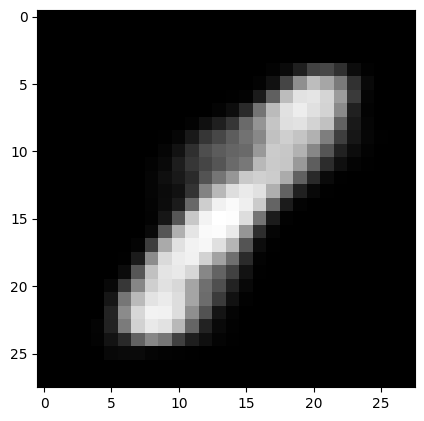

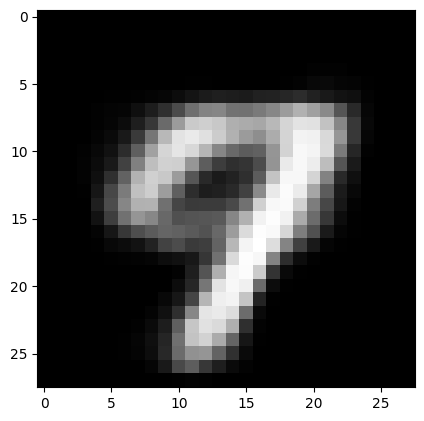

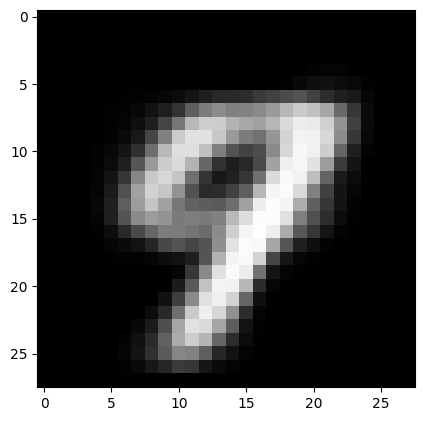

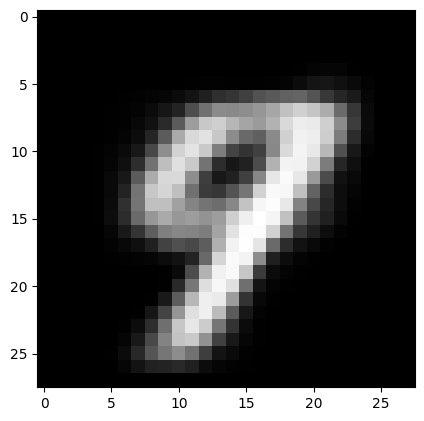

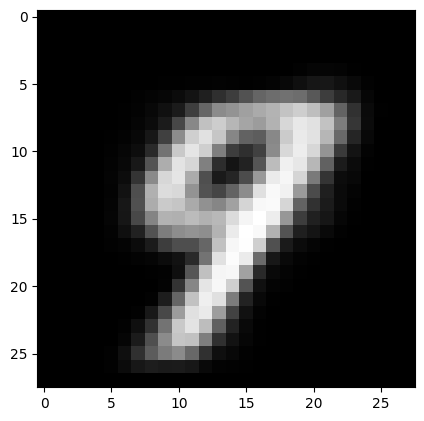

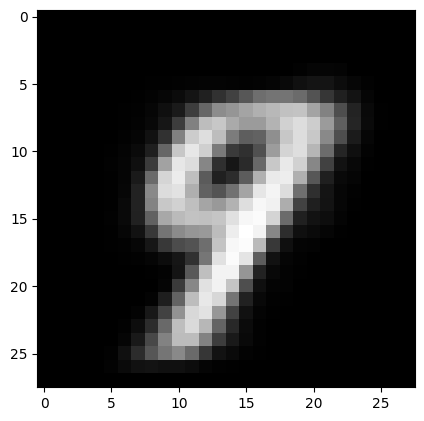

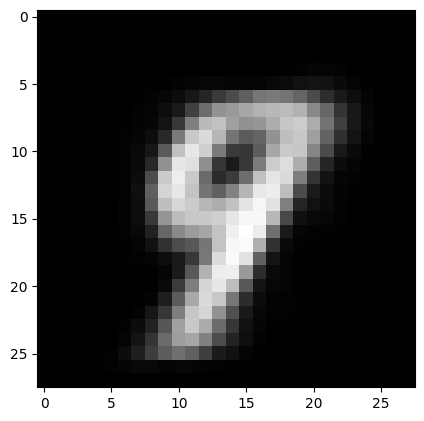

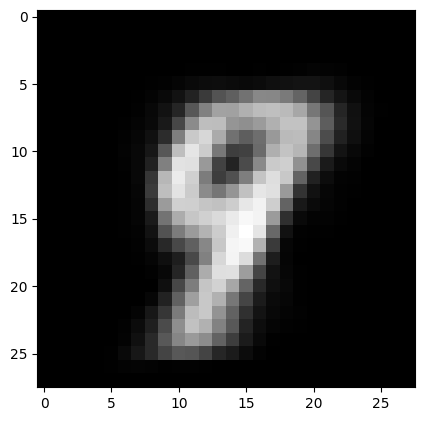

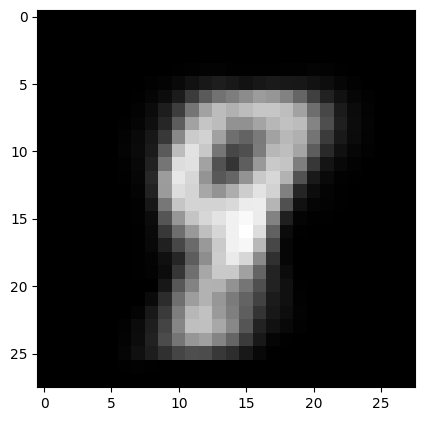

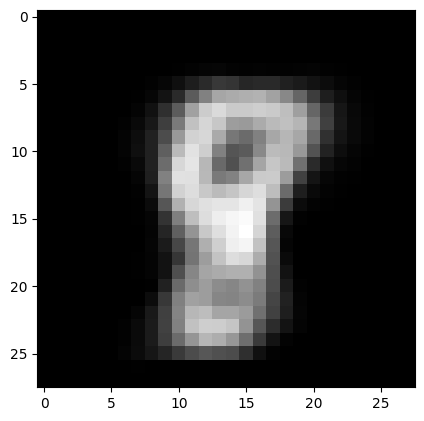

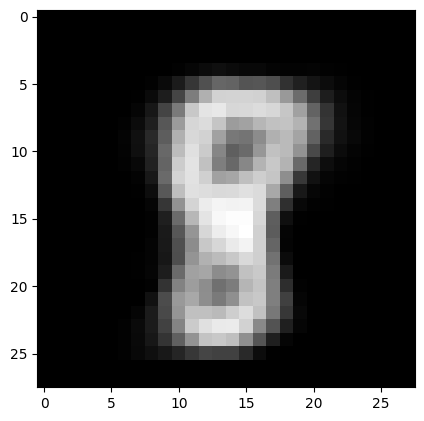

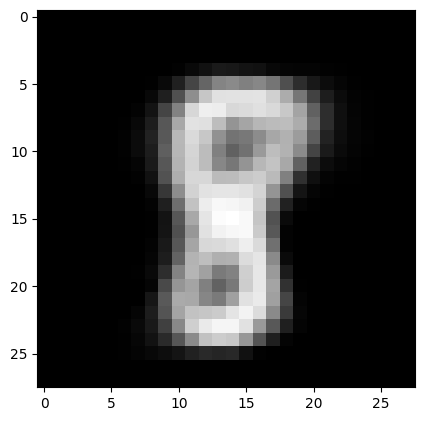

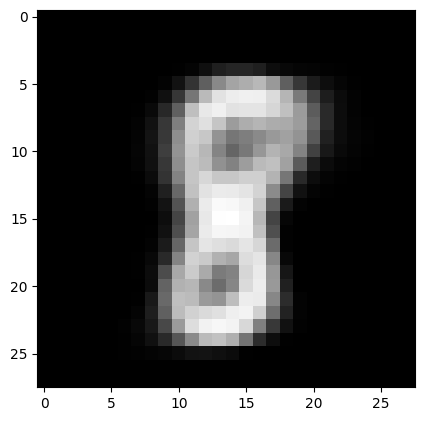

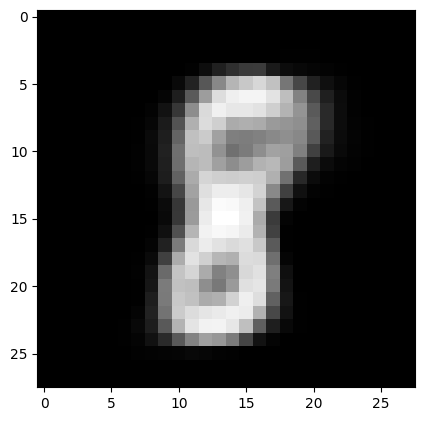

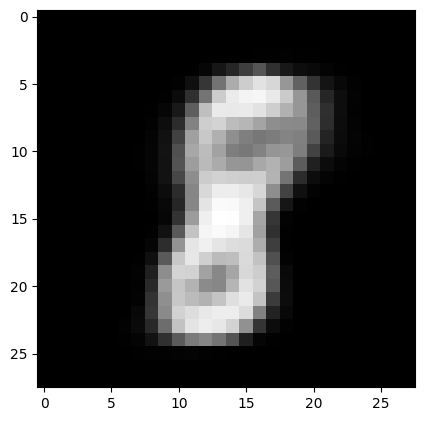

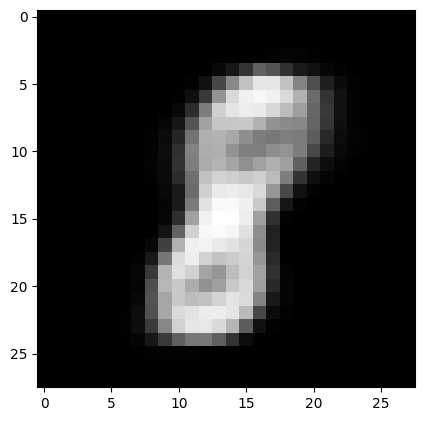

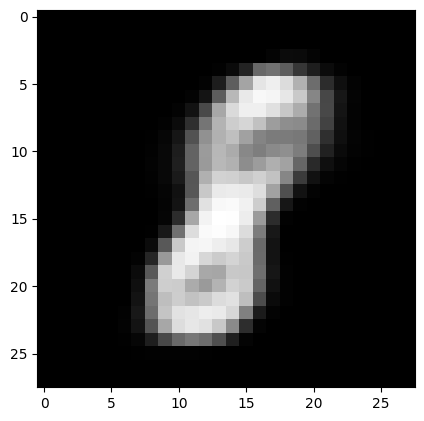

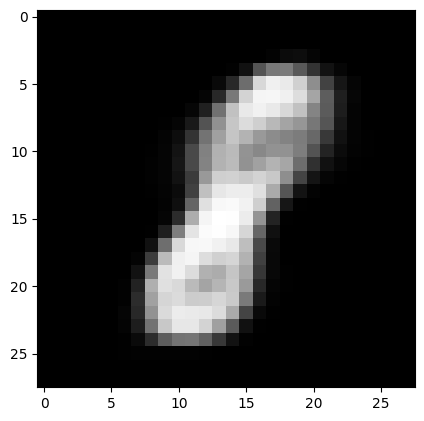

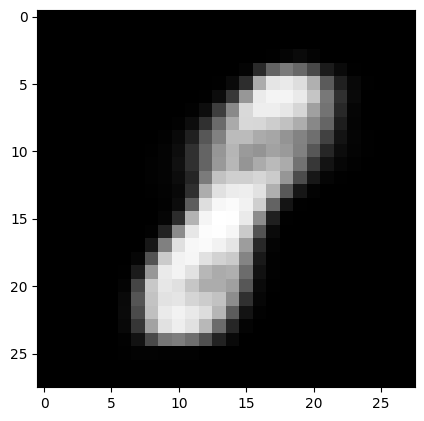

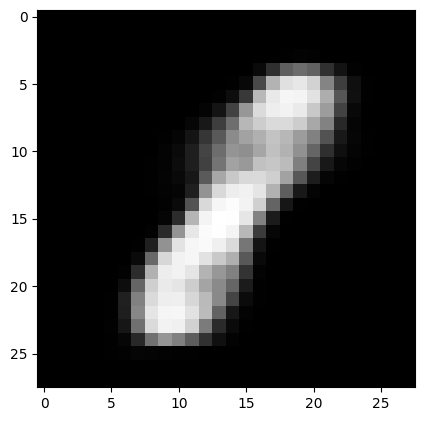

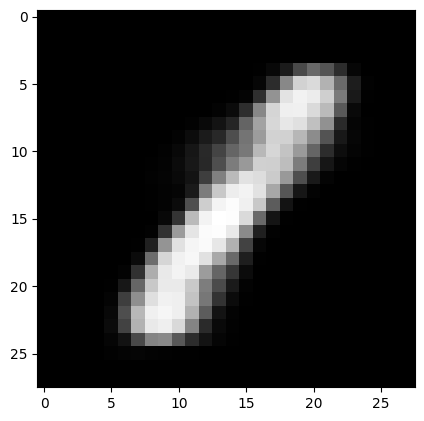

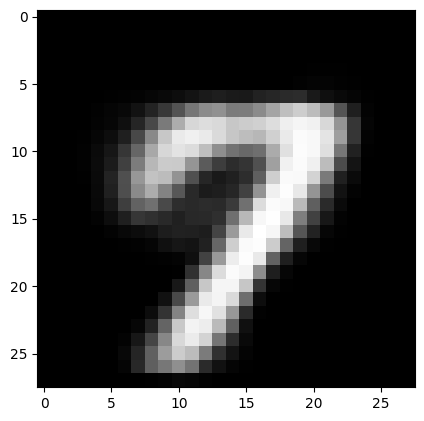

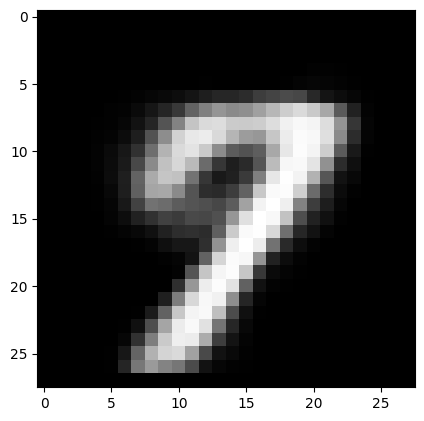

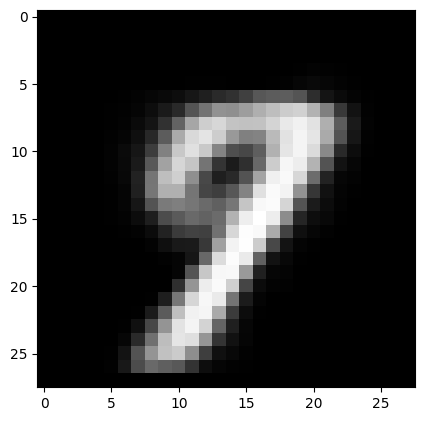

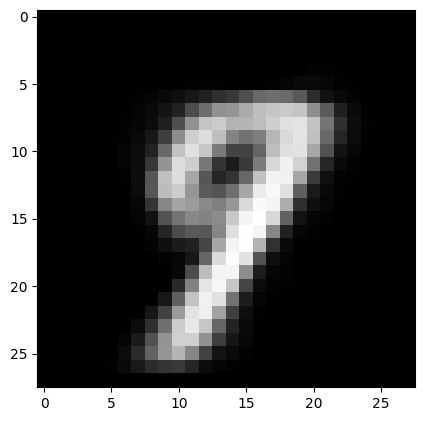

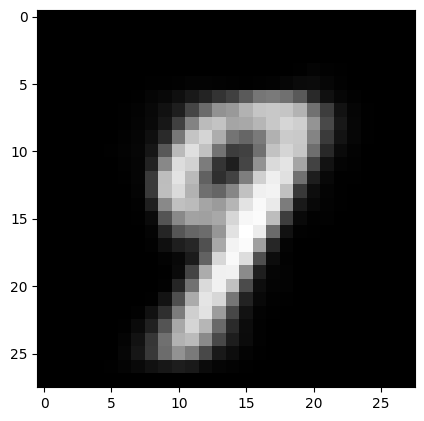

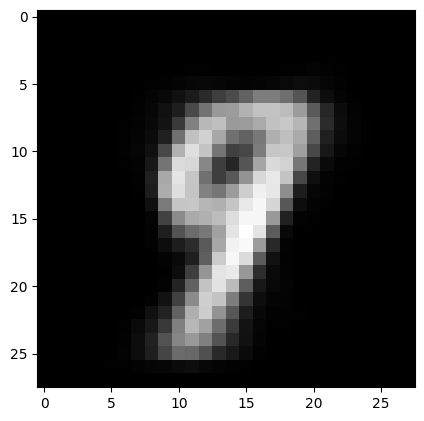

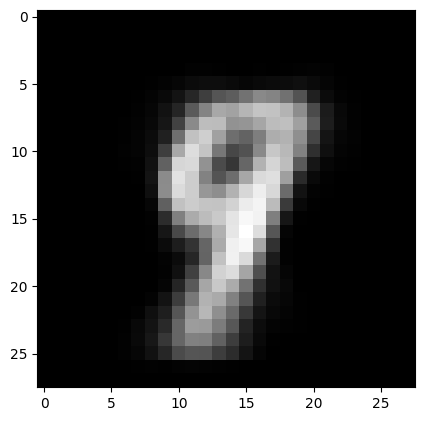

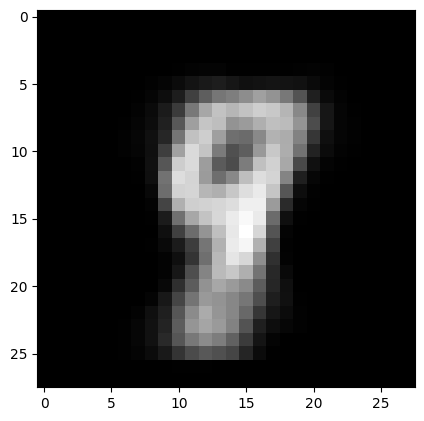

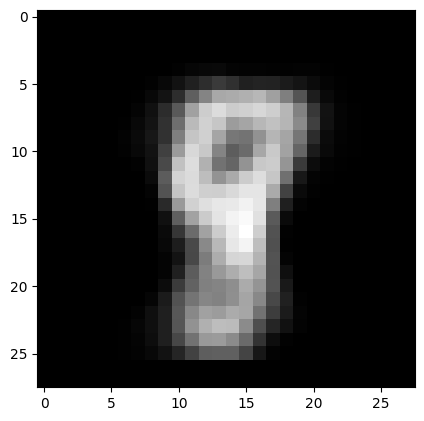

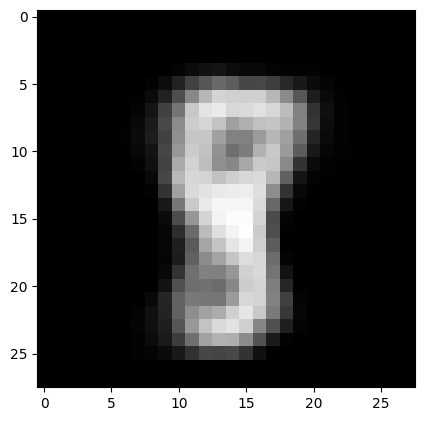

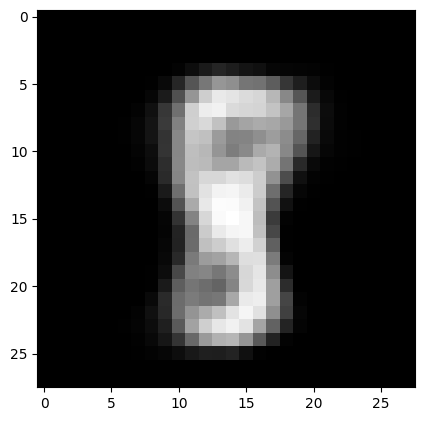

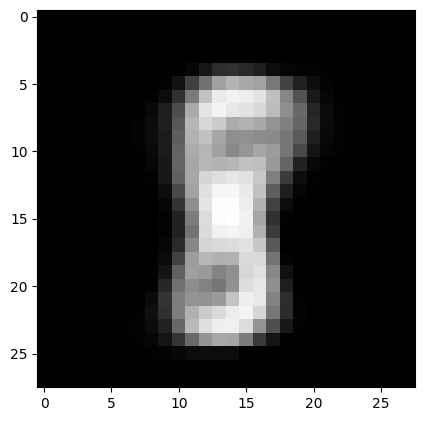

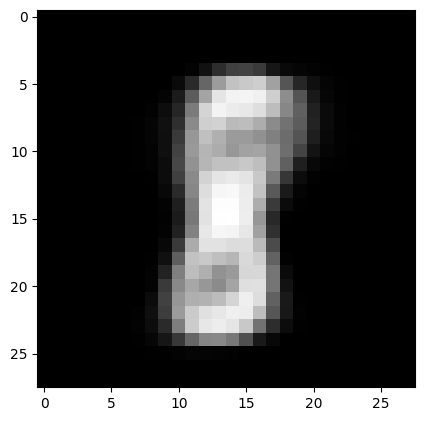

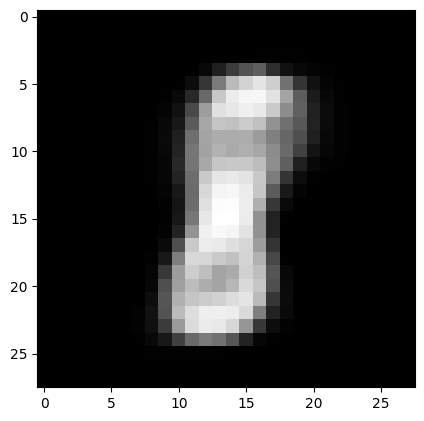

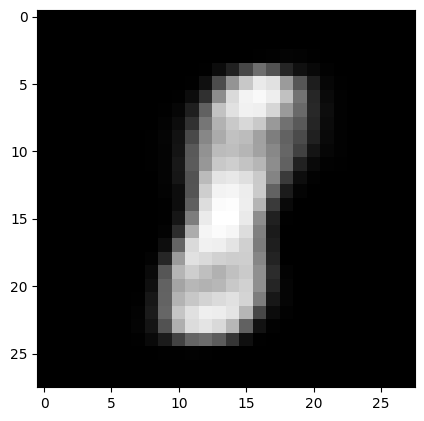

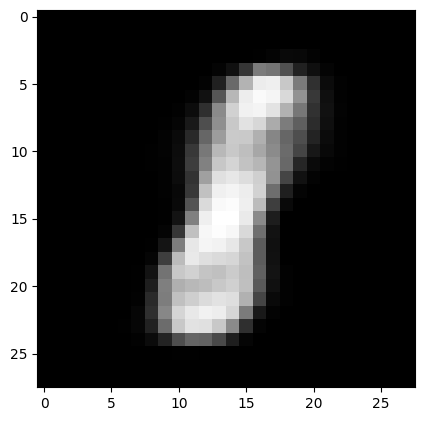

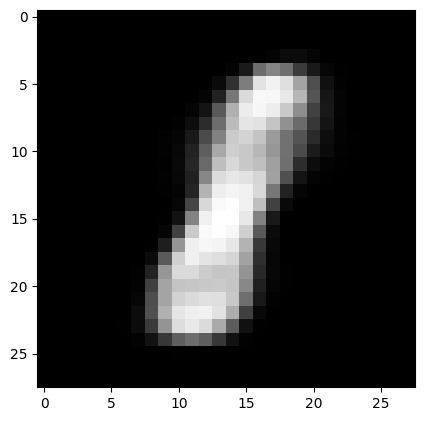

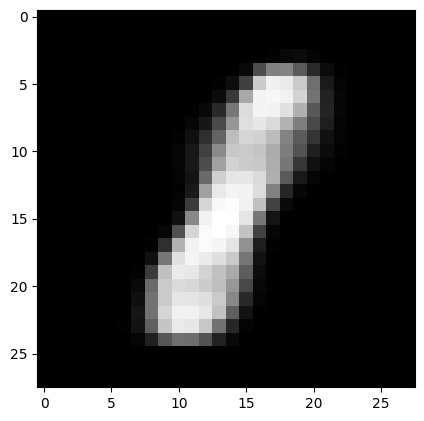

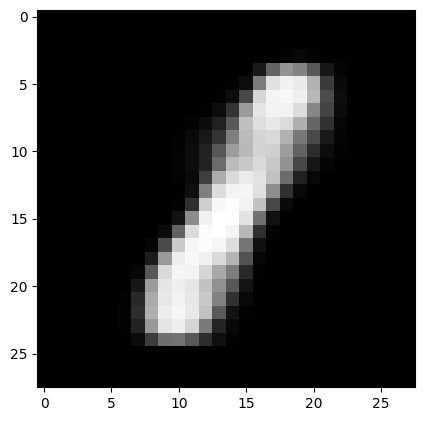

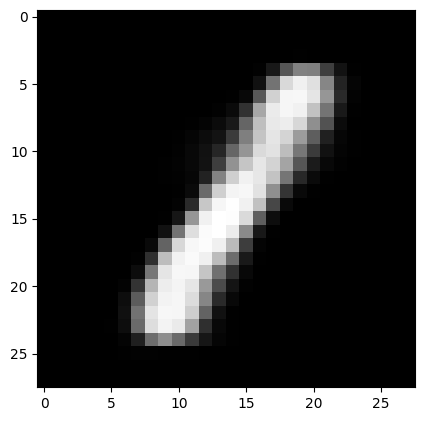

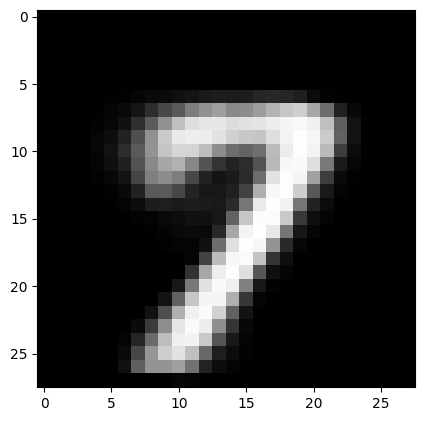

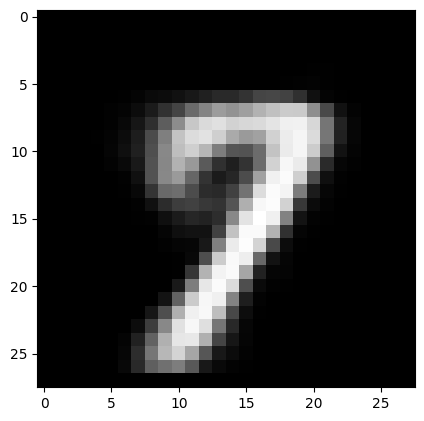

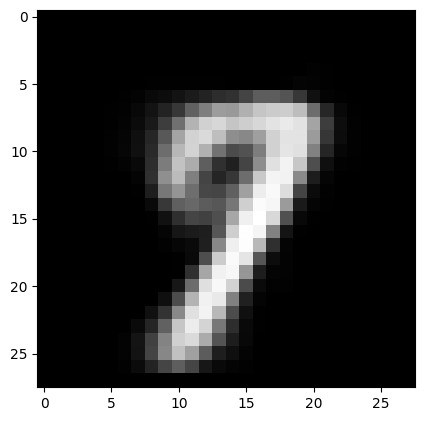

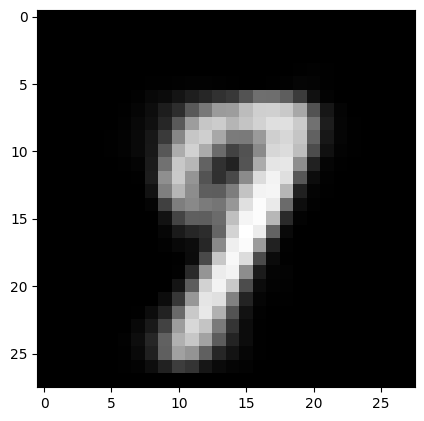

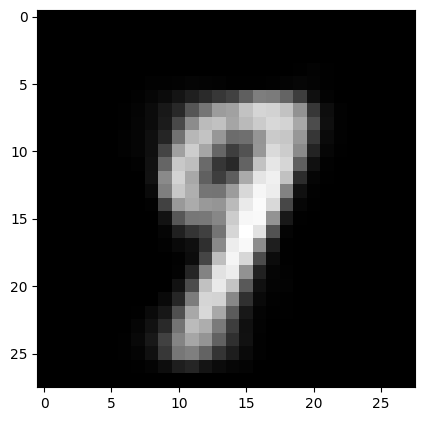

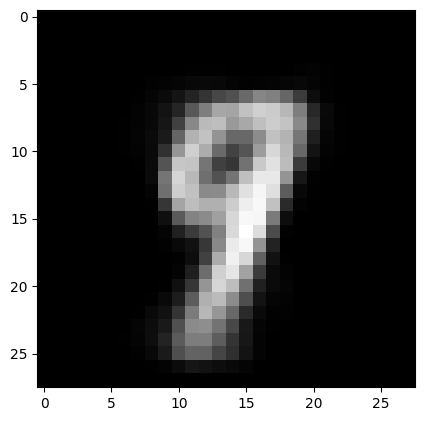

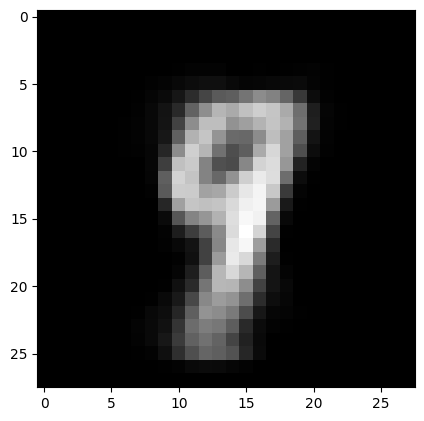

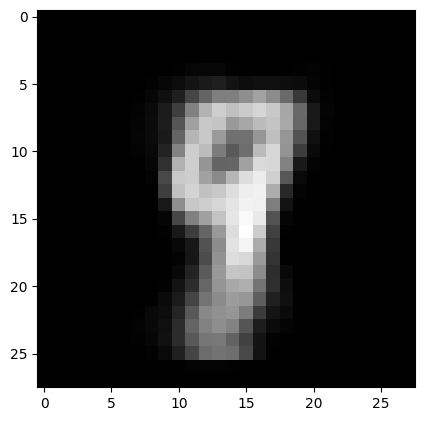

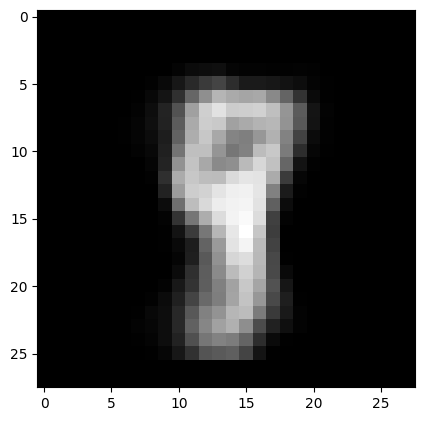

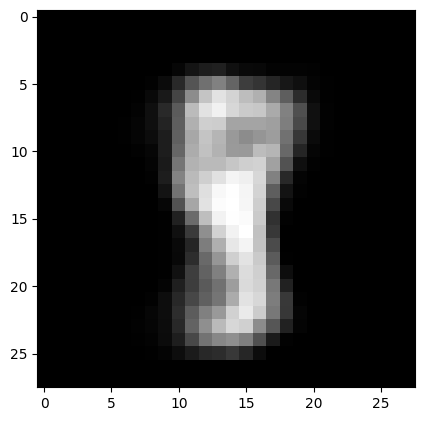

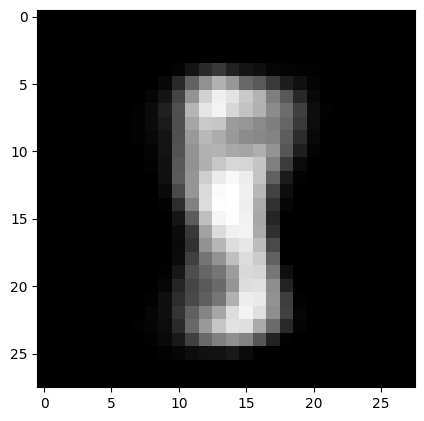

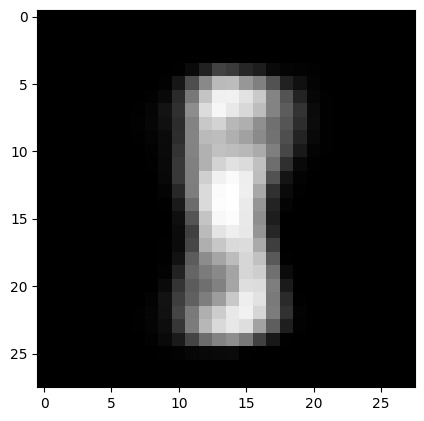

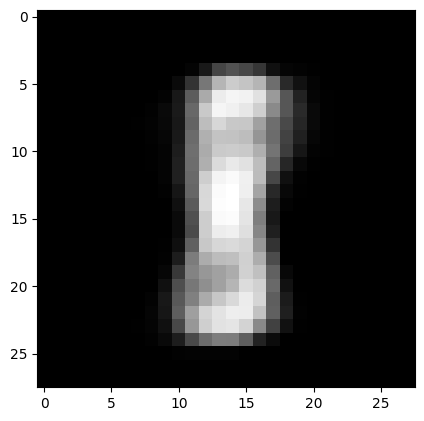

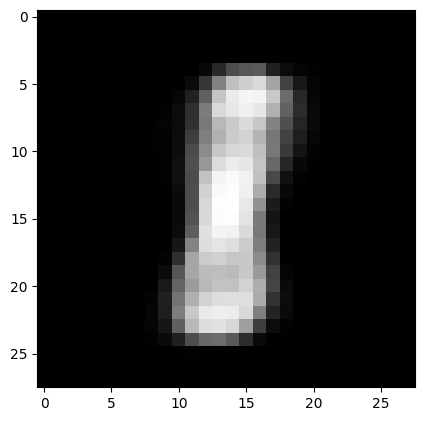

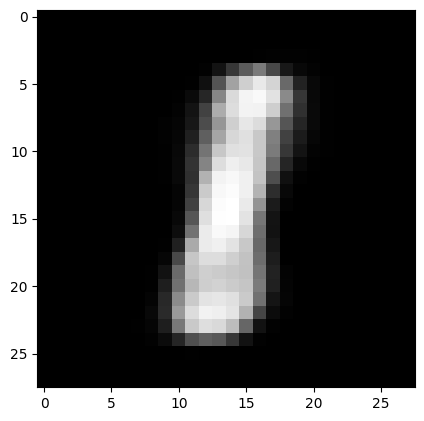

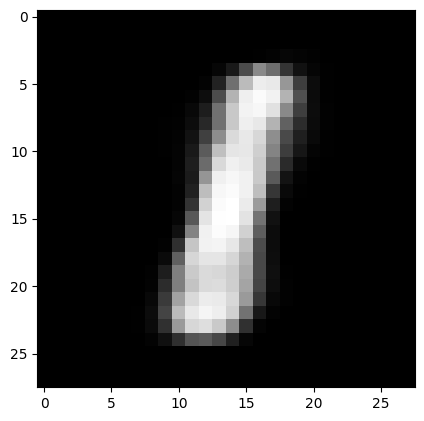

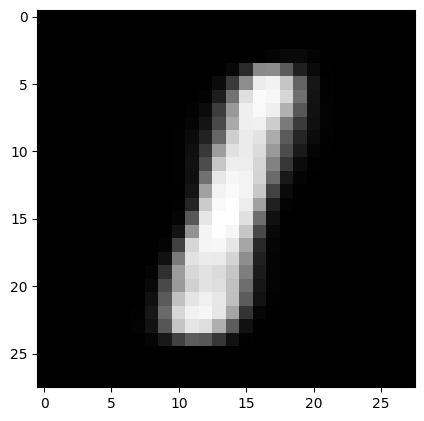

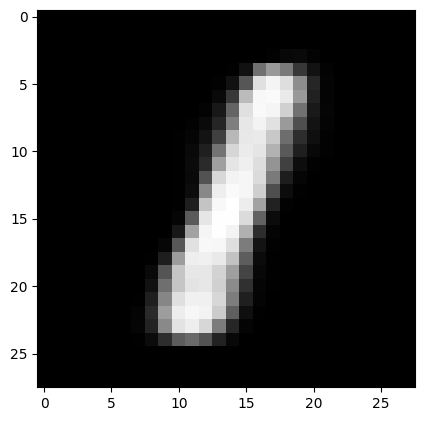

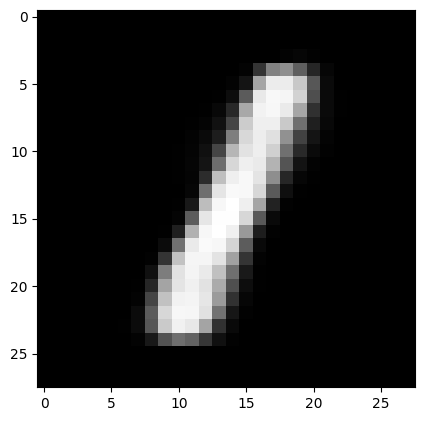

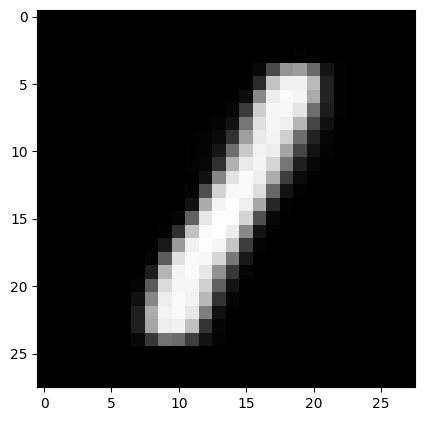

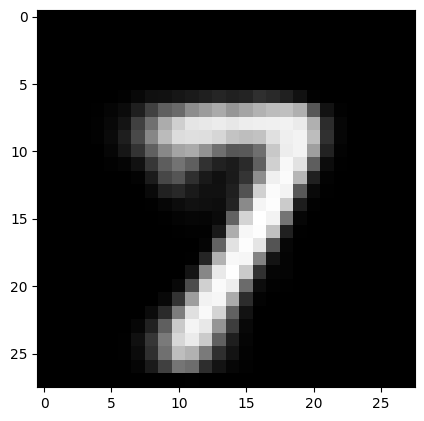

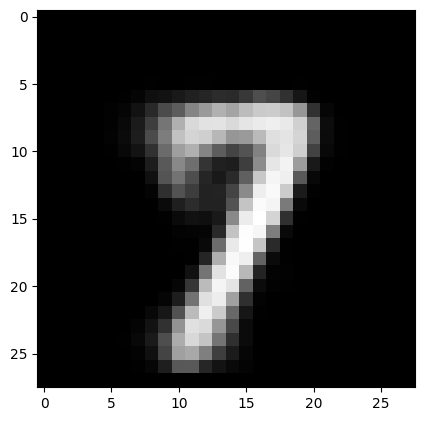

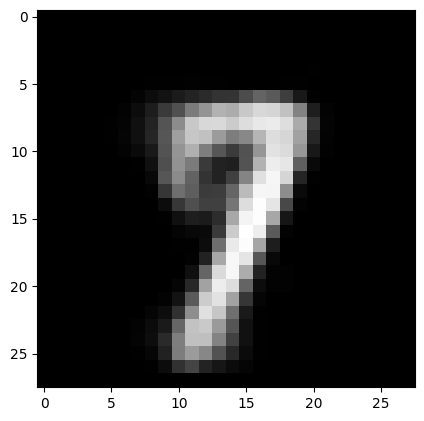

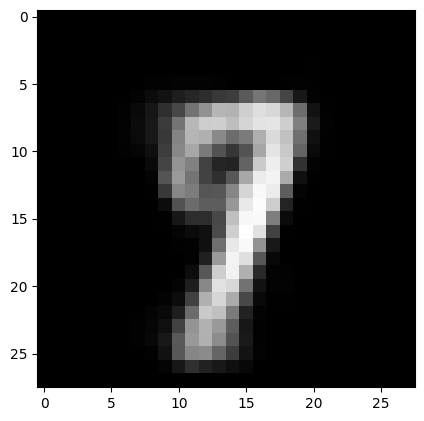

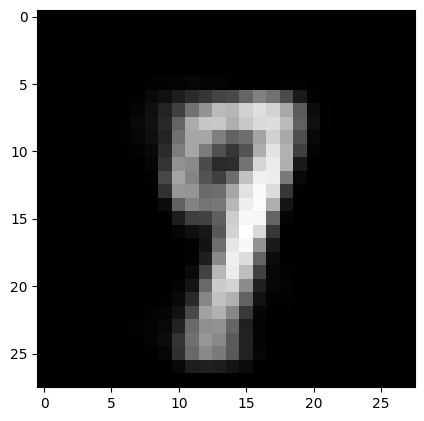

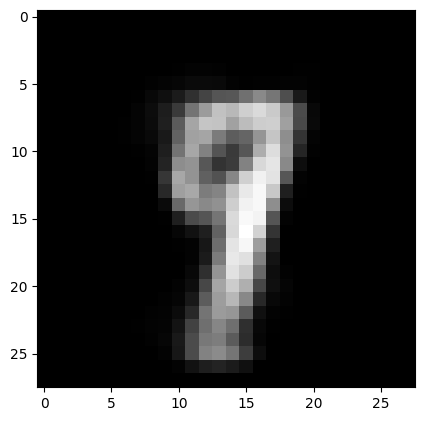

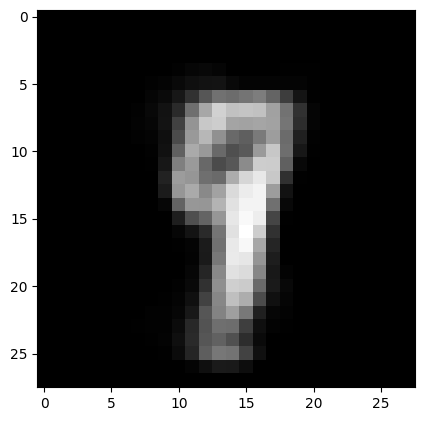

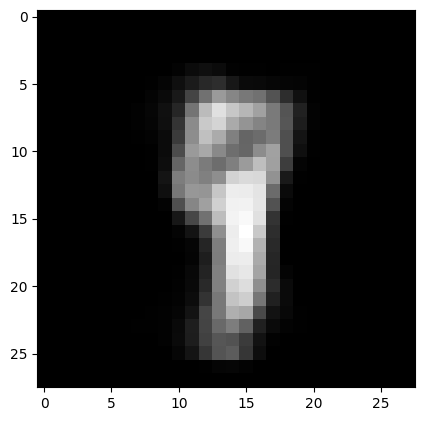

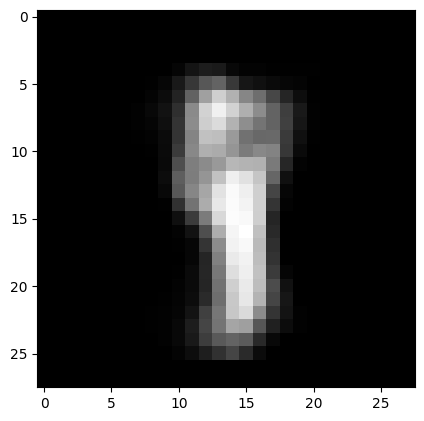

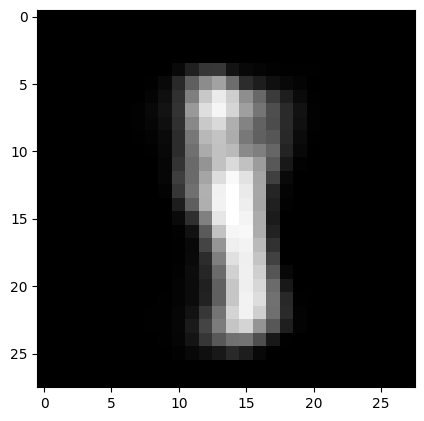

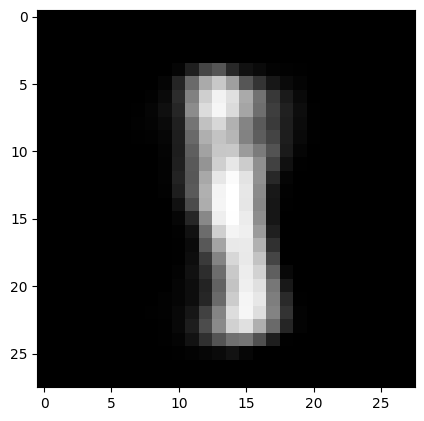

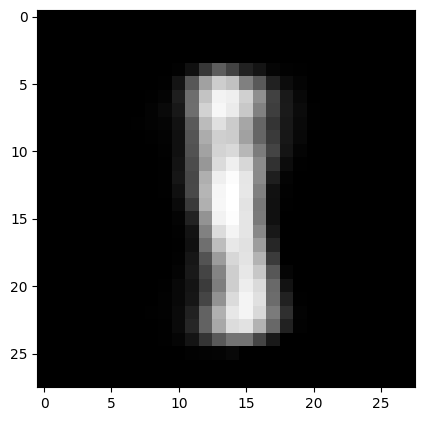

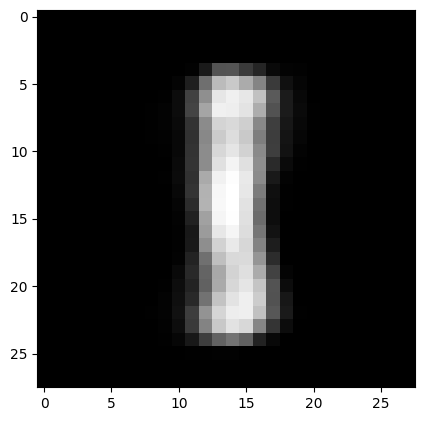

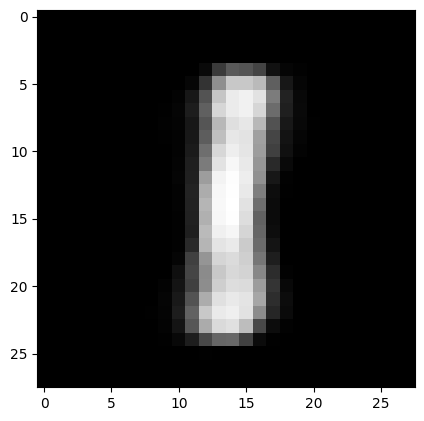

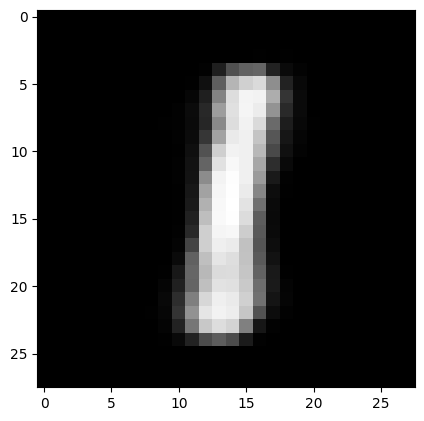

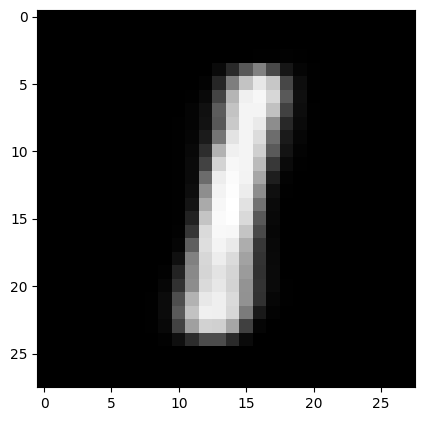

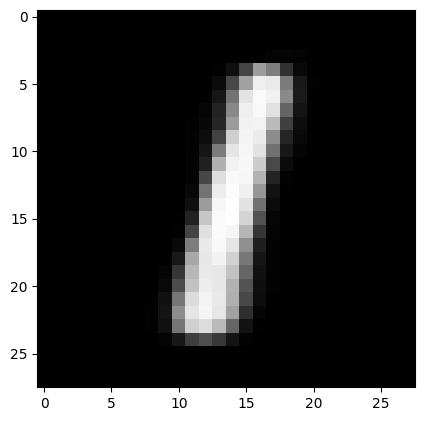

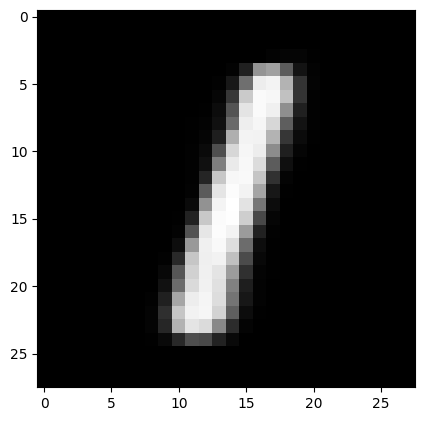

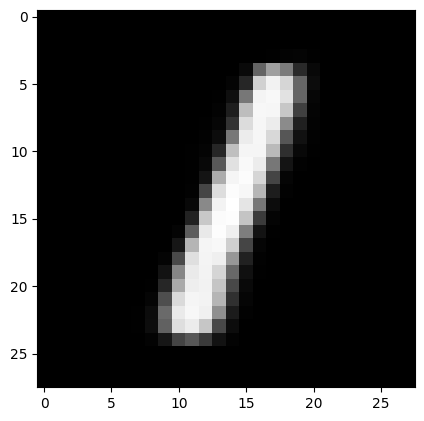

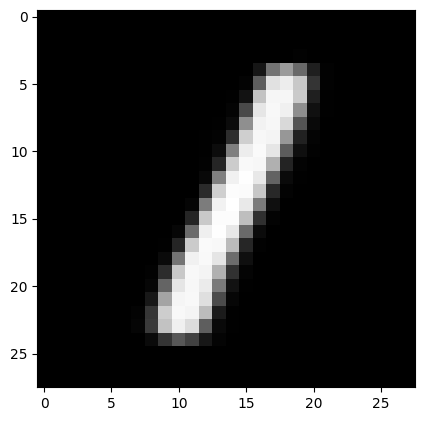

In [76]:
from PIL import Image
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 20  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))#
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
k=0
for i, yi in enumerate(grid_x):#enumerate(iterable, start=0)
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])#[0,0],[0,1]...
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

        plt.figure(figsize=(5, 5), dpi=100)
        plt.imshow(digit, cmap='Greys_r')
        
        plt.savefig('/content/sampling_vae/%d.png'%(k+1))
        k=k+1
        plt.show()
#plt.figure(figsize=(5, 5), dpi=100)
#plt.imshow(digit, cmap='Greys_r')
#plt.show()